#### All of the code below (including defining the functions) needs to be implemented (either by hitting the Run button above, or hitting  shift + enter)

In [1]:
#Import packages
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import linregress
from bioinfokit import analys, visuz
from bioinfokit.analys import stat
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import miceforest as mf

In [63]:
#Set figure resolution to 300dpi
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
#Optional for disabling warnings 
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Plot correlation matrix 

In [4]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

## Cluster Correlation Matrix

In [5]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [30]:
ttests=[]
def ttest(df, df_sub1, df_sub2):
    """
    This function takes two subsetted dataframes where
    protein ID's are along the index and the samples
    you are testing are in the columns, and performs a
    ttest to determine whether each protein in the 
    subsets are at different levels. This function
    returns the original dataframe with a new column 
    for the p-value associated with the t-test. 
    equal_var can be set to True or false depending 
    on whether you need to perform welches correction 
    on the data.
    
    parameters
    ----------
    df: pd.DataFrame
    df_sub1: pd.DataFrame
    df_sub2: pd.DataFrame
    
    returns
    -------
    dataframe with p-values
    
    """
    from scipy.stats import ttest_ind
    df_sub1 = df_sub1.transpose() # Transposition is  required
    df_sub2 = df_sub2.transpose()
    ttests = ttest_ind(df_sub1,df_sub2,equal_var=False,
                       nan_policy='omit')
    ttests = ttests.pvalue.transpose() # Transpose the pvalues back to the original orientation.
    df['ttest_pvalue']=ttests
    return df

In [31]:
def volcano(df, significantdf, foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=50, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

In [32]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp2')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp1')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

In [33]:
def fold(df, sub1, sub2, sub1name, sub2name):
    """
    Creates a new column in your dataframe (df) for fold change between
    two sample types (in separate dataframes sub1 and sub2).
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1 : pd.DataFrame
    sub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Newly formed column in your dataframe.
    """
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Fold Change(%s/%s)' % (sub1name, sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    return df['Fold Change(%s/%s)' % (sub1name, sub2name)]

In [34]:
def piscore(df,sub1name,sub2name):
    """
    pi score is a function which combines outputs from ttest and fold change functions
    and multiplies them to help pick biologically relevant hits within your systems.
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1name : string
    sub2name: string
    
    Returns
    -------
    Newly formed column in your dataframe
    
    
    """
    df['Log2(Fold Change)'] = np.log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']
    return df['%s/%s pi score' % (sub1name,sub2name)]

In [35]:
def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    """
    This function combines previously created user-defined functions to streamline the data
    analysis.
    
    Parameters
    ----------
    dfmain : pd.DataFrame
    dfsub1 : pd.DataFrame
    dfsub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Updated dataframe
    """
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)
    return dfmain

In [155]:
#Import normalized file (normalized by Svetlana)
Normalized_df = pd.read_csv(r'\Users\jonat\OneDrive\Documents\UCLAmassspec/Normalized.csv', index_col=0)
Normalized_df

,TMT_Grp4_117,TMT_Grp4_104,TMT_Grp2_125,TMT_Grp1_121,TMT_Grp3_103,TMT_Grp3_106,TMT_Grp1_134,TMT_Grp2_123,TMT_Grp4_112,TMT_Grp1_130,...,TMT_Grp3_115,TMT_Grp1_137,TMT_Grp2_131,TMT_Grp1_128,TMT_Grp3_101,TMT_Grp2_132,TMT_Grp4_102,TMT_Grp1_122,TMT_Grp2_139,TMT_Grp4_120
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,131.892175,174.334036,155.924749,230.260917,180.515772,256.302364,105.381750,144.340212,143.215590,187.676833
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.521731,174.340913,73.794377,159.309273,121.617649,120.716211,129.221329,137.379367,156.183798,157.744492
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,242.560155,136.293545,141.395158,101.661909,158.551723,133.372491,209.074300,352.086494,170.927823,116.948371
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,42.356801,223.611283,55.122966,233.397974,226.939385,177.297909,107.005493,91.017060,213.260267,170.996842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,27.485954,175.097667,132.030212,182.437801,221.093967,176.637508,138.448641,85.285878,216.919647,124.581726
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,84.747272,172.455628,128.844580,170.143231,136.108771,161.070582,193.541120,128.116747,158.233635,184.231892
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
#Import protein names from head dataset for reference - we will use this later to add annotation to the Master Protein list
proteinlist = pd.read_excel (r'\Users\jonat\OneDrive\Documents\UCLAmassspec/proteinlist.xlsx', index_col=0) 

#View dataframe
proteinlist.head()

,Proteins
Master Protein,
E9Q414,Apob
P01027,C3
Q61838,Pzp
P11276,Fn1
P01029,C4b


In [157]:
#Annotate the file with protein names
Normalized_df_annot = pd.merge(Normalized_df, proteinlist, left_index=True, right_index=True)
Normalized_df_annot

,TMT_Grp4_117,TMT_Grp4_104,TMT_Grp2_125,TMT_Grp1_121,TMT_Grp3_103,TMT_Grp3_106,TMT_Grp1_134,TMT_Grp2_123,TMT_Grp4_112,TMT_Grp1_130,...,TMT_Grp1_137,TMT_Grp2_131,TMT_Grp1_128,TMT_Grp3_101,TMT_Grp2_132,TMT_Grp4_102,TMT_Grp1_122,TMT_Grp2_139,TMT_Grp4_120,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ptprf
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,174.334036,155.924749,230.260917,180.515772,256.302364,105.381750,144.340212,143.215590,187.676833,Frmpd1
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,174.340913,73.794377,159.309273,121.617649,120.716211,129.221329,137.379367,156.183798,157.744492,Lrriq4
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,136.293545,141.395158,101.661909,158.551723,133.372491,209.074300,352.086494,170.927823,116.948371,Itih4
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,223.611283,55.122966,233.397974,226.939385,177.297909,107.005493,91.017060,213.260267,170.996842,Mmrn1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,175.097667,132.030212,182.437801,221.093967,176.637508,138.448641,85.285878,216.919647,124.581726,Pf4
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,172.455628,128.844580,170.143231,136.108771,161.070582,193.541120,128.116747,158.233635,184.231892,Thbs4
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Psma7


In [158]:
Normalized_df_annot.to_csv(r'./Annotation.csv')

In [159]:
#Determine the number of missing values in each sample column
Normalized_df.isnull().sum()

TMT_Grp4_117    36
TMT_Grp4_104    36
TMT_Grp2_125    36
TMT_Grp1_121    36
TMT_Grp3_103    36
TMT_Grp3_106    36
TMT_Grp1_134    36
TMT_Grp2_123    36
TMT_Grp4_112    36
TMT_Grp1_130    36
TMT_Grp2_135    36
TMT_Grp1_140    36
TMT_Grp2_136    36
TMT_Grp3_118    36
TMT_Grp3_110    36
TMT_Grp3_109    32
TMT_Grp4_119    32
TMT_Grp1_126    32
TMT_Grp2_129    32
TMT_Grp4_107    32
TMT_Grp3_115    32
TMT_Grp1_137    32
TMT_Grp2_131    32
TMT_Grp1_128    32
TMT_Grp3_101    32
TMT_Grp2_132    32
TMT_Grp4_102    32
TMT_Grp1_122    32
TMT_Grp2_139    32
TMT_Grp4_120    32
dtype: int64

In [40]:
#Determine the % of total missing values in each column
copydf = Normalized_df
copydf.isnull().sum()/len(copydf)

TMT_Grp4_117    0.138996
TMT_Grp4_104    0.138996
TMT_Grp2_125    0.138996
TMT_Grp1_121    0.138996
TMT_Grp3_103    0.138996
TMT_Grp3_106    0.138996
TMT_Grp1_134    0.138996
TMT_Grp2_123    0.138996
TMT_Grp4_112    0.138996
TMT_Grp1_130    0.138996
TMT_Grp2_135    0.138996
TMT_Grp1_140    0.138996
TMT_Grp2_136    0.138996
TMT_Grp3_118    0.138996
TMT_Grp3_110    0.138996
TMT_Grp3_109    0.123552
TMT_Grp4_119    0.123552
TMT_Grp1_126    0.123552
TMT_Grp2_129    0.123552
TMT_Grp4_107    0.123552
TMT_Grp3_115    0.123552
TMT_Grp1_137    0.123552
TMT_Grp2_131    0.123552
TMT_Grp1_128    0.123552
TMT_Grp3_101    0.123552
TMT_Grp2_132    0.123552
TMT_Grp4_102    0.123552
TMT_Grp1_122    0.123552
TMT_Grp2_139    0.123552
TMT_Grp4_120    0.123552
dtype: float64

## Visualizing the data without imputation (preferred method for some)

In [41]:
#Drop all missing values from Normalized_df and assign a new name (df1)
df1 = Normalized_df.dropna()

#View missing values in df1 dataframe
df1.isnull().sum().head()

TMT_Grp4_117    0
TMT_Grp4_104    0
TMT_Grp2_125    0
TMT_Grp1_121    0
TMT_Grp3_103    0
dtype: int64

In [42]:
#Use numpy to log2transform the data
df1 = np.log2(df1) #log2transforms the data
df1

,TMT_Grp4_117,TMT_Grp4_104,TMT_Grp2_125,TMT_Grp1_121,TMT_Grp3_103,TMT_Grp3_106,TMT_Grp1_134,TMT_Grp2_123,TMT_Grp4_112,TMT_Grp1_130,...,TMT_Grp3_115,TMT_Grp1_137,TMT_Grp2_131,TMT_Grp1_128,TMT_Grp3_101,TMT_Grp2_132,TMT_Grp4_102,TMT_Grp1_122,TMT_Grp2_139,TMT_Grp4_120
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2AKB4,7.412212,8.270750,7.796475,7.624483,7.977623,6.986868,7.514451,7.570499,7.998144,8.737072,...,7.043215,7.445710,7.284706,7.847126,7.495981,8.001703,6.719481,7.173329,7.162045,7.552107
A6X935,6.976949,6.895912,7.043404,6.890574,6.693020,7.525672,7.866856,7.813316,7.586003,7.081069,...,7.922199,7.090573,7.143589,6.667635,7.308810,7.059317,7.707872,8.459786,7.417243,6.869728
B2RPV6,7.809007,7.429898,7.291761,7.557566,8.357487,6.980667,7.734146,7.470408,7.414859,7.584970,...,5.404522,7.804849,5.784582,7.866648,7.826163,7.470032,6.741541,6.508065,7.736471,7.417826
E9PV24,6.926610,6.897659,6.636534,6.703556,7.014872,6.657186,7.939925,7.595063,6.905259,7.492008,...,7.012914,6.866675,8.180144,7.454715,7.321742,7.102144,6.723083,7.653867,7.553224,7.455916
E9Q414,7.166955,7.316909,6.998770,7.468337,7.342079,7.237542,7.981001,8.262522,7.574111,7.435419,...,6.529645,7.639860,6.611363,7.438450,7.203568,7.241531,7.160987,7.307933,7.247287,7.191596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9R1P4,7.293771,7.196768,7.556110,7.247220,7.306175,7.661327,7.015311,7.400839,6.966261,6.996429,...,6.191655,6.448686,8.796749,6.918944,7.675834,6.932429,7.801094,7.014799,6.755705,7.534489
Q9Z126,7.429459,7.149187,7.123911,7.196684,7.416222,7.575810,7.890565,7.203484,6.851436,6.657048,...,4.780623,7.452016,7.044724,7.511261,7.788516,7.464648,7.113207,6.414235,7.761017,6.960949
Q9Z1T2,6.977828,7.324002,6.918628,6.886630,7.316675,6.901942,7.534267,7.047288,6.391178,7.197108,...,6.405095,7.430081,7.009488,7.410606,7.088616,7.331549,7.596496,7.001315,7.305912,7.525379


array([[<AxesSubplot:title={'center':'TMT_Grp4_117'}>,
        <AxesSubplot:title={'center':'TMT_Grp4_104'}>,
        <AxesSubplot:title={'center':'TMT_Grp2_125'}>,
        <AxesSubplot:title={'center':'TMT_Grp1_121'}>,
        <AxesSubplot:title={'center':'TMT_Grp3_103'}>],
       [<AxesSubplot:title={'center':'TMT_Grp3_106'}>,
        <AxesSubplot:title={'center':'TMT_Grp1_134'}>,
        <AxesSubplot:title={'center':'TMT_Grp2_123'}>,
        <AxesSubplot:title={'center':'TMT_Grp4_112'}>,
        <AxesSubplot:title={'center':'TMT_Grp1_130'}>],
       [<AxesSubplot:title={'center':'TMT_Grp2_135'}>,
        <AxesSubplot:title={'center':'TMT_Grp1_140'}>,
        <AxesSubplot:title={'center':'TMT_Grp2_136'}>,
        <AxesSubplot:title={'center':'TMT_Grp3_118'}>,
        <AxesSubplot:title={'center':'TMT_Grp3_110'}>],
       [<AxesSubplot:title={'center':'TMT_Grp3_109'}>,
        <AxesSubplot:title={'center':'TMT_Grp4_119'}>,
        <AxesSubplot:title={'center':'TMT_Grp1_126'}>,
       

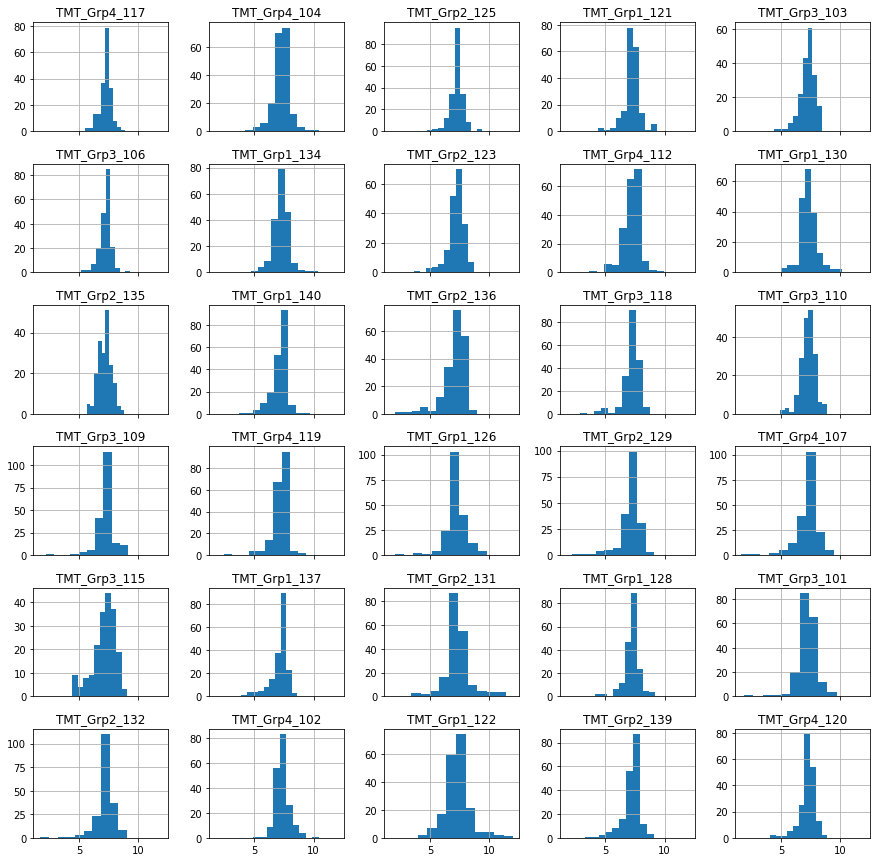

In [43]:
#View the distribution of each column
df1.hist(figsize=(15,15), sharex = True)

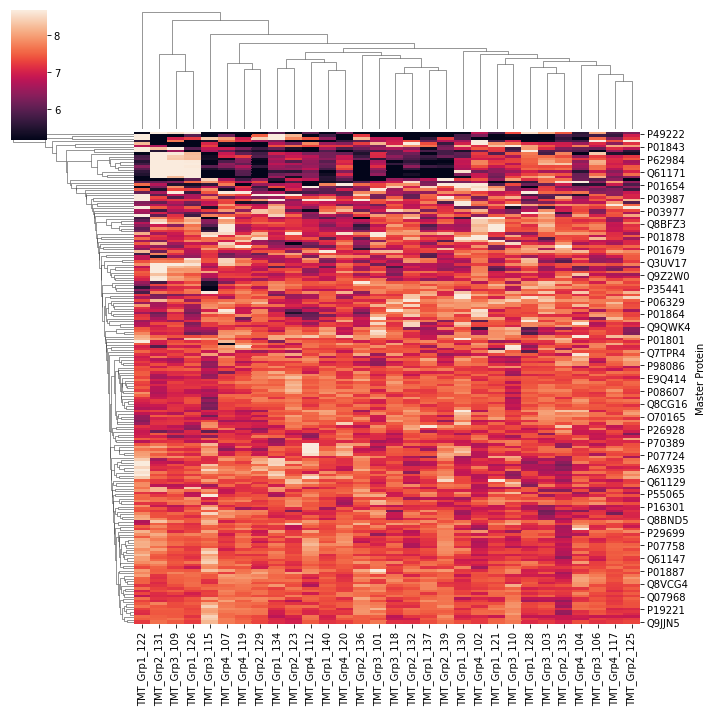

In [44]:
#Perform a mainly default settings (added robustness for better visualization) heirchical clustering analysis on the data using seaborn clustermap to look for batch effects
sns.clustermap(df1, robust = True)

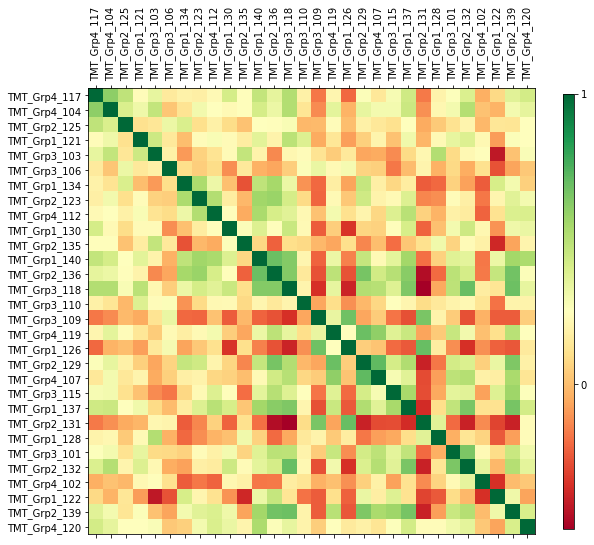

In [45]:
plot_corr(df1)

<AxesSubplot:>

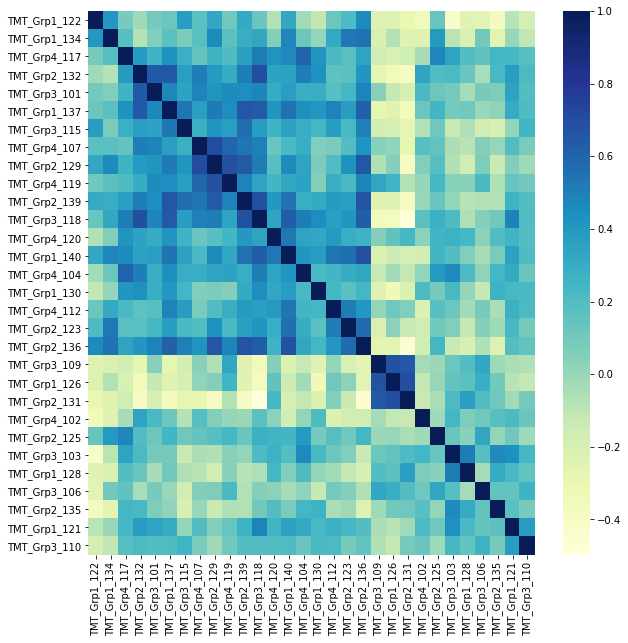

In [46]:
#sns.heatmap(df.corr()) 
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(cluster_corr(df1.corr()), cmap='YlGnBu', ax=ax)

In [47]:
#Export dataframes to csv with index - 
Normalized_df.to_csv(r'\Users\jonat\OneDrive\Documents\UCLAmassspec\Normalized_df.csv')


Named the files in excel and reimporting back

In [18]:
# load data file
Normalized_df2 = pd.read_excel (r'\Users\jonat\OneDrive\Documents\UCLAmassspec\Normalized_df_named.xlsx', index_col=0)

In [19]:
#Annotate the file with protein names
Normalized_df_annot = pd.merge(Normalized_df2, proteinlist, left_index=True, right_index=True)
Normalized_df_annot

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp1.5,Grp2.5,Grp1.6,Grp3.6,Grp2.6,Grp4.5,Grp1.7,Grp2.7,Grp4.6,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ptprf
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,174.334036,155.924749,230.260917,180.515772,256.302364,105.381750,144.340212,143.215590,187.676833,Frmpd1
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,174.340913,73.794377,159.309273,121.617649,120.716211,129.221329,137.379367,156.183798,157.744492,Lrriq4
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,136.293545,141.395158,101.661909,158.551723,133.372491,209.074300,352.086494,170.927823,116.948371,Itih4
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,223.611283,55.122966,233.397974,226.939385,177.297909,107.005493,91.017060,213.260267,170.996842,Mmrn1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,175.097667,132.030212,182.437801,221.093967,176.637508,138.448641,85.285878,216.919647,124.581726,Pf4
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,172.455628,128.844580,170.143231,136.108771,161.070582,193.541120,128.116747,158.233635,184.231892,Thbs4
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Psma7


In [20]:
#Export dataframes to csv with index - 
Normalized_df_annot.to_csv(r'\Users\jonat\OneDrive\Documents\Cmah_aging\Normalized_df_annot.csv')

In [21]:
#Drop missing values
df2 = Normalized_df2.dropna()
df2

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp3.5,Grp1.5,Grp2.5,Grp1.6,Grp3.6,Grp2.6,Grp4.5,Grp1.7,Grp2.7,Grp4.6
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,131.892175,174.334036,155.924749,230.260917,180.515772,256.302364,105.381750,144.340212,143.215590,187.676833
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,242.560155,136.293545,141.395158,101.661909,158.551723,133.372491,209.074300,352.086494,170.927823,116.948371
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,42.356801,223.611283,55.122966,233.397974,226.939385,177.297909,107.005493,91.017060,213.260267,170.996842
E9PV24,121.651512,119.234556,99.493750,104.224907,129.326347,100.928265,245.558802,193.348890,119.864382,180.019384,...,129.150945,116.701172,290.047284,175.425522,159.979330,137.391064,105.645204,201.392601,187.822173,175.571661
E9Q414,143.703850,159.444329,127.890955,177.089731,162.250463,150.909681,252.650854,307.090998,190.561216,173.094791,...,92.388715,199.446731,97.772941,173.458881,147.397444,151.327566,143.110632,158.455440,151.932503,146.179335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9R1P4,156.907525,146.704368,188.198325,151.925444,158.262400,202.436685,129.365648,168.995281,125.041271,127.683599,...,73.092683,87.346959,444.718506,121.006806,204.482555,122.143139,223.029942,129.319752,108.061211,185.398923
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,27.485954,175.097667,132.030212,182.437801,221.093967,176.637508,138.448641,85.285878,216.919647,124.581726
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,84.747272,172.455628,128.844580,170.143231,136.108771,161.070582,193.541120,128.116747,158.233635,184.231892


In [22]:
#Use numpy to log2transform the data
df22 = np.log2(df2) #log2transforms the data
df22 

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp3.5,Grp1.5,Grp2.5,Grp1.6,Grp3.6,Grp2.6,Grp4.5,Grp1.7,Grp2.7,Grp4.6
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2AKB4,7.412212,8.270750,7.796475,7.624483,7.977623,6.986868,7.514451,7.570499,7.998144,8.737072,...,7.043215,7.445710,7.284706,7.847126,7.495981,8.001703,6.719481,7.173329,7.162045,7.552107
A6X935,6.976949,6.895912,7.043404,6.890574,6.693020,7.525672,7.866856,7.813316,7.586003,7.081069,...,7.922199,7.090573,7.143589,6.667635,7.308810,7.059317,7.707872,8.459786,7.417243,6.869728
B2RPV6,7.809007,7.429898,7.291761,7.557566,8.357487,6.980667,7.734146,7.470408,7.414859,7.584970,...,5.404522,7.804849,5.784582,7.866648,7.826163,7.470032,6.741541,6.508065,7.736471,7.417826
E9PV24,6.926610,6.897659,6.636534,6.703556,7.014872,6.657186,7.939925,7.595063,6.905259,7.492008,...,7.012914,6.866675,8.180144,7.454715,7.321742,7.102144,6.723083,7.653867,7.553224,7.455916
E9Q414,7.166955,7.316909,6.998770,7.468337,7.342079,7.237542,7.981001,8.262522,7.574111,7.435419,...,6.529645,7.639860,6.611363,7.438450,7.203568,7.241531,7.160987,7.307933,7.247287,7.191596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9R1P4,7.293771,7.196768,7.556110,7.247220,7.306175,7.661327,7.015311,7.400839,6.966261,6.996429,...,6.191655,6.448686,8.796749,6.918944,7.675834,6.932429,7.801094,7.014799,6.755705,7.534489
Q9Z126,7.429459,7.149187,7.123911,7.196684,7.416222,7.575810,7.890565,7.203484,6.851436,6.657048,...,4.780623,7.452016,7.044724,7.511261,7.788516,7.464648,7.113207,6.414235,7.761017,6.960949
Q9Z1T2,6.977828,7.324002,6.918628,6.886630,7.316675,6.901942,7.534267,7.047288,6.391178,7.197108,...,6.405095,7.430081,7.009488,7.410606,7.088616,7.331549,7.596496,7.001315,7.305912,7.525379


In [23]:
df22.to_csv(r'\Users\jonat\OneDrive\Documents\Cmah_aging\Normalized_df_dropped.csv')


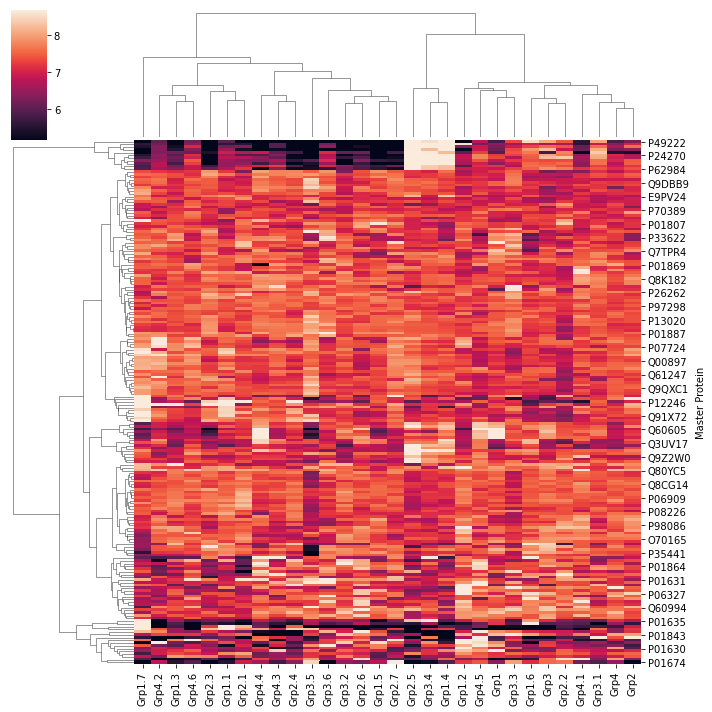

In [24]:
sns.clustermap(df22, robust = True, method = 'ward')

<AxesSubplot:>

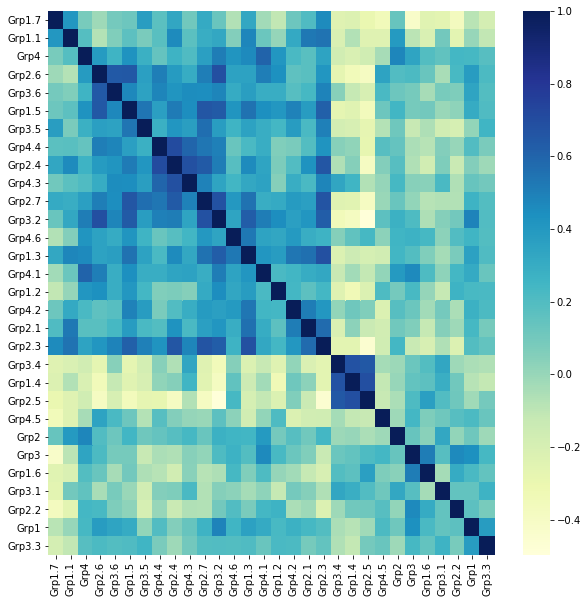

In [25]:
#sns.heatmap(df.corr()) # unclustered version
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(cluster_corr(df22.corr()), cmap='YlGnBu', ax=ax)

In [26]:
df22.columns = ['Grp4','Grp4','Grp2','Grp1','Grp3','Grp3','Grp1','Grp2','Grp4','Grp1','Grp2','Grp1','Grp2','Grp3','Grp3','Grp3','Grp4','Grp1','Grp2','Grp4','Grp3','Grp1','Grp2','Grp1','Grp3','Grp2','Grp4','Grp1','Grp2','Grp4',]
df22

,Grp4,Grp4,Grp2,Grp1,Grp3,Grp3,Grp1,Grp2,Grp4,Grp1,...,Grp3,Grp1,Grp2,Grp1,Grp3,Grp2,Grp4,Grp1,Grp2,Grp4
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2AKB4,7.412212,8.270750,7.796475,7.624483,7.977623,6.986868,7.514451,7.570499,7.998144,8.737072,...,7.043215,7.445710,7.284706,7.847126,7.495981,8.001703,6.719481,7.173329,7.162045,7.552107
A6X935,6.976949,6.895912,7.043404,6.890574,6.693020,7.525672,7.866856,7.813316,7.586003,7.081069,...,7.922199,7.090573,7.143589,6.667635,7.308810,7.059317,7.707872,8.459786,7.417243,6.869728
B2RPV6,7.809007,7.429898,7.291761,7.557566,8.357487,6.980667,7.734146,7.470408,7.414859,7.584970,...,5.404522,7.804849,5.784582,7.866648,7.826163,7.470032,6.741541,6.508065,7.736471,7.417826
E9PV24,6.926610,6.897659,6.636534,6.703556,7.014872,6.657186,7.939925,7.595063,6.905259,7.492008,...,7.012914,6.866675,8.180144,7.454715,7.321742,7.102144,6.723083,7.653867,7.553224,7.455916
E9Q414,7.166955,7.316909,6.998770,7.468337,7.342079,7.237542,7.981001,8.262522,7.574111,7.435419,...,6.529645,7.639860,6.611363,7.438450,7.203568,7.241531,7.160987,7.307933,7.247287,7.191596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9R1P4,7.293771,7.196768,7.556110,7.247220,7.306175,7.661327,7.015311,7.400839,6.966261,6.996429,...,6.191655,6.448686,8.796749,6.918944,7.675834,6.932429,7.801094,7.014799,6.755705,7.534489
Q9Z126,7.429459,7.149187,7.123911,7.196684,7.416222,7.575810,7.890565,7.203484,6.851436,6.657048,...,4.780623,7.452016,7.044724,7.511261,7.788516,7.464648,7.113207,6.414235,7.761017,6.960949
Q9Z1T2,6.977828,7.324002,6.918628,6.886630,7.316675,6.901942,7.534267,7.047288,6.391178,7.197108,...,6.405095,7.430081,7.009488,7.410606,7.088616,7.331549,7.596496,7.001315,7.305912,7.525379


In [27]:
df2transpose = df22.transpose()
df2transpose


Master Protein,A2AKB4,A6X935,B2RPV6,E9PV24,E9Q414,O08677,O70165,O70362,O70570,O88200,...,Q9JJN5,Q9QUM9,Q9QWK4,Q9QXC1,Q9R1P3,Q9R1P4,Q9Z126,Q9Z1T2,Q9Z2U1,Q9Z2W0
Grp4,7.412212,6.976949,7.809007,6.926610,7.166955,7.516215,7.617652,6.913495,7.496173,7.223850,...,7.249311,6.816522,7.362642,7.486458,7.378412,7.293771,7.429459,6.977828,7.513637,6.642242
Grp4,8.270750,6.895912,7.429898,6.897659,7.316909,7.250805,7.951272,6.972176,7.406292,6.895592,...,7.385907,6.553360,7.711038,7.051330,7.523178,7.196768,7.149187,7.324002,7.416577,8.341399
Grp2,7.796475,7.043404,7.291761,6.636534,6.998770,7.319731,7.663783,6.894804,7.558886,6.299643,...,7.331452,6.979505,7.115894,7.572724,7.736381,7.556110,7.123911,6.918628,7.542158,6.529102
Grp1,7.624483,6.890574,7.557566,6.703556,7.468337,7.176689,7.674207,6.882313,7.153083,7.037497,...,7.533813,6.886630,7.301291,7.027749,7.194969,7.247220,7.196684,6.886630,6.944474,7.022951
Grp3,7.977623,6.693020,8.357487,7.014872,7.342079,7.265903,7.915661,6.835911,7.196567,6.467839,...,7.236111,6.829868,7.538994,7.172114,7.168398,7.306175,7.416222,7.316675,6.980413,6.796593
Grp3,6.986868,7.525672,6.980667,6.657186,7.237542,7.336327,7.631751,6.877020,6.962272,6.851952,...,7.155875,7.346578,6.787325,7.220569,7.502974,7.661327,7.575810,6.901942,7.248938,6.820844
Grp1,7.514451,7.866856,7.734146,7.939925,7.981001,7.417276,7.567738,6.798861,7.825560,7.222364,...,7.101798,6.889120,7.213264,7.655307,7.380973,7.015311,7.890565,7.534267,7.117745,6.645879
Grp2,7.570499,7.813316,7.470408,7.595063,8.262522,7.301695,8.002214,7.011240,8.054714,6.739799,...,6.982167,7.156942,7.280893,7.421246,7.074479,7.400839,7.203484,7.047288,7.563209,7.038091
Grp4,7.998144,7.586003,7.414859,6.905259,7.574111,8.014334,7.512513,7.646813,6.971899,6.507052,...,7.464990,7.246797,6.884081,7.840657,6.945263,6.966261,6.851436,6.391178,6.413623,6.654015
Grp1,8.737072,7.081069,7.584970,7.492008,7.435419,7.818497,8.092811,6.988280,7.882071,6.657444,...,7.377292,7.513208,8.094857,7.226542,7.152763,6.996429,6.657048,7.197108,6.899535,7.320710


In [28]:
df2transpose = df2transpose.reset_index()
df2transpose

Master Protein,index,A2AKB4,A6X935,B2RPV6,E9PV24,E9Q414,O08677,O70165,O70362,O70570,...,Q9JJN5,Q9QUM9,Q9QWK4,Q9QXC1,Q9R1P3,Q9R1P4,Q9Z126,Q9Z1T2,Q9Z2U1,Q9Z2W0
0,Grp4,7.412212,6.976949,7.809007,6.926610,7.166955,7.516215,7.617652,6.913495,7.496173,...,7.249311,6.816522,7.362642,7.486458,7.378412,7.293771,7.429459,6.977828,7.513637,6.642242
1,Grp4,8.270750,6.895912,7.429898,6.897659,7.316909,7.250805,7.951272,6.972176,7.406292,...,7.385907,6.553360,7.711038,7.051330,7.523178,7.196768,7.149187,7.324002,7.416577,8.341399
2,Grp2,7.796475,7.043404,7.291761,6.636534,6.998770,7.319731,7.663783,6.894804,7.558886,...,7.331452,6.979505,7.115894,7.572724,7.736381,7.556110,7.123911,6.918628,7.542158,6.529102
3,Grp1,7.624483,6.890574,7.557566,6.703556,7.468337,7.176689,7.674207,6.882313,7.153083,...,7.533813,6.886630,7.301291,7.027749,7.194969,7.247220,7.196684,6.886630,6.944474,7.022951
4,Grp3,7.977623,6.693020,8.357487,7.014872,7.342079,7.265903,7.915661,6.835911,7.196567,...,7.236111,6.829868,7.538994,7.172114,7.168398,7.306175,7.416222,7.316675,6.980413,6.796593
5,Grp3,6.986868,7.525672,6.980667,6.657186,7.237542,7.336327,7.631751,6.877020,6.962272,...,7.155875,7.346578,6.787325,7.220569,7.502974,7.661327,7.575810,6.901942,7.248938,6.820844
6,Grp1,7.514451,7.866856,7.734146,7.939925,7.981001,7.417276,7.567738,6.798861,7.825560,...,7.101798,6.889120,7.213264,7.655307,7.380973,7.015311,7.890565,7.534267,7.117745,6.645879
7,Grp2,7.570499,7.813316,7.470408,7.595063,8.262522,7.301695,8.002214,7.011240,8.054714,...,6.982167,7.156942,7.280893,7.421246,7.074479,7.400839,7.203484,7.047288,7.563209,7.038091
8,Grp4,7.998144,7.586003,7.414859,6.905259,7.574111,8.014334,7.512513,7.646813,6.971899,...,7.464990,7.246797,6.884081,7.840657,6.945263,6.966261,6.851436,6.391178,6.413623,6.654015
9,Grp1,8.737072,7.081069,7.584970,7.492008,7.435419,7.818497,8.092811,6.988280,7.882071,...,7.377292,7.513208,8.094857,7.226542,7.152763,6.996429,6.657048,7.197108,6.899535,7.320710


In [29]:
#assign all protein values in dataframe to x
x = df2transpose.iloc[:, 1: 192].values
#assign groups to y 
y = df2transpose.loc[:,['index']].values

#view x and y values
x, y

(array([[7.41221237, 6.9769488 , 7.80900696, ..., 6.97782796, 7.51363664,
         6.64224163],
        [8.27074981, 6.89591228, 7.429898  , ..., 7.32400217, 7.41657716,
         8.34139929],
        [7.79647491, 7.04340411, 7.29176114, ..., 6.91862807, 7.54215772,
         6.52910157],
        ...,
        [7.17332947, 8.45978608, 6.50806507, ..., 7.00131526, 7.48595597,
         7.41090365],
        [7.16204474, 7.41724344, 7.73647139, ..., 7.30591249, 7.2467733 ,
         7.09605671],
        [7.55210677, 6.86972795, 7.41782587, ..., 7.52537901, 7.98602349,
         7.24963486]]),
 array([['Grp4'],
        ['Grp4'],
        ['Grp2'],
        ['Grp1'],
        ['Grp3'],
        ['Grp3'],
        ['Grp1'],
        ['Grp2'],
        ['Grp4'],
        ['Grp1'],
        ['Grp2'],
        ['Grp1'],
        ['Grp2'],
        ['Grp3'],
        ['Grp3'],
        ['Grp3'],
        ['Grp4'],
        ['Grp1'],
        ['Grp2'],
        ['Grp4'],
        ['Grp3'],
        ['Grp1'],
        ['Grp

In [30]:
#Perform 2 component PCA analysis using sklearn
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,0.155536,-1.325012
1,-0.422074,-2.475337
2,1.037805,0.631551
3,1.204189,-3.306756
4,4.492431,-3.944758


In [31]:
#Merge x PCA analysis with y (groups) into a single dataframe
finalDf = pd.concat([principalDf, df2transpose[['index']]], axis = 1)
finalDf

,principal component 1,principal component 2,index
0,0.155536,-1.325012,Grp4
1,-0.422074,-2.475337,Grp4
2,1.037805,0.631551,Grp2
3,1.204189,-3.306756,Grp1
4,4.492431,-3.944758,Grp3
5,3.782104,0.296803,Grp3
6,-1.771527,4.384298,Grp1
7,-1.624880,2.099266,Grp2
8,-0.218257,1.811489,Grp4
9,-0.711732,-4.666212,Grp1


In [32]:
pca.explained_variance_ratio_

array([0.28169097, 0.13115612])

## PCA on log2transformed and scaled data (with mean set to 0 and variance set to 1)

Standardizing/Scaling the Data¶

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data. Let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms. We can accomplish this using StandardScaler from sklearn

In [33]:
#Scale the data using Standardscaler from sklearn to remove  - this is important for PCA and machine learning processes
x = StandardScaler().fit_transform(x)
x

array([[-0.07235012, -0.77603095,  0.70672425, ..., -0.33477088,
         0.17885699, -0.99552543],
       [ 1.52358325, -0.95539631,  0.14941234, ...,  0.66414427,
        -0.02233948,  2.57418603],
       [ 0.64195467, -0.62893949, -0.05365676, ..., -0.50559719,
         0.23797888, -1.23321815],
       ...,
       [-0.51640903,  2.50606503, -1.2057349 , ..., -0.26699627,
         0.1214772 ,  0.61933449],
       [-0.53738619,  0.19851245,  0.6000928 , ...,  0.61194497,
        -0.37432916, -0.04211839],
       [ 0.18769926, -1.0133524 ,  0.13166563, ...,  1.24523429,
         1.15807678,  0.28052953]])

In [34]:
#Perform 2 component PCA analysis using sklearn
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-2.613190,-1.213536
1,-3.750709,-2.848774
2,-1.522340,0.060277
3,-4.248429,-0.288393
4,-9.330473,0.564663


In [35]:
#Merge x PCA analysis with y (groups) into a single dataframe
finalDf = pd.concat([principalDf, df2transpose[['index']]], axis = 1)
finalDf

,principal component 1,principal component 2,index
0,-2.613190,-1.213536,Grp4
1,-3.750709,-2.848774,Grp4
2,-1.522340,0.060277,Grp2
3,-4.248429,-0.288393,Grp1
4,-9.330473,0.564663,Grp3
5,-2.289294,1.399065,Grp3
6,0.932286,-4.146226,Grp1
7,-1.739278,-5.290705,Grp2
8,4.673952,-0.786182,Grp4
9,-6.932597,-3.423351,Grp1


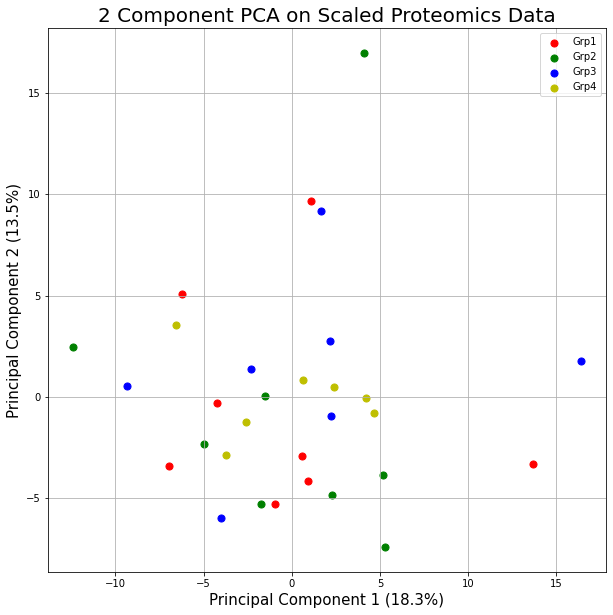

In [36]:
#Plot PCA dataframe
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 (18.3%)', fontsize = 15)
ax.set_ylabel('Principal Component 2 (13.5%)', fontsize = 15)
ax.set_title('2 Component PCA on Scaled Proteomics Data', fontsize = 20)


targets = ['Grp1','Grp2','Grp3','Grp4']
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['index'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [37]:
pca.explained_variance_ratio_

array([0.18382643, 0.13533887])

In [38]:
#Perform 3 component PCA analysis using sklearn
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.head()

,principal component 1,principal component 2,principal component 3
0,-2.613190,-1.213536,-2.884041
1,-3.750709,-2.848774,-1.092235
2,-1.522340,0.060277,-3.642068
3,-4.248429,-0.288393,2.826536
4,-9.330473,0.564663,-0.732385


In [39]:
pca.explained_variance_ratio_

array([0.18382643, 0.13533887, 0.10396335])

In [40]:
#Merge x PCA analysis with y (groups) into a single dataframe
finalDf = pd.concat([principalDf, df2transpose[['index']]], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,principal component 3,index
0,-2.613190,-1.213536,-2.884041,Grp4
1,-3.750709,-2.848774,-1.092235,Grp4
2,-1.522340,0.060277,-3.642068,Grp2
3,-4.248429,-0.288393,2.826536,Grp1
4,-9.330473,0.564663,-0.732385,Grp3


In [41]:
finalDf.columns = ['PC1','PC2','PC3','group']
finalDf

,PC1,PC2,PC3,group
0,-2.613190,-1.213536,-2.884041,Grp4
1,-3.750709,-2.848774,-1.092235,Grp4
2,-1.522340,0.060277,-3.642068,Grp2
3,-4.248429,-0.288393,2.826536,Grp1
4,-9.330473,0.564663,-0.732385,Grp3
5,-2.289294,1.399065,0.906967,Grp3
6,0.932286,-4.146226,-7.068313,Grp1
7,-1.739278,-5.290705,-5.162798,Grp2
8,4.673952,-0.786182,-7.524952,Grp4
9,-6.932597,-3.423351,-1.212417,Grp1


In [43]:
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    principalComponents, x=0, y=1, z=2, color=finalDf['group'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1 (18.4%)', '1': 'PC 2 (13.5%)', '2': 'PC 3 (10.4%)'}
)
fig.show()

## ANOVA by group on normalized data (no imputation)

In [44]:
#Use numpy to log2transform the data
df222 = np.log2(df2) #log2transforms the data
df222 

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp3.5,Grp1.5,Grp2.5,Grp1.6,Grp3.6,Grp2.6,Grp4.5,Grp1.7,Grp2.7,Grp4.6
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2AKB4,7.412212,8.270750,7.796475,7.624483,7.977623,6.986868,7.514451,7.570499,7.998144,8.737072,...,7.043215,7.445710,7.284706,7.847126,7.495981,8.001703,6.719481,7.173329,7.162045,7.552107
A6X935,6.976949,6.895912,7.043404,6.890574,6.693020,7.525672,7.866856,7.813316,7.586003,7.081069,...,7.922199,7.090573,7.143589,6.667635,7.308810,7.059317,7.707872,8.459786,7.417243,6.869728
B2RPV6,7.809007,7.429898,7.291761,7.557566,8.357487,6.980667,7.734146,7.470408,7.414859,7.584970,...,5.404522,7.804849,5.784582,7.866648,7.826163,7.470032,6.741541,6.508065,7.736471,7.417826
E9PV24,6.926610,6.897659,6.636534,6.703556,7.014872,6.657186,7.939925,7.595063,6.905259,7.492008,...,7.012914,6.866675,8.180144,7.454715,7.321742,7.102144,6.723083,7.653867,7.553224,7.455916
E9Q414,7.166955,7.316909,6.998770,7.468337,7.342079,7.237542,7.981001,8.262522,7.574111,7.435419,...,6.529645,7.639860,6.611363,7.438450,7.203568,7.241531,7.160987,7.307933,7.247287,7.191596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9R1P4,7.293771,7.196768,7.556110,7.247220,7.306175,7.661327,7.015311,7.400839,6.966261,6.996429,...,6.191655,6.448686,8.796749,6.918944,7.675834,6.932429,7.801094,7.014799,6.755705,7.534489
Q9Z126,7.429459,7.149187,7.123911,7.196684,7.416222,7.575810,7.890565,7.203484,6.851436,6.657048,...,4.780623,7.452016,7.044724,7.511261,7.788516,7.464648,7.113207,6.414235,7.761017,6.960949
Q9Z1T2,6.977828,7.324002,6.918628,6.886630,7.316675,6.901942,7.534267,7.047288,6.391178,7.197108,...,6.405095,7.430081,7.009488,7.410606,7.088616,7.331549,7.596496,7.001315,7.305912,7.525379


In [45]:
# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df222.reset_index(), id_vars=['Master Protein'], value_vars=['Grp1', 'Grp2', 'Grp3', 'Grp4'])
# replace column names
df_melt.columns = ['index', 'group', 'value']
df_melt

,index,group,value
0,A2AKB4,Grp1,7.624483
1,A6X935,Grp1,6.890574
2,B2RPV6,Grp1,7.557566
3,E9PV24,Grp1,6.703556
4,E9Q414,Grp1,7.468337
...,...,...,...
759,Q9R1P4,Grp4,7.293771
760,Q9Z126,Grp4,7.429459
761,Q9Z1T2,Grp4,6.977828
762,Q9Z2U1,Grp4,7.513637


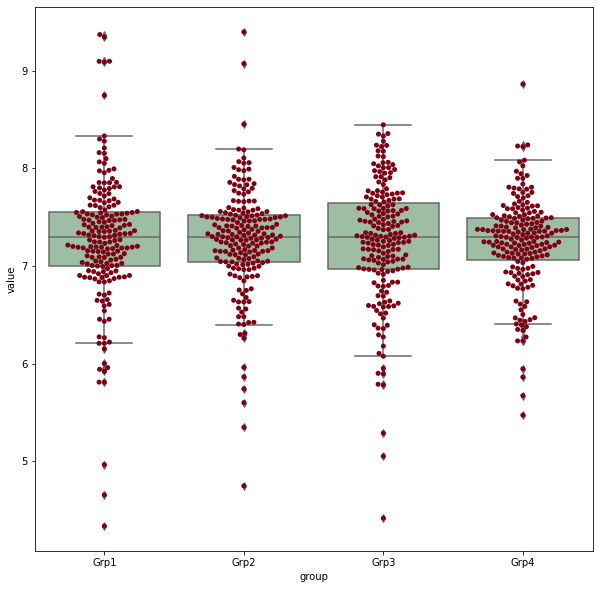

In [46]:
# generate a boxplot to see the data distribution
plt.figure(figsize=(10, 10))
ax = sns.boxplot(x='group', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="group", y="value", data=df_melt, color='#7d0013')
plt.show()

In [47]:
# ANOVA table using bioinfokit v1.0.3 or later 
res = stat()
res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(group)')
res.anova_summary
# output (ANOVA F and p value)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),3.0,0.104985,0.034995,0.103017,0.958291
Residual,760.0,258.174033,0.339703,NaN,NaN


In [48]:
# perform multiple pairwise comparison (Tukey's HSD)
res = stat()
res.tukey_hsd(df=df_melt, res_var='value', xfac_var='group', anova_model='value ~ C(group)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Grp1,Grp2,0.001242,-0.152321,0.154804,0.029440,0.9
1,Grp1,Grp3,0.013367,-0.140195,0.166930,0.316966,0.9
2,Grp1,Grp4,0.029107,-0.124456,0.182669,0.690175,0.9
3,Grp2,Grp3,0.012126,-0.141436,0.165688,0.287526,0.9
4,Grp2,Grp4,0.027865,-0.125697,0.181427,0.660735,0.9
5,Grp3,Grp4,0.015739,-0.137823,0.169301,0.373209,0.9


In [49]:
df2transpose

Master Protein,index,A2AKB4,A6X935,B2RPV6,E9PV24,E9Q414,O08677,O70165,O70362,O70570,...,Q9JJN5,Q9QUM9,Q9QWK4,Q9QXC1,Q9R1P3,Q9R1P4,Q9Z126,Q9Z1T2,Q9Z2U1,Q9Z2W0
0,Grp4,7.412212,6.976949,7.809007,6.926610,7.166955,7.516215,7.617652,6.913495,7.496173,...,7.249311,6.816522,7.362642,7.486458,7.378412,7.293771,7.429459,6.977828,7.513637,6.642242
1,Grp4,8.270750,6.895912,7.429898,6.897659,7.316909,7.250805,7.951272,6.972176,7.406292,...,7.385907,6.553360,7.711038,7.051330,7.523178,7.196768,7.149187,7.324002,7.416577,8.341399
2,Grp2,7.796475,7.043404,7.291761,6.636534,6.998770,7.319731,7.663783,6.894804,7.558886,...,7.331452,6.979505,7.115894,7.572724,7.736381,7.556110,7.123911,6.918628,7.542158,6.529102
3,Grp1,7.624483,6.890574,7.557566,6.703556,7.468337,7.176689,7.674207,6.882313,7.153083,...,7.533813,6.886630,7.301291,7.027749,7.194969,7.247220,7.196684,6.886630,6.944474,7.022951
4,Grp3,7.977623,6.693020,8.357487,7.014872,7.342079,7.265903,7.915661,6.835911,7.196567,...,7.236111,6.829868,7.538994,7.172114,7.168398,7.306175,7.416222,7.316675,6.980413,6.796593
5,Grp3,6.986868,7.525672,6.980667,6.657186,7.237542,7.336327,7.631751,6.877020,6.962272,...,7.155875,7.346578,6.787325,7.220569,7.502974,7.661327,7.575810,6.901942,7.248938,6.820844
6,Grp1,7.514451,7.866856,7.734146,7.939925,7.981001,7.417276,7.567738,6.798861,7.825560,...,7.101798,6.889120,7.213264,7.655307,7.380973,7.015311,7.890565,7.534267,7.117745,6.645879
7,Grp2,7.570499,7.813316,7.470408,7.595063,8.262522,7.301695,8.002214,7.011240,8.054714,...,6.982167,7.156942,7.280893,7.421246,7.074479,7.400839,7.203484,7.047288,7.563209,7.038091
8,Grp4,7.998144,7.586003,7.414859,6.905259,7.574111,8.014334,7.512513,7.646813,6.971899,...,7.464990,7.246797,6.884081,7.840657,6.945263,6.966261,6.851436,6.391178,6.413623,6.654015
9,Grp1,8.737072,7.081069,7.584970,7.492008,7.435419,7.818497,8.092811,6.988280,7.882071,...,7.377292,7.513208,8.094857,7.226542,7.152763,6.996429,6.657048,7.197108,6.899535,7.320710


In [50]:
#Assign unique numbers based upon the index (genotype) column
df2transpose['group'] = df2transpose.groupby(['index']).ngroup()
df2transpose

Master Protein,index,A2AKB4,A6X935,B2RPV6,E9PV24,E9Q414,O08677,O70165,O70362,O70570,...,Q9QUM9,Q9QWK4,Q9QXC1,Q9R1P3,Q9R1P4,Q9Z126,Q9Z1T2,Q9Z2U1,Q9Z2W0,group
0,Grp4,7.412212,6.976949,7.809007,6.926610,7.166955,7.516215,7.617652,6.913495,7.496173,...,6.816522,7.362642,7.486458,7.378412,7.293771,7.429459,6.977828,7.513637,6.642242,3
1,Grp4,8.270750,6.895912,7.429898,6.897659,7.316909,7.250805,7.951272,6.972176,7.406292,...,6.553360,7.711038,7.051330,7.523178,7.196768,7.149187,7.324002,7.416577,8.341399,3
2,Grp2,7.796475,7.043404,7.291761,6.636534,6.998770,7.319731,7.663783,6.894804,7.558886,...,6.979505,7.115894,7.572724,7.736381,7.556110,7.123911,6.918628,7.542158,6.529102,1
3,Grp1,7.624483,6.890574,7.557566,6.703556,7.468337,7.176689,7.674207,6.882313,7.153083,...,6.886630,7.301291,7.027749,7.194969,7.247220,7.196684,6.886630,6.944474,7.022951,0
4,Grp3,7.977623,6.693020,8.357487,7.014872,7.342079,7.265903,7.915661,6.835911,7.196567,...,6.829868,7.538994,7.172114,7.168398,7.306175,7.416222,7.316675,6.980413,6.796593,2
5,Grp3,6.986868,7.525672,6.980667,6.657186,7.237542,7.336327,7.631751,6.877020,6.962272,...,7.346578,6.787325,7.220569,7.502974,7.661327,7.575810,6.901942,7.248938,6.820844,2
6,Grp1,7.514451,7.866856,7.734146,7.939925,7.981001,7.417276,7.567738,6.798861,7.825560,...,6.889120,7.213264,7.655307,7.380973,7.015311,7.890565,7.534267,7.117745,6.645879,0
7,Grp2,7.570499,7.813316,7.470408,7.595063,8.262522,7.301695,8.002214,7.011240,8.054714,...,7.156942,7.280893,7.421246,7.074479,7.400839,7.203484,7.047288,7.563209,7.038091,1
8,Grp4,7.998144,7.586003,7.414859,6.905259,7.574111,8.014334,7.512513,7.646813,6.971899,...,7.246797,6.884081,7.840657,6.945263,6.966261,6.851436,6.391178,6.413623,6.654015,3
9,Grp1,8.737072,7.081069,7.584970,7.492008,7.435419,7.818497,8.092811,6.988280,7.882071,...,7.513208,8.094857,7.226542,7.152763,6.996429,6.657048,7.197108,6.899535,7.320710,0


In [51]:
#set the index
dfidgroups = df2transpose.set_index('index')
dfidgroups

Master Protein,A2AKB4,A6X935,B2RPV6,E9PV24,E9Q414,O08677,O70165,O70362,O70570,O88200,...,Q9QUM9,Q9QWK4,Q9QXC1,Q9R1P3,Q9R1P4,Q9Z126,Q9Z1T2,Q9Z2U1,Q9Z2W0,group
index,,,,,,,,,,,,,,,,,,,,,
Grp4,7.412212,6.976949,7.809007,6.926610,7.166955,7.516215,7.617652,6.913495,7.496173,7.223850,...,6.816522,7.362642,7.486458,7.378412,7.293771,7.429459,6.977828,7.513637,6.642242,3
Grp4,8.270750,6.895912,7.429898,6.897659,7.316909,7.250805,7.951272,6.972176,7.406292,6.895592,...,6.553360,7.711038,7.051330,7.523178,7.196768,7.149187,7.324002,7.416577,8.341399,3
Grp2,7.796475,7.043404,7.291761,6.636534,6.998770,7.319731,7.663783,6.894804,7.558886,6.299643,...,6.979505,7.115894,7.572724,7.736381,7.556110,7.123911,6.918628,7.542158,6.529102,1
Grp1,7.624483,6.890574,7.557566,6.703556,7.468337,7.176689,7.674207,6.882313,7.153083,7.037497,...,6.886630,7.301291,7.027749,7.194969,7.247220,7.196684,6.886630,6.944474,7.022951,0
Grp3,7.977623,6.693020,8.357487,7.014872,7.342079,7.265903,7.915661,6.835911,7.196567,6.467839,...,6.829868,7.538994,7.172114,7.168398,7.306175,7.416222,7.316675,6.980413,6.796593,2
Grp3,6.986868,7.525672,6.980667,6.657186,7.237542,7.336327,7.631751,6.877020,6.962272,6.851952,...,7.346578,6.787325,7.220569,7.502974,7.661327,7.575810,6.901942,7.248938,6.820844,2
Grp1,7.514451,7.866856,7.734146,7.939925,7.981001,7.417276,7.567738,6.798861,7.825560,7.222364,...,6.889120,7.213264,7.655307,7.380973,7.015311,7.890565,7.534267,7.117745,6.645879,0
Grp2,7.570499,7.813316,7.470408,7.595063,8.262522,7.301695,8.002214,7.011240,8.054714,6.739799,...,7.156942,7.280893,7.421246,7.074479,7.400839,7.203484,7.047288,7.563209,7.038091,1
Grp4,7.998144,7.586003,7.414859,6.905259,7.574111,8.014334,7.512513,7.646813,6.971899,6.507052,...,7.246797,6.884081,7.840657,6.945263,6.966261,6.851436,6.391178,6.413623,6.654015,3


Text(0.5, 1.3, 'Hierarchical Clustering of Mouse Serum Proteomics - No imputation')

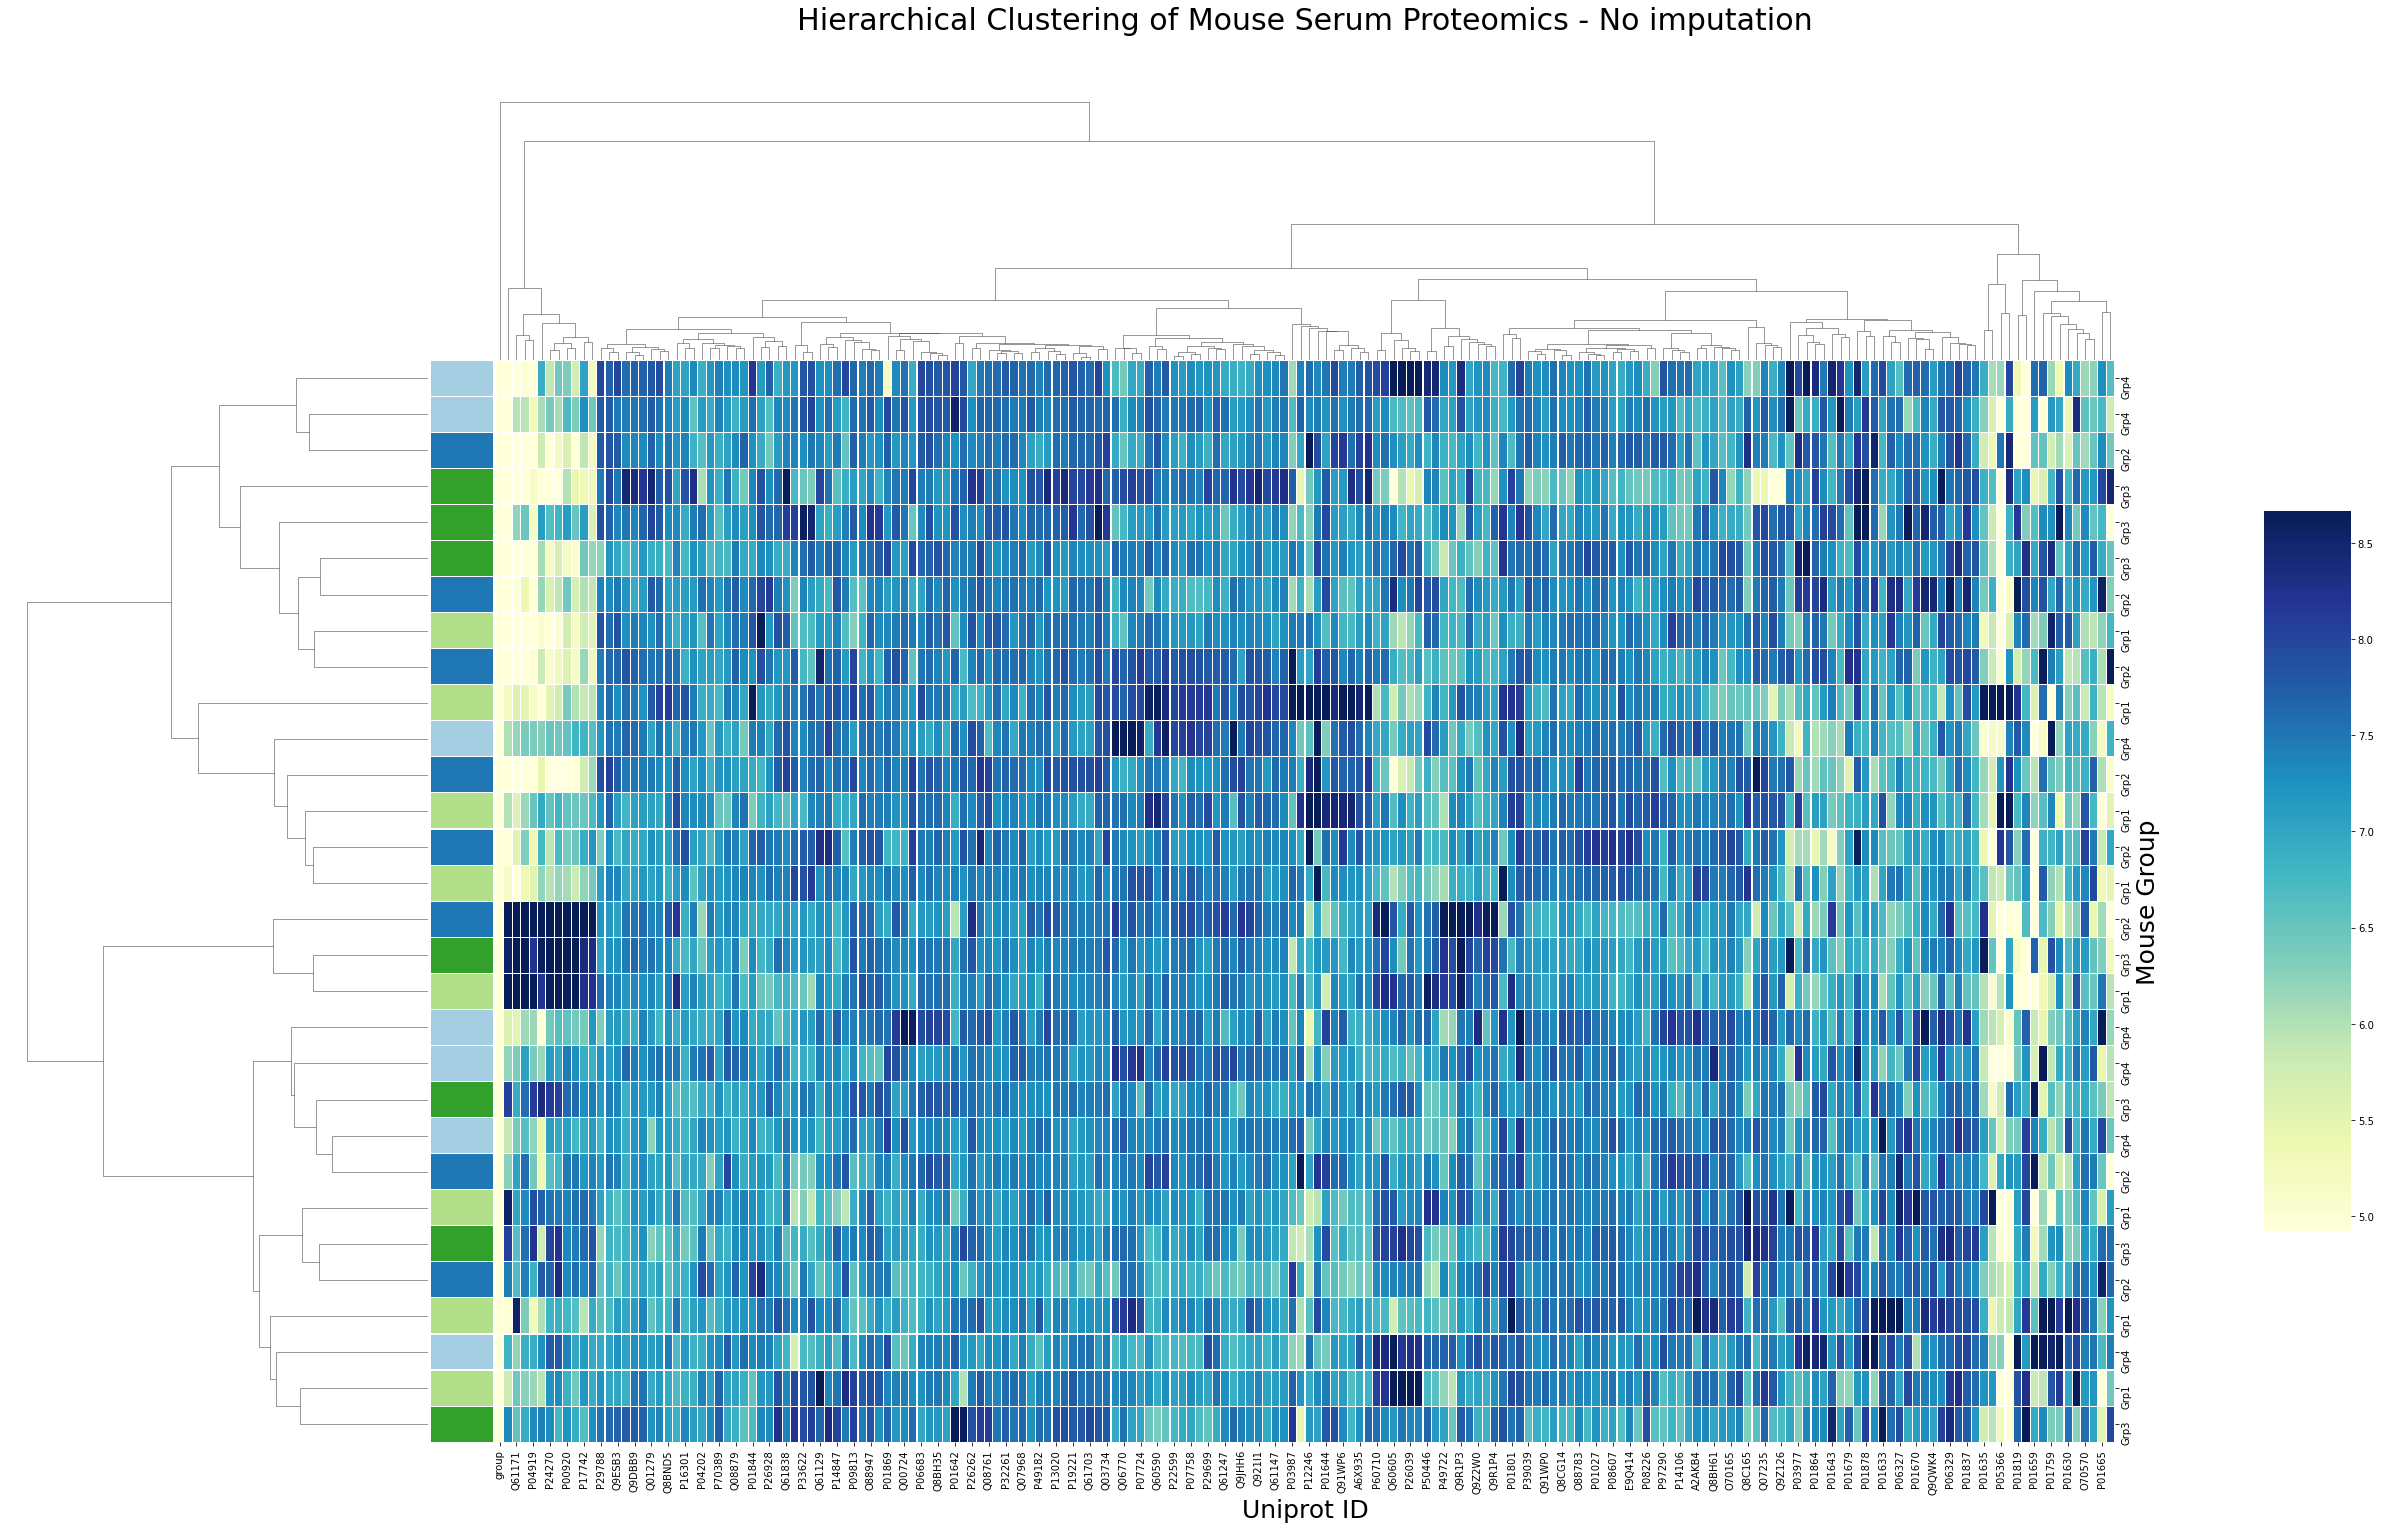

In [52]:
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('Paired', len(dfidgroups.group.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(dfidgroups.group.unique(), network_pal))

#get the series of all of the categories
networks = dfidgroups.group

#map the colors to the series. Now we have a list of colors the same
#length as our dataframe, where unique values are mapped to the same color
network_colors = pd.Series(networks).map(network_lut)

#plot the heatmap with the 16S and ITS categories with the network colors
#defined by Source column
g = sns.clustermap(dfidgroups, method = 'ward', robust = True, figsize=(30,20), cmap = "YlGnBu", linewidths=0.1, cbar_pos=(1.05, .2, .04, .5), row_colors=[network_colors])
ax = g.ax_heatmap
ax.set_xlabel("Uniprot ID", fontsize = 25)
ax.set_ylabel("Mouse Group", fontsize = 25)
ax.set_title('Hierarchical Clustering of Mouse Serum Proteomics - No imputation', y=1.3, fontsize = 30)

In [53]:
dfidgroupssorted = dfidgroups.sort_index(axis=0, level=None, ascending=True, inplace=False, kind='quicksort', na_position='last', sort_remaining=True, ignore_index=False, key=None)

In [54]:
dfidgroupssorted

Master Protein,A2AKB4,A6X935,B2RPV6,E9PV24,E9Q414,O08677,O70165,O70362,O70570,O88200,...,Q9QUM9,Q9QWK4,Q9QXC1,Q9R1P3,Q9R1P4,Q9Z126,Q9Z1T2,Q9Z2U1,Q9Z2W0,group
index,,,,,,,,,,,,,,,,,,,,,
Grp1,8.043423,7.238900,7.574874,7.124286,7.796548,7.498855,7.666209,6.984277,7.337877,7.249154,...,6.831928,7.241227,7.110804,6.911188,6.821414,6.797571,7.376281,6.864427,7.086902,0
Grp1,7.445710,7.090573,7.804849,6.866675,7.639860,7.390049,7.202097,7.274599,6.016353,7.519063,...,7.075814,6.949479,7.264634,6.746993,6.448686,7.452016,7.430081,7.606334,6.941593,0
Grp1,6.707799,7.490936,7.350262,8.345658,6.959792,7.217239,7.140207,7.181314,6.611510,7.036246,...,7.643092,6.461086,7.216668,8.595749,7.794026,7.688599,6.707885,7.923957,7.406152,0
Grp1,8.737072,7.081069,7.584970,7.492008,7.435419,7.818497,8.092811,6.988280,7.882071,6.657444,...,7.513208,8.094857,7.226542,7.152763,6.996429,6.657048,7.197108,6.899535,7.320710,0
Grp1,7.514451,7.866856,7.734146,7.939925,7.981001,7.417276,7.567738,6.798861,7.825560,7.222364,...,6.889120,7.213264,7.655307,7.380973,7.015311,7.890565,7.534267,7.117745,6.645879,0
Grp1,7.847126,6.667635,7.866648,7.454715,7.438450,7.037719,7.561179,6.846366,7.409453,7.390806,...,7.375977,7.823325,7.068098,7.946943,6.918944,7.511261,7.410606,7.749681,6.999942,0
Grp1,7.173329,8.459786,6.508065,7.653867,7.307933,7.848304,6.517782,7.559728,5.800398,6.928943,...,7.156007,6.774468,8.225215,7.837948,7.014799,6.414235,7.001315,7.485956,7.410904,0
Grp1,7.624483,6.890574,7.557566,6.703556,7.468337,7.176689,7.674207,6.882313,7.153083,7.037497,...,6.886630,7.301291,7.027749,7.194969,7.247220,7.196684,6.886630,6.944474,7.022951,0
Grp2,7.162045,7.417243,7.736471,7.553224,7.247287,7.856160,6.781011,7.843369,6.639134,7.096773,...,6.763704,6.855013,7.730362,6.606430,6.755705,7.761017,7.305912,7.246773,7.096057,1


Text(0.5, 1.3, 'Heatmap of Mouse Serum Proteomics - No imputation')

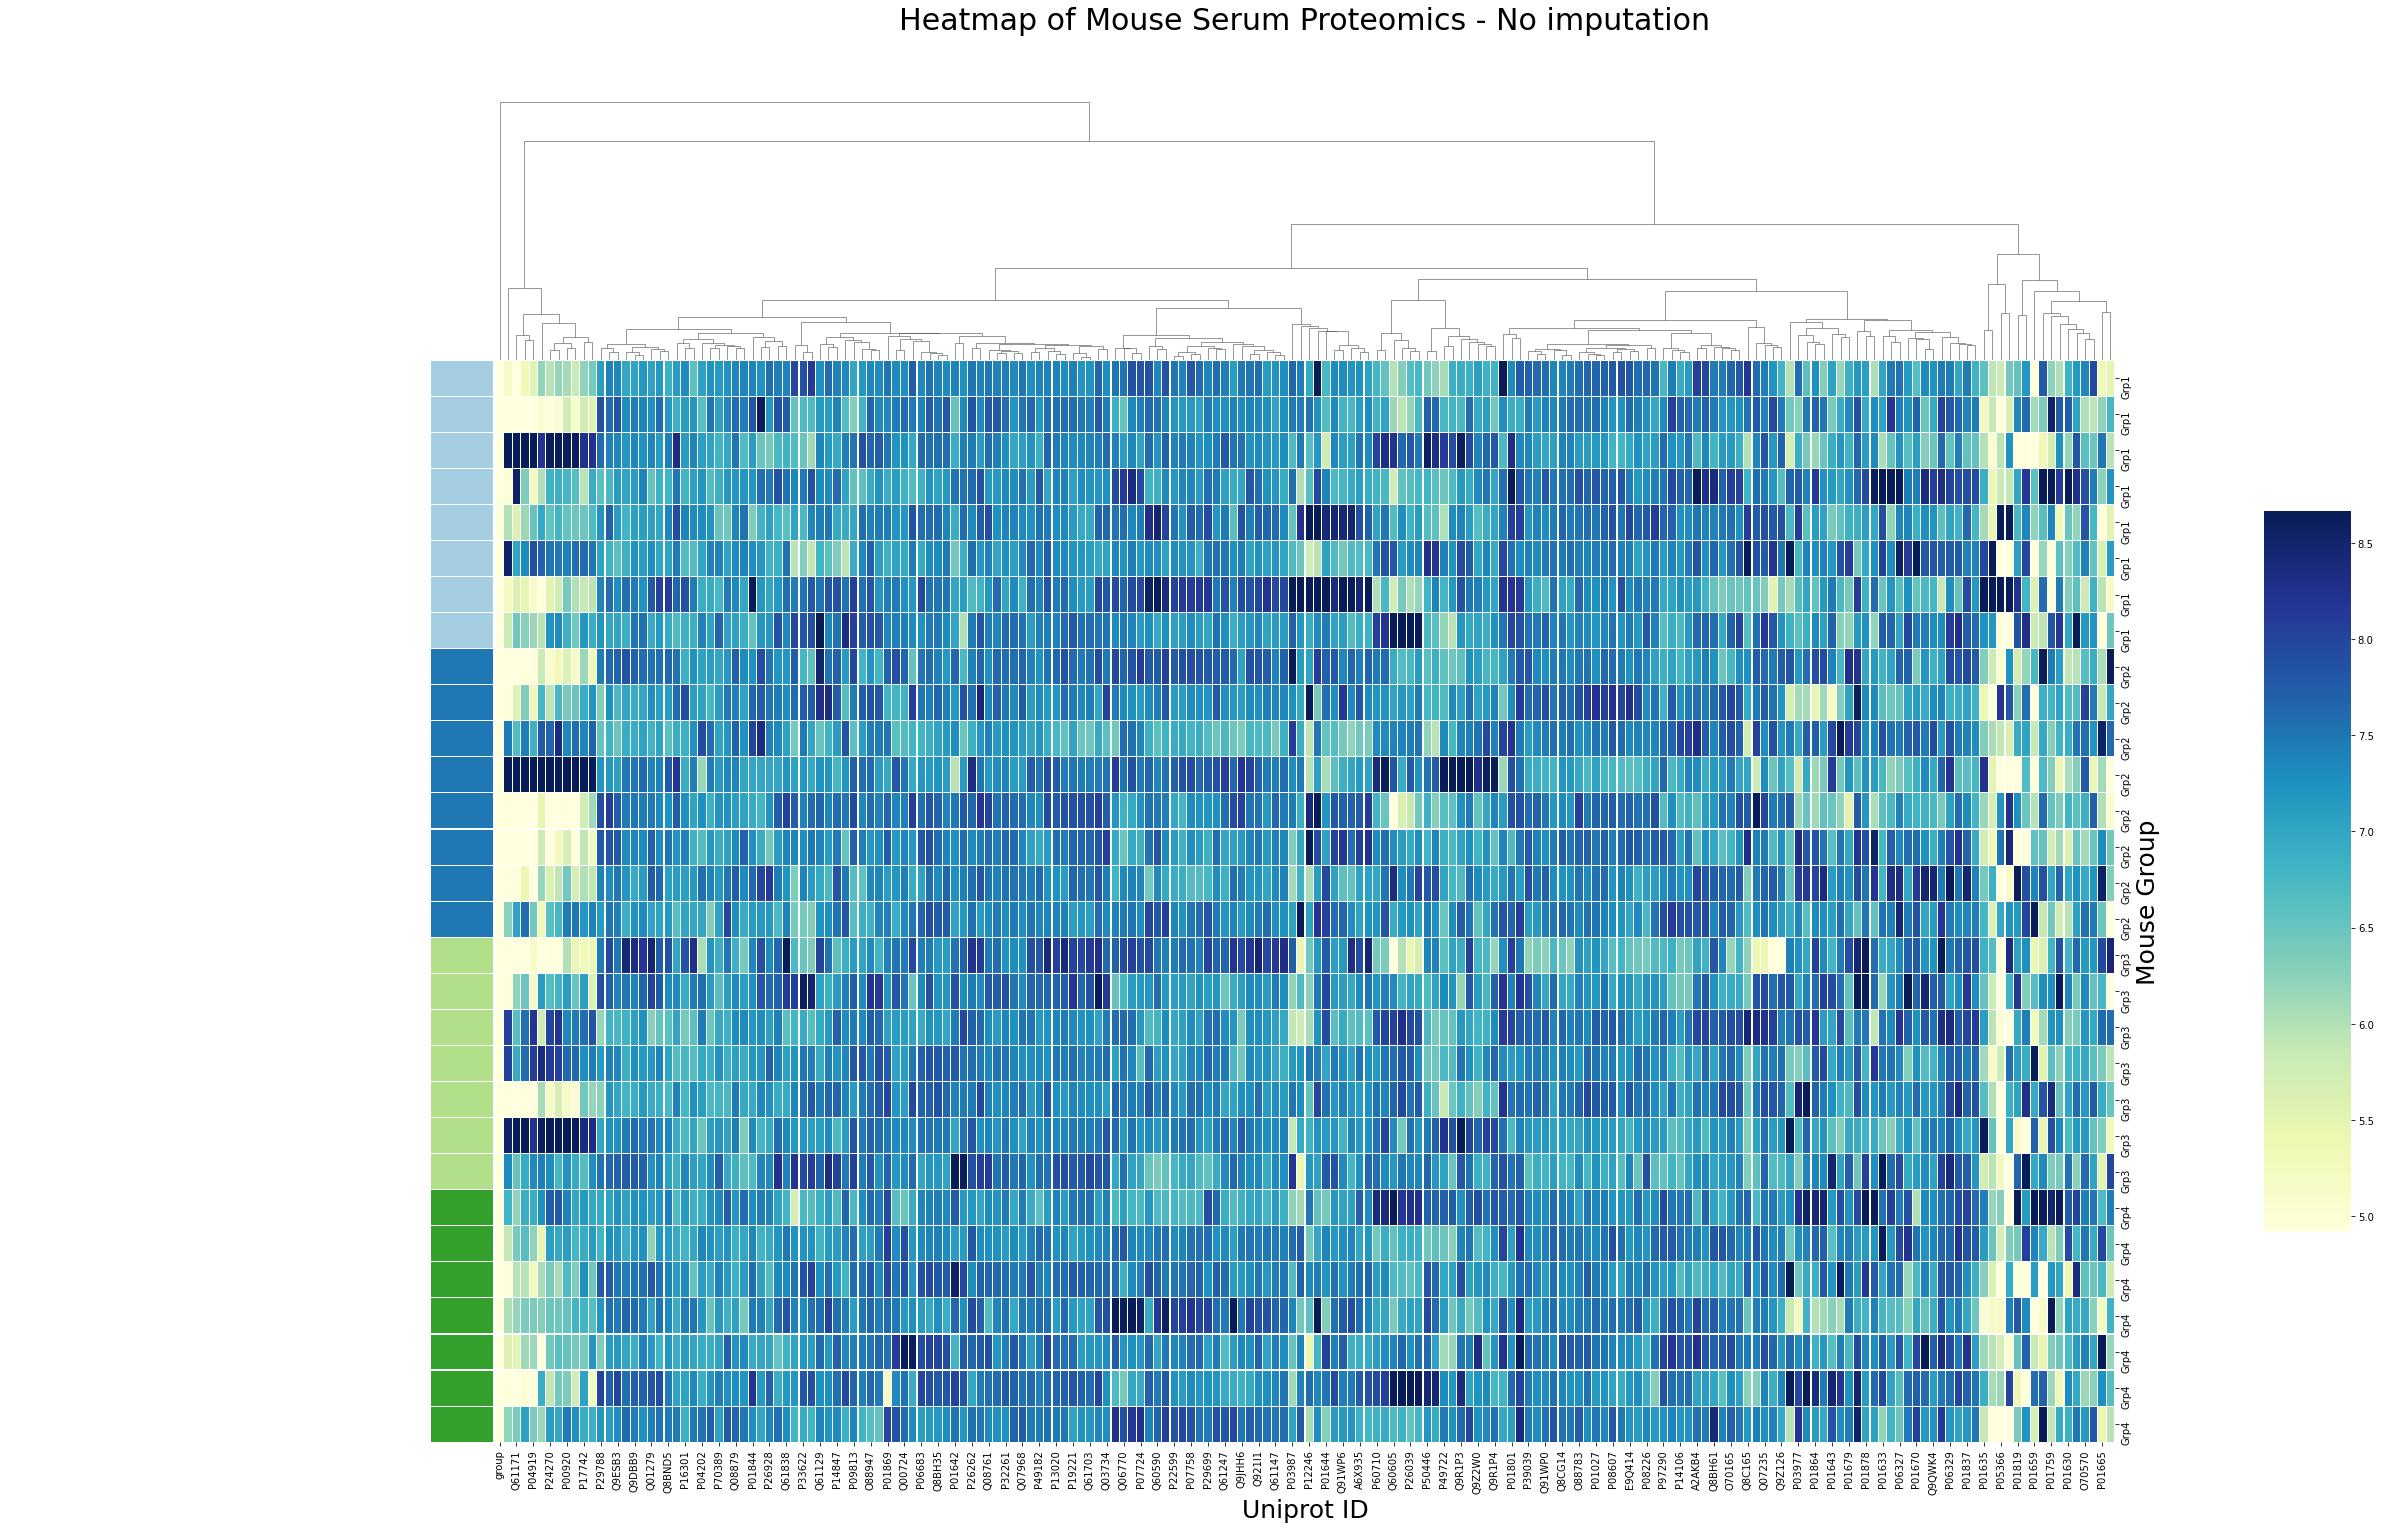

In [55]:
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('Paired', len(dfidgroupssorted.group.unique()))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(dfidgroupssorted.group.unique(), network_pal))

#get the series of all of the categories
networks = dfidgroupssorted.group

#map the colors to the series. Now we have a list of colors the same
#length as our dataframe, where unique values are mapped to the same color
network_colors = pd.Series(networks).map(network_lut)

#plot the heatmap with the 16S and ITS categories with the network colors
#defined by Source column
g = sns.clustermap(dfidgroupssorted, method = 'ward', robust = True, figsize=(30,20), cmap = "YlGnBu", row_cluster=False, linewidths=0.1, cbar_pos=(1.05, .2, .04, .5), row_colors=[network_colors])
ax = g.ax_heatmap
ax.set_xlabel("Uniprot ID", fontsize = 25)
ax.set_ylabel("Mouse Group", fontsize = 25)
ax.set_title('Heatmap of Mouse Serum Proteomics - No imputation', y=1.3, fontsize = 30)

In [56]:
dfid = dfidgroupssorted.transpose()

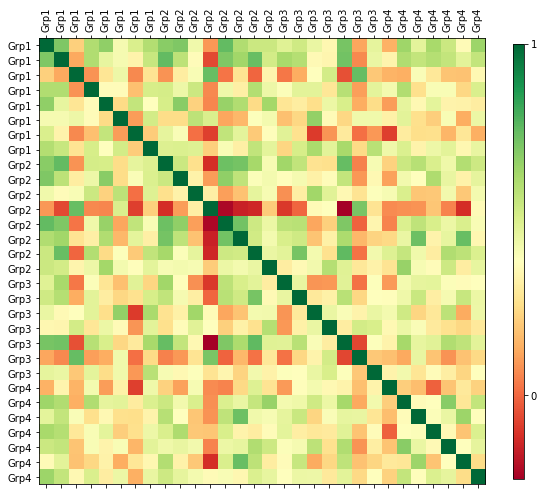

In [57]:
plot_corr(dfid)

## Binary comparisons Grp2 vs Grp1

In [23]:
# load data file
Normalized_df2 = pd.read_excel (r'.\Normalized_df_named.xlsx', index_col=0)
Normalized_df2

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp3.5,Grp1.5,Grp2.5,Grp1.6,Grp3.6,Grp2.6,Grp4.5,Grp1.7,Grp2.7,Grp4.6
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,131.892175,174.334036,155.924749,230.260917,180.515772,256.302364,105.381750,144.340212,143.215590,187.676833
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.521731,174.340913,73.794377,159.309273,121.617649,120.716211,129.221329,137.379367,156.183798,157.744492
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,242.560155,136.293545,141.395158,101.661909,158.551723,133.372491,209.074300,352.086494,170.927823,116.948371
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,42.356801,223.611283,55.122966,233.397974,226.939385,177.297909,107.005493,91.017060,213.260267,170.996842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,27.485954,175.097667,132.030212,182.437801,221.093967,176.637508,138.448641,85.285878,216.919647,124.581726
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,84.747272,172.455628,128.844580,170.143231,136.108771,161.070582,193.541120,128.116747,158.233635,184.231892
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#Import protein names from head dataset for reference - we will use this later to add annotation to the Master Protein list
proteinlist = pd.read_excel (r'./proteinlist.xlsx', index_col=0) 

#View dataframe
proteinlist

,Proteins
Master Protein,
E9Q414,Apob
P01027,C3
Q61838,Pzp
P11276,Fn1
P01029,C4b
...,...
G5E861,Sclt1
Q5RI75,Rasef
P06151,Ldha


In [26]:
Normalized_df2

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp3.5,Grp1.5,Grp2.5,Grp1.6,Grp3.6,Grp2.6,Grp4.5,Grp1.7,Grp2.7,Grp4.6
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,131.892175,174.334036,155.924749,230.260917,180.515772,256.302364,105.381750,144.340212,143.215590,187.676833
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.521731,174.340913,73.794377,159.309273,121.617649,120.716211,129.221329,137.379367,156.183798,157.744492
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,242.560155,136.293545,141.395158,101.661909,158.551723,133.372491,209.074300,352.086494,170.927823,116.948371
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,42.356801,223.611283,55.122966,233.397974,226.939385,177.297909,107.005493,91.017060,213.260267,170.996842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,27.485954,175.097667,132.030212,182.437801,221.093967,176.637508,138.448641,85.285878,216.919647,124.581726
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,84.747272,172.455628,128.844580,170.143231,136.108771,161.070582,193.541120,128.116747,158.233635,184.231892
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
Grp1 = ['Grp1', 'Grp1.1', 'Grp1.2', 'Grp1.3', 'Grp1.4', 'Grp1.5', 'Grp1.6', 'Grp1.7']
Grp2 = ['Grp2', 'Grp2.1','Grp2.2', 'Grp2.3', 'Grp2.4', 'Grp2.5', 'Grp2.6', 'Grp2.7']

In [28]:
Grp1_df = Normalized_df2[Grp1]
Grp2_df = Normalized_df2[Grp2]

In [48]:
Grp1Grp2 = TwoCategoryMaster(Normalized_df2,Grp2_df,Grp1_df,"Grp2","Grp1")
Grp1Grp2

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp1.7,Grp2.7,Grp4.6,ttest_pvalue,Grp2 Mean,Grp1 Mean,Fold Change(Grp2/Grp1),Log2(Fold Change),-Log(P-value),Grp2/Grp1 pi score
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,0.185454,209.360514,123.494769,1.695299,0.761539,0.731764,0.557267
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,144.340212,143.215590,187.676833,0.496664,184.479985,215.520149,0.855976,-0.224358,0.303937,-0.068191
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137.379367,156.183798,157.744492,0.940246,146.543993,149.416833,0.980773,-0.028009,0.026758,-0.000749
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,352.086494,170.927823,116.948371,0.905481,171.705455,176.057515,0.975280,-0.036111,0.043121,-0.001557
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,91.017060,213.260267,170.996842,0.692432,202.825959,186.895975,1.085234,0.118007,0.159623,0.018837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,85.285878,216.919647,124.581726,0.753324,162.629019,155.659760,1.044772,0.063189,0.123018,0.007773
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,128.116747,158.233635,184.231892,0.966252,148.372188,148.979068,0.995926,-0.005889,0.014910,-0.000088
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,NaN,0.010595,176.808028,132.786425,1.331522,0.413076,1.974881,0.815776


In [55]:
#Annotate the file with protein names
Grp1Grp2a = pd.merge(Grp1Grp2, proteinlist, left_index=True, right_index=True)
Grp1Grp2a

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp2 Mean,Grp1 Mean,Fold Change(Grp2/Grp1),Log2(Fold Change),-Log(P-value),Grp2/Grp1 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,0.185454,209.360514,123.494769,1.695299,0.761539,0.731764,0.557267,Ptprf
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,143.215590,187.676833,0.496664,184.479985,215.520149,0.855976,-0.224358,0.303937,-0.068191,Frmpd1
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,156.183798,157.744492,0.940246,146.543993,149.416833,0.980773,-0.028009,0.026758,-0.000749,Lrriq4
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,170.927823,116.948371,0.905481,171.705455,176.057515,0.975280,-0.036111,0.043121,-0.001557,Itih4
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,213.260267,170.996842,0.692432,202.825959,186.895975,1.085234,0.118007,0.159623,0.018837,Mmrn1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,216.919647,124.581726,0.753324,162.629019,155.659760,1.044772,0.063189,0.123018,0.007773,Pf4
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,158.233635,184.231892,0.966252,148.372188,148.979068,0.995926,-0.005889,0.014910,-0.000088,Thbs4
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,0.010595,176.808028,132.786425,1.331522,0.413076,1.974881,0.815776,Psma7


In [49]:
top10 = Normalized_df2['Grp2/Grp1 pi score'].nlargest(10)
low10 = Normalized_df2['Grp2/Grp1 pi score'].nsmallest(10)

top10df = Normalized_df2[Normalized_df2['Grp2/Grp1 pi score'].isin(top10)]
low10df = Normalized_df2[Normalized_df2['Grp2/Grp1 pi score'].isin(low10)]

In [50]:
#Annotate the file with protein names
top10a = pd.merge(top10, proteinlist, left_index=True, right_index=True)
top10a

,Grp2/Grp1 pi score,Proteins
Master Protein,,
Q99KG3,2.459405,Rbm10
P04945,1.262467,Ig kappa chain V-VI region NQ2-6.1 OS
P01665,1.115754,Ig kappa chain V-III region PC 7043 OS
P01659,0.934073,Ig kappa chain V-III region TEPC 124 OS
Q9Z2U0,0.815776,Psma7
Q61879,0.584559,Myh10
A2A8L5,0.557267,Ptprf
Q3TTY5,0.487375,Krt2
P19096,0.409091,Fasn


In [51]:
#Subset out the significant proteins to a new dataframe
df_sign= Normalized_df2[(abs(Normalized_df2['Grp2/Grp1 pi score']) > (1))]

In [52]:
#Annotate the file with protein names
df_signa = pd.merge(df_sign, proteinlist, left_index=True, right_index=True)
df_signa

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp2 Mean,Grp1 Mean,Fold Change(Grp2/Grp1),Log2(Fold Change),-Log(P-value),Grp2/Grp1 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
P01636,90.820622,61.595531,48.571145,145.625856,61.943643,36.691155,44.117398,30.691833,36.191533,42.862762,...,56.255916,29.527281,0.295320,57.309945,629.790954,0.090998,-3.458016,0.529707,-1.831735,Ig kappa chain V-V region MOPC 149 OS
P01665,251.110437,1429.892015,89.398529,25.261684,198.061900,82.855226,25.933110,57.224132,37.532370,76.308725,...,65.718073,43.763927,0.121935,157.238964,67.457362,2.330939,1.220911,0.913870,1.115754,Ig kappa chain V-III region PC 7043 OS
P04945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,133.484573,64.997420,0.158092,282.284292,94.685370,2.981287,1.575935,0.801091,1.262467,Ig kappa chain V-VI region NQ2-6.1 OS
P05366,51.074413,51.267050,124.883506,31.300224,33.221011,55.301783,1331.141477,289.771059,35.311646,56.044089,...,33.785134,22.009415,0.259546,108.526748,463.038390,0.234380,-2.093081,0.585786,-1.226098,Saa1
Q99KG3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.180245,551.617813,0.384513,3275.311449,53.907637,60.757837,5.924999,0.415090,2.459405,Rbm10


In [53]:
#Export dataframe to csv with index
df_signa.to_csv(r'./grp21pi.csv')

In [93]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=Grp1Grp2a, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="Proteins", lfc_thr=(.5, .5), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)

AssertionError: either significant or non-significant genes are missing; try to change lfc_thr or pv_thr to include both significant and non-significant genes

In [65]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp2')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp1')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

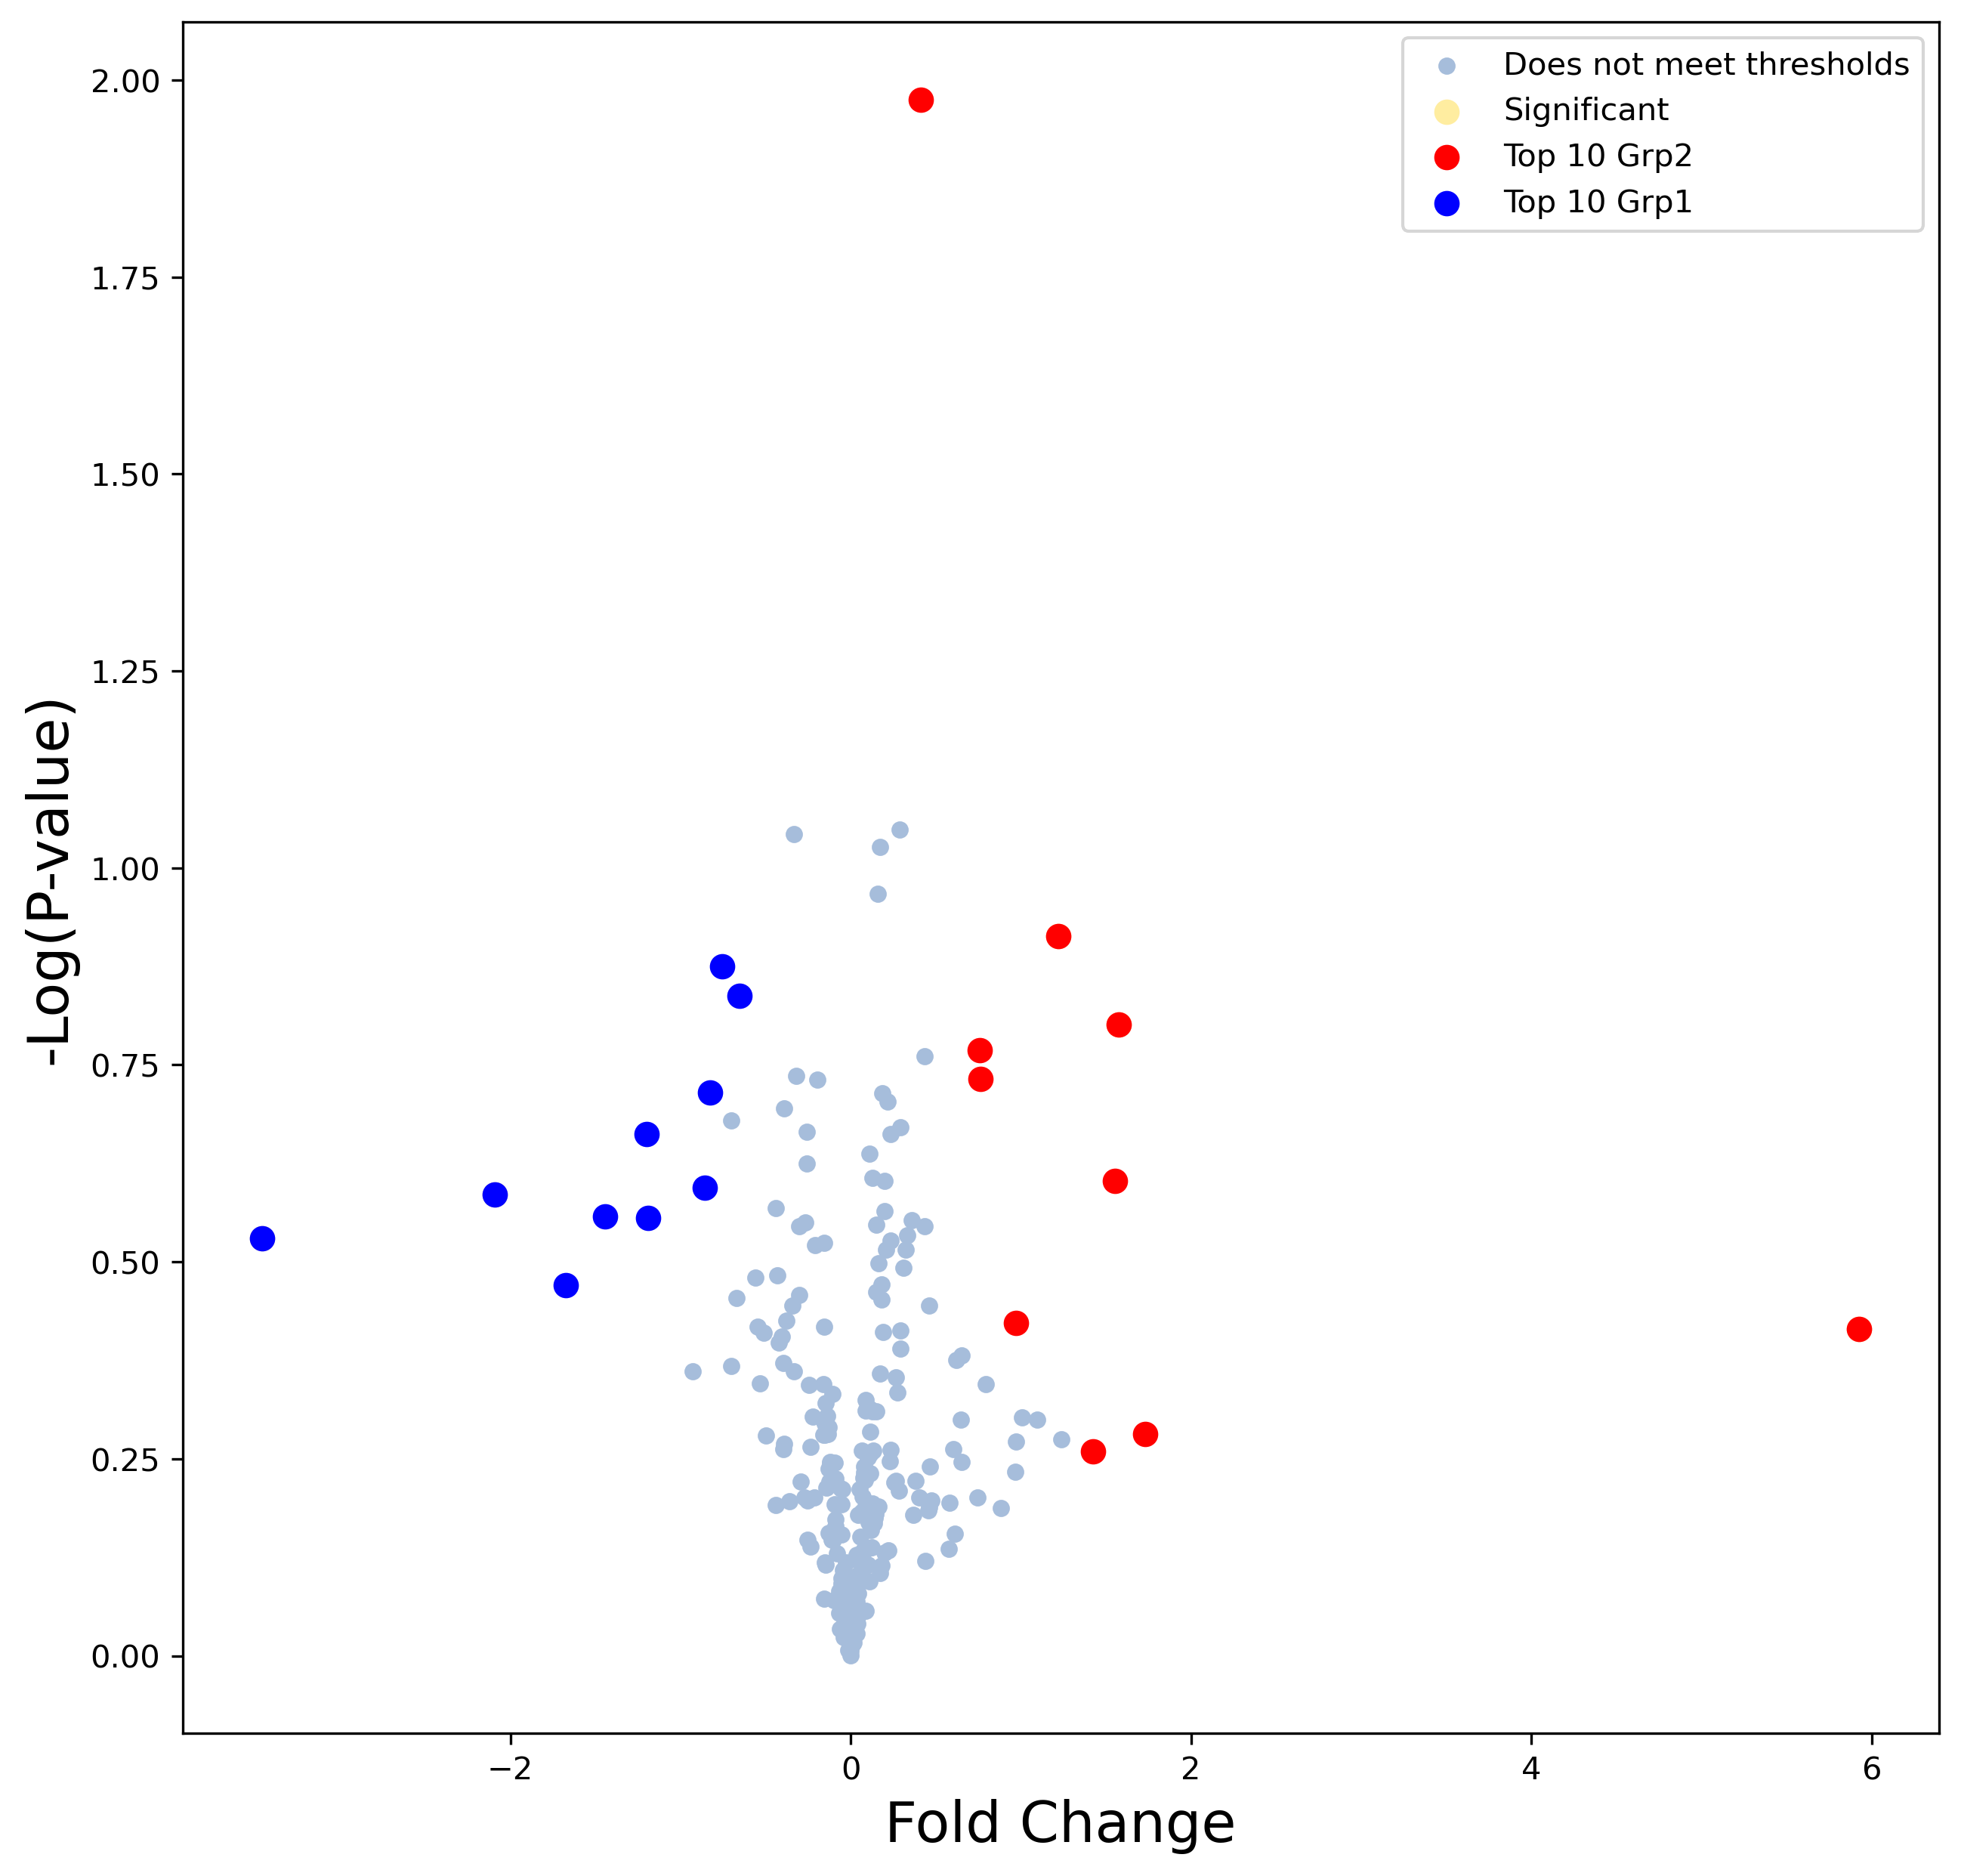

In [66]:
volcanotop10(Normalized_df2,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Volcano_Plot_nooutlier.pdf')

## Binary comparisons Grp4 vs Grp3

In [67]:
# load data file
Normalized_df2 = pd.read_excel (r'./Normalized_df_named.xlsx', index_col=0)
Normalized_df2.head()


,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp3.5,Grp1.5,Grp2.5,Grp1.6,Grp3.6,Grp2.6,Grp4.5,Grp1.7,Grp2.7,Grp4.6
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,131.892175,174.334036,155.924749,230.260917,180.515772,256.302364,105.381750,144.340212,143.215590,187.676833
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.521731,174.340913,73.794377,159.309273,121.617649,120.716211,129.221329,137.379367,156.183798,157.744492
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,242.560155,136.293545,141.395158,101.661909,158.551723,133.372491,209.074300,352.086494,170.927823,116.948371
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,42.356801,223.611283,55.122966,233.397974,226.939385,177.297909,107.005493,91.017060,213.260267,170.996842


In [68]:
Grp3 = ['Grp3', 'Grp3.1', 'Grp3.2', 'Grp3.3', 'Grp3.4', 'Grp3.5', 'Grp3.6']
Grp4 = ['Grp4', 'Grp4.1','Grp4.2', 'Grp4.3', 'Grp4.4', 'Grp4.5', 'Grp4.6']

In [69]:
Grp3_df = Normalized_df2[Grp3]
Grp4_df = Normalized_df2[Grp4]

In [70]:
Grp3Grp4 = TwoCategoryMaster(Normalized_df2,Grp4_df,Grp3_df,"Grp4","Grp3")
Grp3Grp4

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp1.7,Grp2.7,Grp4.6,ttest_pvalue,Grp4 Mean,Grp3 Mean,Fold Change(Grp4/Grp3),Log2(Fold Change),-Log(P-value),Grp4/Grp3 pi score
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,0.540712,147.047929,123.903289,1.186796,0.247072,0.267034,0.065977
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,144.340212,143.215590,187.676833,0.711374,180.559471,167.746163,1.076385,0.106194,0.147902,0.015706
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137.379367,156.183798,157.744492,0.087612,144.578043,99.691515,1.450254,0.536306,1.057436,0.567109
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,352.086494,170.927823,116.948371,0.800974,166.359447,160.354747,1.037446,0.053037,0.096382,0.005112
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,91.017060,213.260267,170.996842,0.846760,153.090170,161.007474,0.950826,-0.072746,0.072240,-0.005255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,85.285878,216.919647,124.581726,0.957472,150.063136,151.571346,0.990050,-0.014427,0.018874,-0.000272
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,128.116747,158.233635,184.231892,0.087690,147.516709,114.471862,1.288672,0.365885,1.057050,0.386759
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,NaN,0.582068,154.129958,172.306171,0.894512,-0.160827,0.235026,-0.037799


In [71]:
#Annotate the file with protein names
Grp3Grp4a = pd.merge(Grp3Grp4, proteinlist, left_index=True, right_index=True)
Grp3Grp4a

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp4 Mean,Grp3 Mean,Fold Change(Grp4/Grp3),Log2(Fold Change),-Log(P-value),Grp4/Grp3 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,0.540712,147.047929,123.903289,1.186796,0.247072,0.267034,0.065977,Ptprf
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,143.215590,187.676833,0.711374,180.559471,167.746163,1.076385,0.106194,0.147902,0.015706,Frmpd1
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,156.183798,157.744492,0.087612,144.578043,99.691515,1.450254,0.536306,1.057436,0.567109,Lrriq4
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,170.927823,116.948371,0.800974,166.359447,160.354747,1.037446,0.053037,0.096382,0.005112,Itih4
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,213.260267,170.996842,0.846760,153.090170,161.007474,0.950826,-0.072746,0.072240,-0.005255,Mmrn1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,216.919647,124.581726,0.957472,150.063136,151.571346,0.990050,-0.014427,0.018874,-0.000272,Pf4
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,158.233635,184.231892,0.087690,147.516709,114.471862,1.288672,0.365885,1.057050,0.386759,Thbs4
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,0.582068,154.129958,172.306171,0.894512,-0.160827,0.235026,-0.037799,Psma7


In [72]:
top10 = Normalized_df2['Grp4/Grp3 pi score'].nlargest(10)
low10 = Normalized_df2['Grp4/Grp3 pi score'].nsmallest(10)

top10df = Normalized_df2[Normalized_df2['Grp4/Grp3 pi score'].isin(top10)]
low10df = Normalized_df2[Normalized_df2['Grp4/Grp3 pi score'].isin(low10)]

In [73]:
#Annotate the file with protein names
top10a = pd.merge(top10, proteinlist, left_index=True, right_index=True)
top10a

,Grp4/Grp3 pi score,Proteins
Master Protein,,
Q99KG3,2.884814,Rbm10
P14106,1.994603,C1qb
Q02105,1.451580,C1qc
Q91ZX7,0.996624,Lrp1
P97290,0.979293,Serping1
P98086,0.964091,C1qa
P02762,0.955329,Mup6
Q80YC5,0.856625,F12
P50446,0.689211,Krt6a


In [74]:
#Subset out the significant proteins to a new dataframe
df_sign= Normalized_df2[(abs(Normalized_df2['Grp4/Grp3 pi score']) > (1))]

In [75]:
#Annotate the file with protein names
df_signa = pd.merge(df_sign, proteinlist, left_index=True, right_index=True)
df_signa

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp4 Mean,Grp3 Mean,Fold Change(Grp4/Grp3),Log2(Fold Change),-Log(P-value),Grp4/Grp3 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
P04919,75.296091,70.603411,85.800835,71.205356,299.166295,275.106510,90.908715,41.086979,81.410983,38.463313,...,31.540202,82.435347,0.110858,69.707629,162.510748,0.428942,-1.221147,0.955233,-1.166480,Slc4a1
P14106,186.899807,225.507999,237.072807,104.947098,134.840812,100.579928,153.421234,150.152814,204.633184,205.238811,...,109.076999,145.128962,0.002474,175.030003,102.982848,1.699603,0.765198,2.606649,1.994603,C1qb
P18525,75.001101,22.144622,18.750215,37.433374,40.243840,327.513955,33.744373,33.670155,50.484841,100.145708,...,NaN,NaN,0.087503,49.210188,285.824532,0.172169,-2.538101,1.057979,-2.685256,Ig heavy chain V region 5-84 OS
P23492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,147.317760,147.003498,0.078113,139.574620,286.272657,0.487558,-1.036353,1.107277,-1.147530,Pnp
P31725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,146.847096,62.635382,0.116600,98.618519,227.803175,0.432911,-1.207857,0.933301,-1.127295,S100a9
P49222,58.239684,48.444875,76.817688,56.187511,266.806893,263.471904,63.763555,28.951902,65.494729,32.131206,...,9.505040,74.528812,0.124108,55.307139,156.403695,0.353618,-1.499737,0.906201,-1.359063,Epb42
P80315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.933069,41.579232,0.027887,89.612730,250.697577,0.357454,-1.484172,1.554601,-2.307296,Cct4
Q02105,215.865454,288.418406,275.809452,119.795429,171.805499,119.237487,206.361980,215.038113,232.305946,249.071660,...,131.522627,166.401182,0.006668,202.626151,127.608820,1.587869,0.667092,2.175980,1.451580,C1qc
Q3TTY5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.518113,19.085549,0.302092,51.381786,381.465291,0.134696,-2.892223,0.519861,-1.503555,Krt2


In [76]:
#Export dataframe to csv with index
df_signa.to_csv(r'./grp43pi.csv')

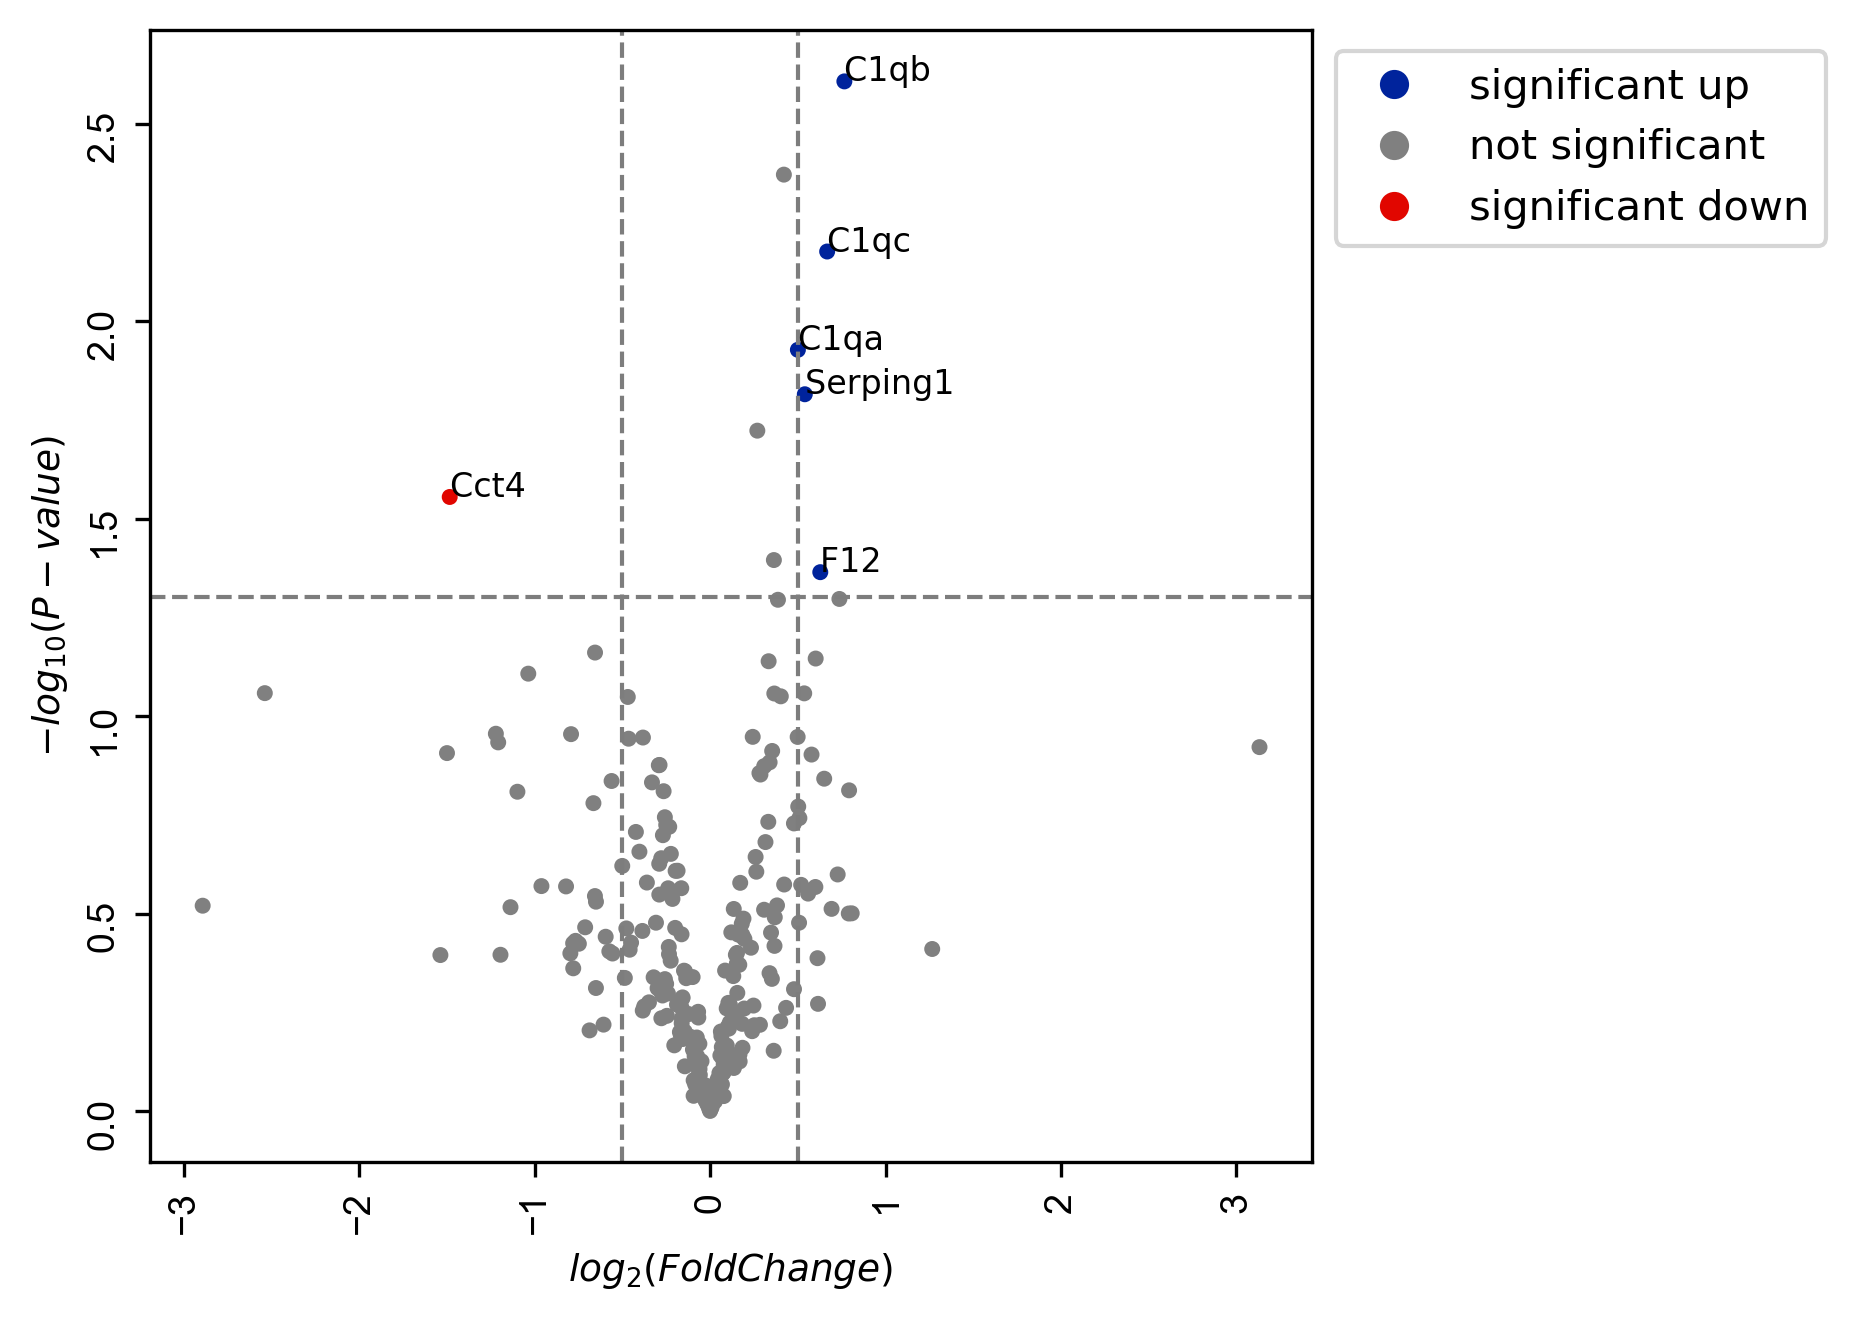

In [77]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=Grp3Grp4a, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="Proteins", lfc_thr=(.5, .5), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)

In [78]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp4')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp3')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

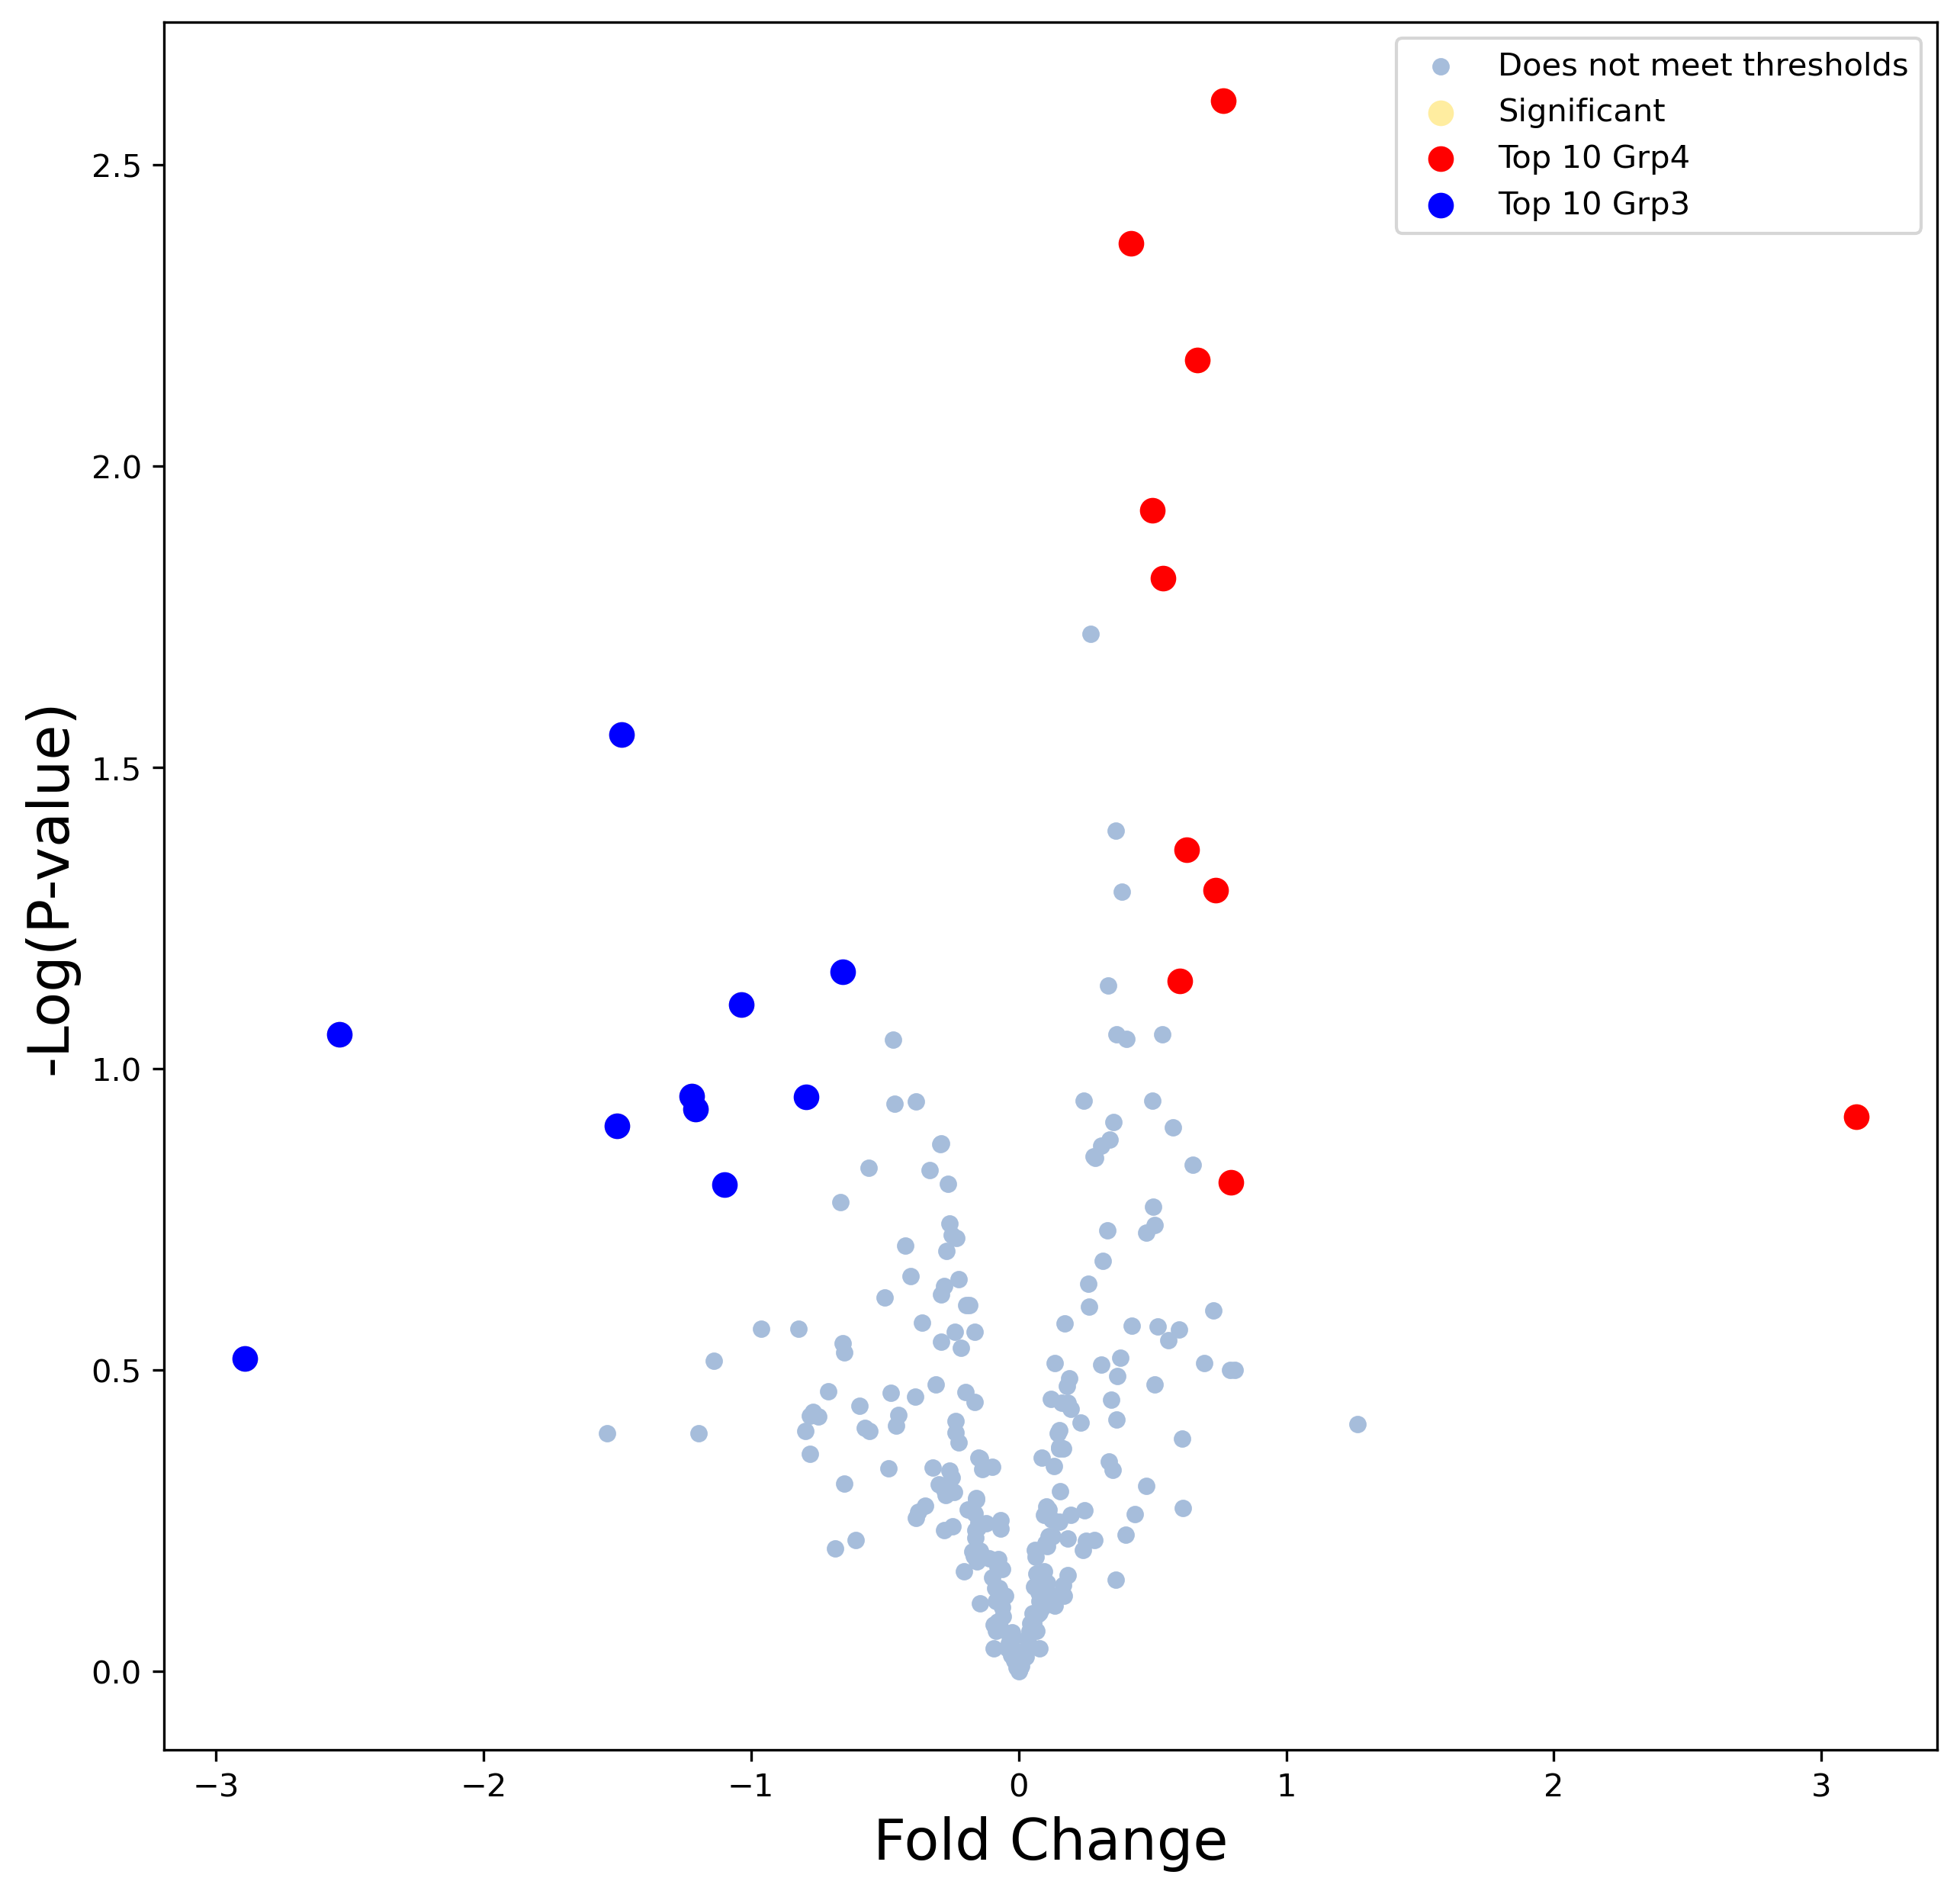

In [79]:
volcanotop10(Normalized_df2,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Volcano_Plot_grp21.pdf')

## Binary comparisons Group 4 vs Group 2

In [80]:
# load data file
Normalized_df2 = pd.read_excel (r'./Normalized_df_named.xlsx', index_col=0)
Normalized_df2.head()

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp3.5,Grp1.5,Grp2.5,Grp1.6,Grp3.6,Grp2.6,Grp4.5,Grp1.7,Grp2.7,Grp4.6
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,131.892175,174.334036,155.924749,230.260917,180.515772,256.302364,105.381750,144.340212,143.215590,187.676833
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.521731,174.340913,73.794377,159.309273,121.617649,120.716211,129.221329,137.379367,156.183798,157.744492
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,242.560155,136.293545,141.395158,101.661909,158.551723,133.372491,209.074300,352.086494,170.927823,116.948371
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,42.356801,223.611283,55.122966,233.397974,226.939385,177.297909,107.005493,91.017060,213.260267,170.996842


In [81]:
#Import protein names from head dataset for reference - we will use this later to add annotation to the Master Protein list
proteinlist = pd.read_excel (r'./proteinlist.xlsx', index_col=0) 

#View dataframe
proteinlist

,Proteins
Master Protein,
E9Q414,Apob
P01027,C3
Q61838,Pzp
P11276,Fn1
P01029,C4b
...,...
G5E861,Sclt1
Q5RI75,Rasef
P06151,Ldha


In [82]:
Grp4 = ['Grp4', 'Grp4.1','Grp4.2', 'Grp4.3', 'Grp4.4', 'Grp4.5', 'Grp4.6']
Grp2 = ['Grp2', 'Grp2.1','Grp2.2', 'Grp2.3', 'Grp2.4', 'Grp2.5', 'Grp2.6', 'Grp2.7']

In [83]:
Grp4_df = Normalized_df2[Grp4]
Grp2_df = Normalized_df2[Grp2]

In [84]:
Grp4Grp2 = TwoCategoryMaster(Normalized_df2,Grp4_df,Grp2_df,"Grp4","Grp2")
Grp4Grp2

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp1.7,Grp2.7,Grp4.6,ttest_pvalue,Grp4 Mean,Grp2 Mean,Fold Change(Grp4/Grp2),Log2(Fold Change),-Log(P-value),Grp4/Grp2 pi score
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,0.343573,147.047929,209.360514,0.702367,-0.509703,0.463980,-0.236492
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,144.340212,143.215590,187.676833,0.924016,180.559471,184.479985,0.978748,-0.030990,0.034320,-0.001064
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137.379367,156.183798,157.744492,0.958406,144.578043,146.543993,0.986585,-0.019485,0.018450,-0.000360
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,352.086494,170.927823,116.948371,0.845646,166.359447,171.705455,0.968865,-0.045632,0.072812,-0.003323
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,91.017060,213.260267,170.996842,0.241765,153.090170,202.825959,0.754786,-0.405861,0.616607,-0.250257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,85.285878,216.919647,124.581726,0.407572,150.063136,162.629019,0.922733,-0.116015,0.389795,-0.045222
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,128.116747,158.233635,184.231892,0.960670,147.516709,148.372188,0.994234,-0.008342,0.017426,-0.000145
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,NaN,0.250414,154.129958,176.808028,0.871736,-0.198036,0.601341,-0.119087


In [85]:
#Annotate the file with protein names
Grp4Grp2a = pd.merge(Grp4Grp2, proteinlist, left_index=True, right_index=True)
Grp4Grp2a

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp4 Mean,Grp2 Mean,Fold Change(Grp4/Grp2),Log2(Fold Change),-Log(P-value),Grp4/Grp2 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,0.343573,147.047929,209.360514,0.702367,-0.509703,0.463980,-0.236492,Ptprf
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,143.215590,187.676833,0.924016,180.559471,184.479985,0.978748,-0.030990,0.034320,-0.001064,Frmpd1
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,156.183798,157.744492,0.958406,144.578043,146.543993,0.986585,-0.019485,0.018450,-0.000360,Lrriq4
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,170.927823,116.948371,0.845646,166.359447,171.705455,0.968865,-0.045632,0.072812,-0.003323,Itih4
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,213.260267,170.996842,0.241765,153.090170,202.825959,0.754786,-0.405861,0.616607,-0.250257,Mmrn1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,216.919647,124.581726,0.407572,150.063136,162.629019,0.922733,-0.116015,0.389795,-0.045222,Pf4
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,158.233635,184.231892,0.960670,147.516709,148.372188,0.994234,-0.008342,0.017426,-0.000145,Thbs4
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,0.250414,154.129958,176.808028,0.871736,-0.198036,0.601341,-0.119087,Psma7


In [86]:
top10 = Normalized_df2['Grp4/Grp2 pi score'].nlargest(10)
low10 = Normalized_df2['Grp4/Grp2 pi score'].nsmallest(10)

top10df = Normalized_df2[Normalized_df2['Grp4/Grp2 pi score'].isin(top10)]
low10df = Normalized_df2[Normalized_df2['Grp4/Grp2 pi score'].isin(low10)]

In [87]:
#Annotate the file with protein names
top10a = pd.merge(top10, proteinlist, left_index=True, right_index=True)
top10a

,Grp4/Grp2 pi score,Proteins
Master Protein,,
P01630,0.841119,Ig kappa chain V-II region 7S34.1 OS
P01758,0.745953,Igh-VJ558
P01759,0.732571,Ig heavy chain V region BCL1 OS
Q80YC5,0.703076,F12
P50446,0.697453,Krt6a
Q8VCC2,0.581575,Ces1
Q60994,0.552040,Adipoq
P04940,0.548922,Ig kappa chain V-VI region NQ2-17.4.1 OS
P01642,0.495567,Gm10881


In [89]:
#Subset out the significant proteins to a new dataframe
df_sign= Normalized_df2[(abs(Normalized_df2['Grp4/Grp2 pi score']) > (1))]
df_sign

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp1.7,Grp2.7,Grp4.6,ttest_pvalue,Grp4 Mean,Grp2 Mean,Fold Change(Grp4/Grp2),Log2(Fold Change),-Log(P-value),Grp4/Grp2 pi score
Master Protein,,,,,,,,,,,,,,,,,,,,,
P04945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,147.274095,133.484573,64.997420,0.131599,76.494602,282.284292,0.270984,-1.883719,0.880748,-1.659082
P05366,51.074413,51.267050,124.883506,31.300224,33.221011,55.301783,1331.141477,289.771059,35.311646,56.044089,...,2136.568109,33.785134,22.009415,0.124009,47.912946,108.526748,0.441485,-1.179563,0.906546,-1.069328
P35700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.656496,46.763807,85.671495,0.420474,82.350959,565.198417,0.145703,-2.778900,0.376261,-1.045590
Q61171,83.257071,46.363032,130.688890,87.790664,99.084820,121.902593,48.726458,46.997687,73.031356,377.951240,...,48.810843,28.423071,81.911087,0.362663,62.692708,383.269943,0.163573,-2.611991,0.440497,-1.150575
Q99KG3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112.133017,38.180245,551.617813,0.413449,271.061977,3275.311449,0.082759,-3.594937,0.383578,-1.378940


In [90]:
#Annotate the file with protein names
df_signa = pd.merge(df_sign, proteinlist, left_index=True, right_index=True)
df_signa

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp4 Mean,Grp2 Mean,Fold Change(Grp4/Grp2),Log2(Fold Change),-Log(P-value),Grp4/Grp2 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
P04945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,133.484573,64.997420,0.131599,76.494602,282.284292,0.270984,-1.883719,0.880748,-1.659082,Ig kappa chain V-VI region NQ2-6.1 OS
P05366,51.074413,51.267050,124.883506,31.300224,33.221011,55.301783,1331.141477,289.771059,35.311646,56.044089,...,33.785134,22.009415,0.124009,47.912946,108.526748,0.441485,-1.179563,0.906546,-1.069328,Saa1
P35700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.763807,85.671495,0.420474,82.350959,565.198417,0.145703,-2.778900,0.376261,-1.045590,Prdx1
Q61171,83.257071,46.363032,130.688890,87.790664,99.084820,121.902593,48.726458,46.997687,73.031356,377.951240,...,28.423071,81.911087,0.362663,62.692708,383.269943,0.163573,-2.611991,0.440497,-1.150575,Prdx2
Q99KG3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.180245,551.617813,0.413449,271.061977,3275.311449,0.082759,-3.594937,0.383578,-1.378940,Rbm10


In [91]:
#Export dataframe to csv with index
df_signa.to_csv(r'./grp42pi.csv')

In [92]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=Grp4Grp2a, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="Proteins", lfc_thr=(.5, .5), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)

AssertionError: either significant or non-significant genes are missing; try to change lfc_thr or pv_thr to include both significant and non-significant genes

In [94]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp4')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp2')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

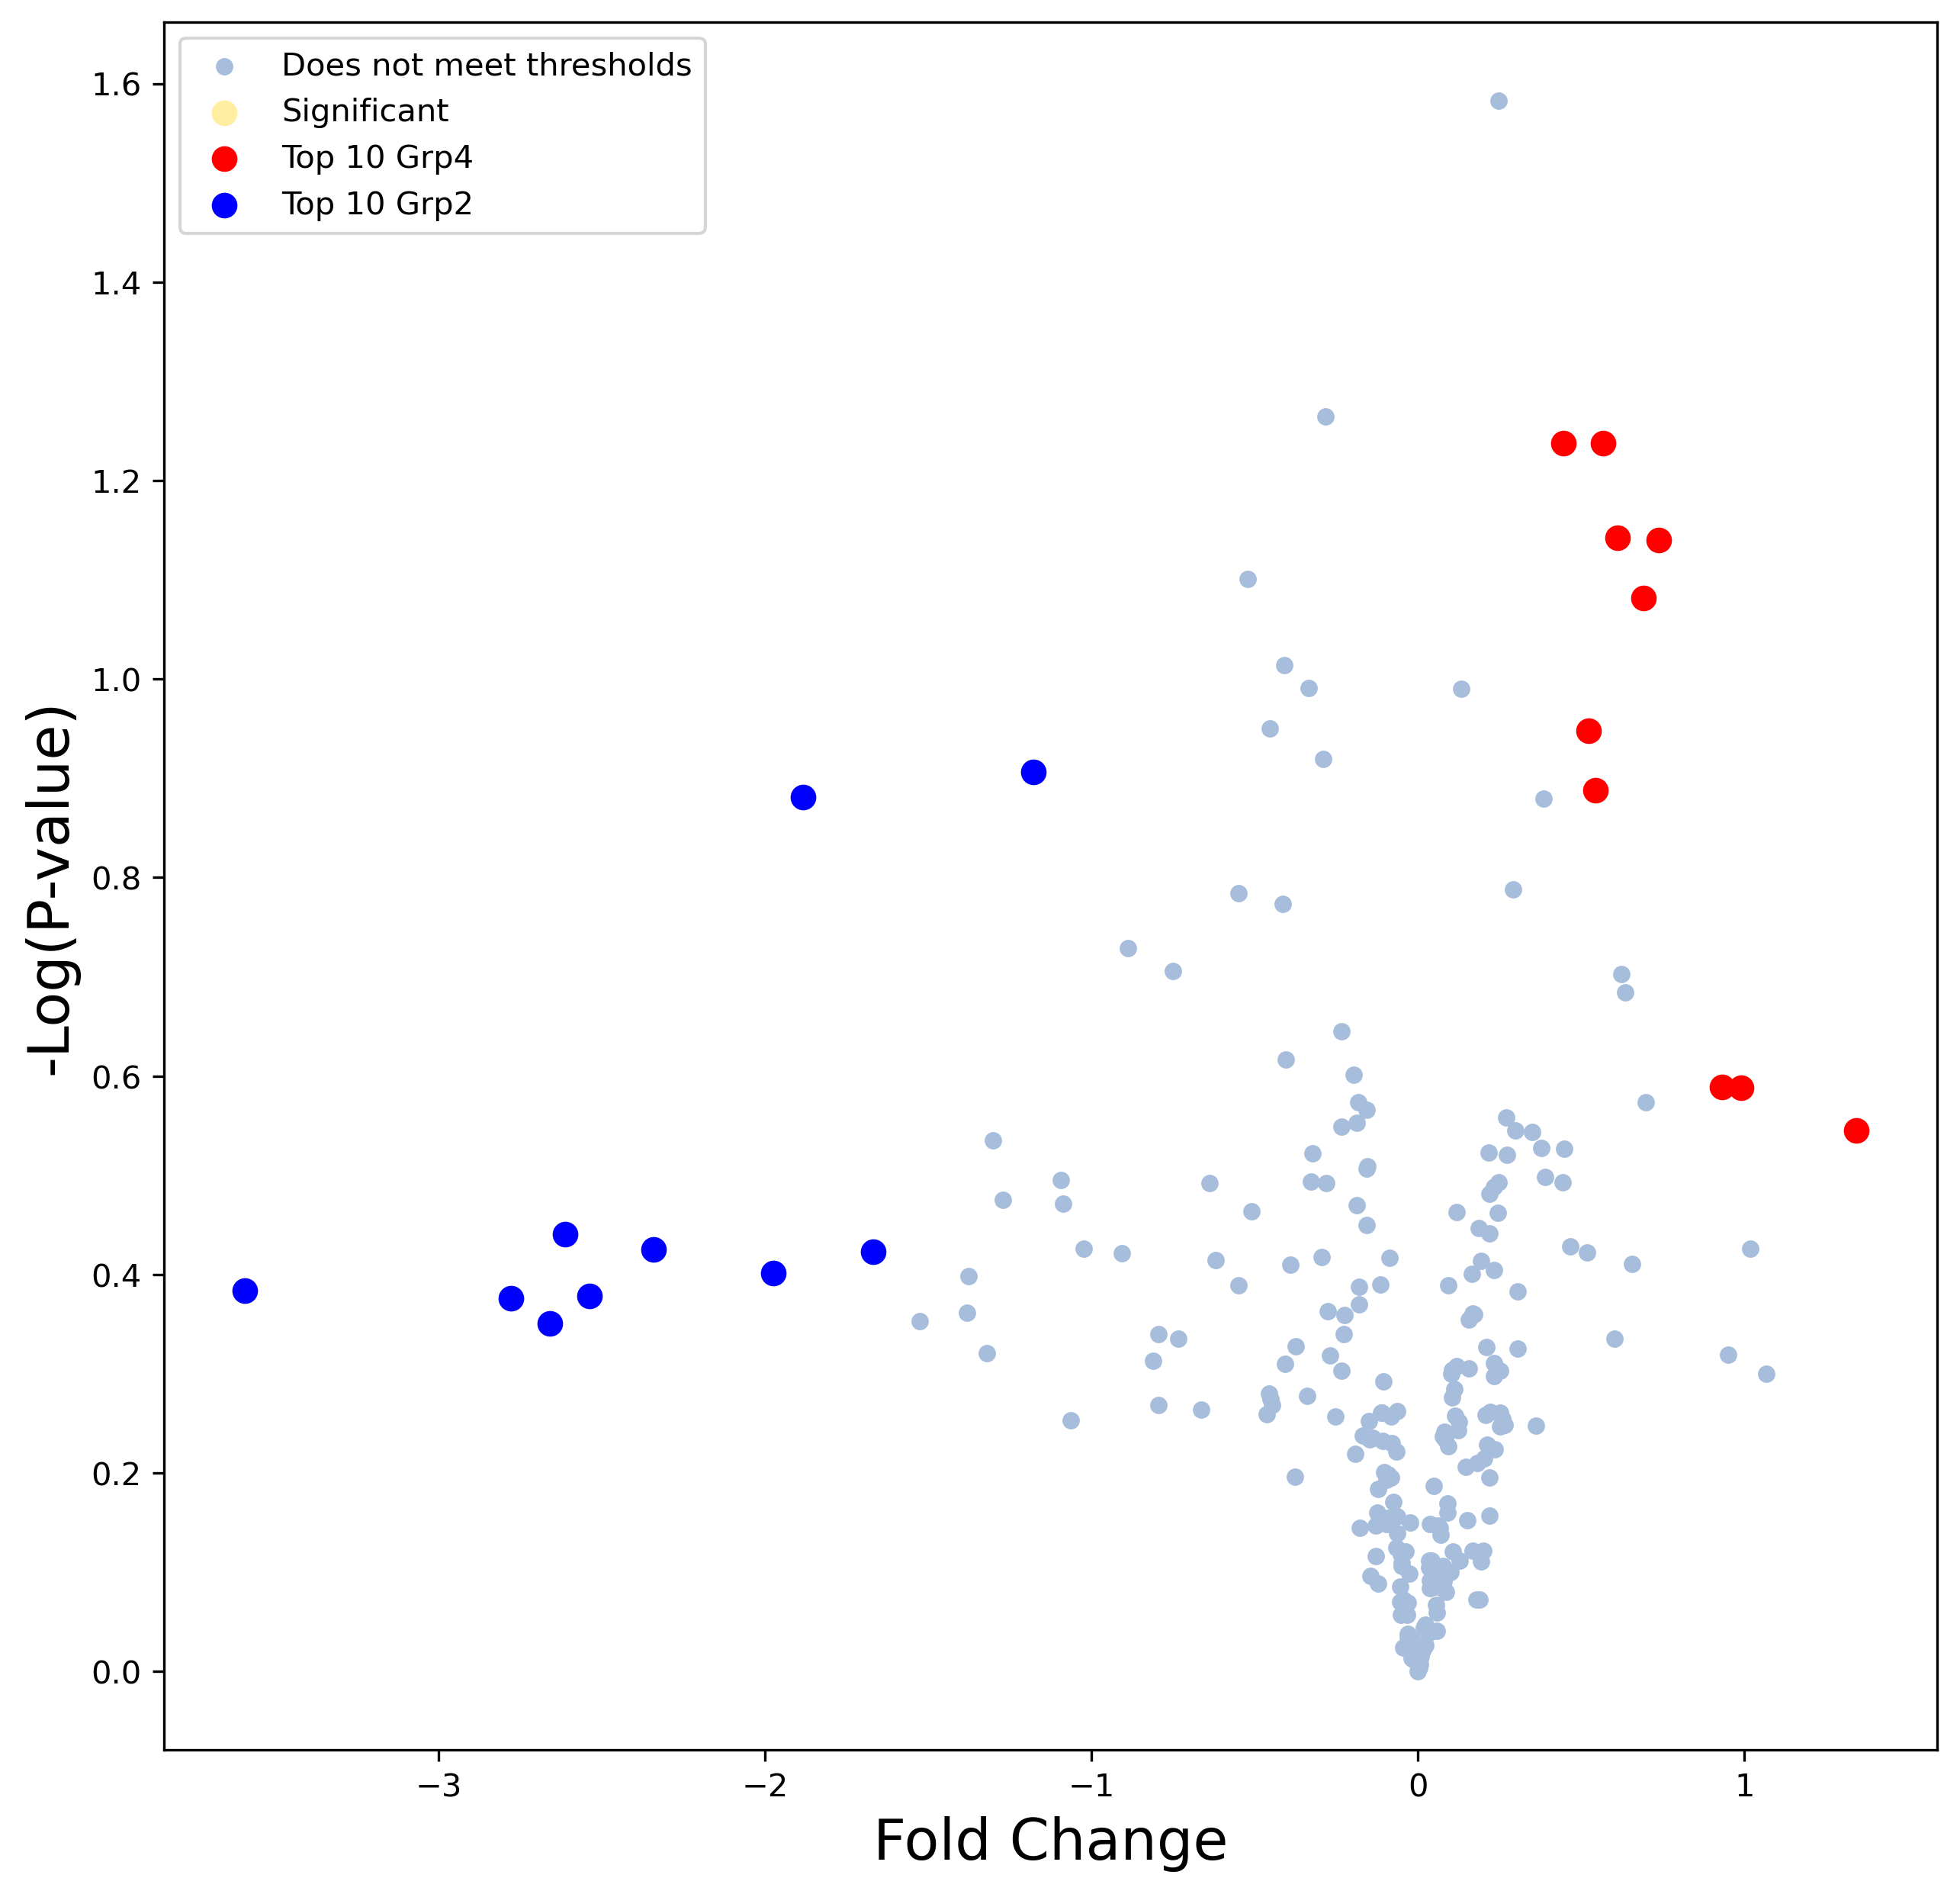

In [95]:
volcanotop10(Normalized_df2,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Volcano_Plot_nooutlier.pdf')

# Binary comparison Group 3 vs 1 

In [96]:
# load data file
Normalized_df2 = pd.read_excel (r'./Normalized_df_named.xlsx', index_col=0)
Normalized_df2.head()

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp3.5,Grp1.5,Grp2.5,Grp1.6,Grp3.6,Grp2.6,Grp4.5,Grp1.7,Grp2.7,Grp4.6
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,131.892175,174.334036,155.924749,230.260917,180.515772,256.302364,105.381750,144.340212,143.215590,187.676833
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.521731,174.340913,73.794377,159.309273,121.617649,120.716211,129.221329,137.379367,156.183798,157.744492
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,242.560155,136.293545,141.395158,101.661909,158.551723,133.372491,209.074300,352.086494,170.927823,116.948371
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,42.356801,223.611283,55.122966,233.397974,226.939385,177.297909,107.005493,91.017060,213.260267,170.996842


In [97]:
Grp1 = ['Grp1', 'Grp1.1', 'Grp1.2', 'Grp1.3', 'Grp1.4', 'Grp1.5', 'Grp1.6', 'Grp1.7']
Grp3 = ['Grp3', 'Grp3.1', 'Grp3.2', 'Grp3.3', 'Grp3.4', 'Grp3.5', 'Grp3.6']

In [98]:
Grp1_df = Normalized_df2[Grp1]
Grp3_df = Normalized_df2[Grp3]

In [99]:
Grp3Grp1 = TwoCategoryMaster(Normalized_df2,Grp3_df,Grp1_df,"Grp3","Grp1")
Grp3Grp1

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp1.7,Grp2.7,Grp4.6,ttest_pvalue,Grp3 Mean,Grp1 Mean,Fold Change(Grp3/Grp1),Log2(Fold Change),-Log(P-value),Grp3/Grp1 pi score
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,0.976986,123.903289,123.494769,1.003308,0.004765,0.010112,0.000048
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,144.340212,143.215590,187.676833,0.242521,167.746163,215.520149,0.778332,-0.361543,0.615250,-0.222439
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137.379367,156.183798,157.744492,0.066199,99.691515,149.416833,0.667204,-0.583800,1.179151,-0.688389
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,352.086494,170.927823,116.948371,0.646749,160.354747,176.057515,0.910809,-0.134780,0.189264,-0.025509
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,91.017060,213.260267,170.996842,0.523008,161.007474,186.895975,0.861482,-0.215108,0.281492,-0.060551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,85.285878,216.919647,124.581726,0.899522,151.571346,155.659760,0.973735,-0.038399,0.045988,-0.001766
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,128.116747,158.233635,184.231892,0.038317,114.471862,148.979068,0.768375,-0.380117,1.416606,-0.538476
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,NaN,0.244930,172.306171,132.786425,1.297619,0.375867,0.610958,0.229639


In [100]:
#Annotate the file with protein names
Grp3Grp1a = pd.merge(Grp3Grp1, proteinlist, left_index=True, right_index=True)
Grp3Grp1a

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp3 Mean,Grp1 Mean,Fold Change(Grp3/Grp1),Log2(Fold Change),-Log(P-value),Grp3/Grp1 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,0.976986,123.903289,123.494769,1.003308,0.004765,0.010112,0.000048,Ptprf
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,143.215590,187.676833,0.242521,167.746163,215.520149,0.778332,-0.361543,0.615250,-0.222439,Frmpd1
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,156.183798,157.744492,0.066199,99.691515,149.416833,0.667204,-0.583800,1.179151,-0.688389,Lrriq4
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,170.927823,116.948371,0.646749,160.354747,176.057515,0.910809,-0.134780,0.189264,-0.025509,Itih4
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,213.260267,170.996842,0.523008,161.007474,186.895975,0.861482,-0.215108,0.281492,-0.060551,Mmrn1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,216.919647,124.581726,0.899522,151.571346,155.659760,0.973735,-0.038399,0.045988,-0.001766,Pf4
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,158.233635,184.231892,0.038317,114.471862,148.979068,0.768375,-0.380117,1.416606,-0.538476,Thbs4
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,0.244930,172.306171,132.786425,1.297619,0.375867,0.610958,0.229639,Psma7


In [101]:
top10 = Normalized_df2['Grp3/Grp1 pi score'].nlargest(10)
low10 = Normalized_df2['Grp3/Grp1 pi score'].nsmallest(10)

top10df = Normalized_df2[Normalized_df2['Grp3/Grp1 pi score'].isin(top10)]
low10df = Normalized_df2[Normalized_df2['Grp3/Grp1 pi score'].isin(low10)]

In [102]:
#Annotate the file with protein names
top10a = pd.merge(top10, proteinlist, left_index=True, right_index=True)
top10a

,Grp3/Grp1 pi score,Proteins
Master Protein,,
P18525,2.245968,Ig heavy chain V region 5-84 OS
O08808,1.660507,Diaph1
P01659,1.545558,Ig kappa chain V-III region TEPC 124 OS
P01642,1.000663,Gm10881
P01665,0.909136,Ig kappa chain V-III region PC 7043 OS
Q3TTY5,0.874640,Krt2
P23492,0.799314,Pnp
P01878,0.752778,Ig alpha chain C region OS
P04186,0.739594,Cfb


In [104]:
#Subset out the significant proteins to a new dataframe
df_sign= Normalized_df2[(abs(Normalized_df2['Grp3/Grp1 pi score']) > (1))]
df_sign

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp1.7,Grp2.7,Grp4.6,ttest_pvalue,Grp3 Mean,Grp1 Mean,Fold Change(Grp3/Grp1),Log2(Fold Change),-Log(P-value),Grp3/Grp1 pi score
Master Protein,,,,,,,,,,,,,,,,,,,,,
O08808,524.325140,124.990304,86.445541,128.851550,1363.037976,62.201697,47.521255,45.817612,46.534980,127.406757,...,NaN,NaN,NaN,0.222204,530.980318,91.176443,5.823657,2.541925,0.653248,1.660507
P01636,90.820622,61.595531,48.571145,145.625856,61.943643,36.691155,44.117398,30.691833,36.191533,42.862762,...,4151.215924,56.255916,29.527281,0.303756,68.048842,629.790954,0.108050,-3.210231,0.517475,-1.661213
P01642,139.591893,111.064754,132.248361,128.373141,174.921852,219.040389,119.524950,143.009077,199.196498,181.048934,...,127.798659,200.976567,181.562647,0.058006,223.578535,127.591040,1.752306,0.809255,1.236524,1.000663
P01659,165.979394,56.731436,674.935658,56.175230,39.154717,623.367100,75.561836,12.813459,12.545947,96.332976,...,48.015436,107.615887,51.362581,0.143570,180.354601,50.603089,3.564103,1.833539,0.842937,1.545558
P01821,242.981933,138.471700,129.684957,795.063378,103.368454,133.835042,87.125335,147.344917,189.173579,211.063971,...,NaN,NaN,NaN,0.212330,121.194753,364.985582,0.332054,-1.590512,0.672989,-1.070397
P02762,211.016545,165.382654,539.062304,147.201053,55.081795,148.053285,305.273677,123.189152,86.102184,65.247015,...,425.696797,139.294875,220.952441,0.057400,96.497909,194.644357,0.495765,-1.012271,1.241089,-1.256318
P05366,51.074413,51.267050,124.883506,31.300224,33.221011,55.301783,1331.141477,289.771059,35.311646,56.044089,...,2136.568109,33.785134,22.009415,0.177778,32.096094,463.038390,0.069316,-3.850662,0.750122,-2.888468
P14106,186.899807,225.507999,237.072807,104.947098,134.840812,100.579928,153.421234,150.152814,204.633184,205.238811,...,152.177352,109.076999,145.128962,0.004658,102.982848,153.614261,0.670399,-0.576908,2.331788,-1.345228
P18525,75.001101,22.144622,18.750215,37.433374,40.243840,327.513955,33.744373,33.670155,50.484841,100.145708,...,NaN,NaN,NaN,0.098008,285.824532,61.073656,4.679997,2.226508,1.008740,2.245968


In [105]:
#Annotate the file with protein names
df_signa = pd.merge(df_sign, proteinlist, left_index=True, right_index=True)
df_signa

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp3 Mean,Grp1 Mean,Fold Change(Grp3/Grp1),Log2(Fold Change),-Log(P-value),Grp3/Grp1 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
O08808,524.325140,124.990304,86.445541,128.851550,1363.037976,62.201697,47.521255,45.817612,46.534980,127.406757,...,NaN,NaN,0.222204,530.980318,91.176443,5.823657,2.541925,0.653248,1.660507,Diaph1
P01636,90.820622,61.595531,48.571145,145.625856,61.943643,36.691155,44.117398,30.691833,36.191533,42.862762,...,56.255916,29.527281,0.303756,68.048842,629.790954,0.108050,-3.210231,0.517475,-1.661213,Ig kappa chain V-V region MOPC 149 OS
P01642,139.591893,111.064754,132.248361,128.373141,174.921852,219.040389,119.524950,143.009077,199.196498,181.048934,...,200.976567,181.562647,0.058006,223.578535,127.591040,1.752306,0.809255,1.236524,1.000663,Gm10881
P01659,165.979394,56.731436,674.935658,56.175230,39.154717,623.367100,75.561836,12.813459,12.545947,96.332976,...,107.615887,51.362581,0.143570,180.354601,50.603089,3.564103,1.833539,0.842937,1.545558,Ig kappa chain V-III region TEPC 124 OS
P01821,242.981933,138.471700,129.684957,795.063378,103.368454,133.835042,87.125335,147.344917,189.173579,211.063971,...,NaN,NaN,0.212330,121.194753,364.985582,0.332054,-1.590512,0.672989,-1.070397,Ig heavy chain V region MC101 OS
P02762,211.016545,165.382654,539.062304,147.201053,55.081795,148.053285,305.273677,123.189152,86.102184,65.247015,...,139.294875,220.952441,0.057400,96.497909,194.644357,0.495765,-1.012271,1.241089,-1.256318,Mup6
P05366,51.074413,51.267050,124.883506,31.300224,33.221011,55.301783,1331.141477,289.771059,35.311646,56.044089,...,33.785134,22.009415,0.177778,32.096094,463.038390,0.069316,-3.850662,0.750122,-2.888468,Saa1
P14106,186.899807,225.507999,237.072807,104.947098,134.840812,100.579928,153.421234,150.152814,204.633184,205.238811,...,109.076999,145.128962,0.004658,102.982848,153.614261,0.670399,-0.576908,2.331788,-1.345228,C1qb
P18525,75.001101,22.144622,18.750215,37.433374,40.243840,327.513955,33.744373,33.670155,50.484841,100.145708,...,NaN,NaN,0.098008,285.824532,61.073656,4.679997,2.226508,1.008740,2.245968,Ig heavy chain V region 5-84 OS


In [106]:
#Export dataframe to csv with index
df_signa.to_csv(r'./grp31pi.csv')

In [107]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=Grp3Grp1a, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="Proteins", lfc_thr=(1, 1), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)

AssertionError: either significant or non-significant genes are missing; try to change lfc_thr or pv_thr to include both significant and non-significant genes

In [108]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp3')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp1')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

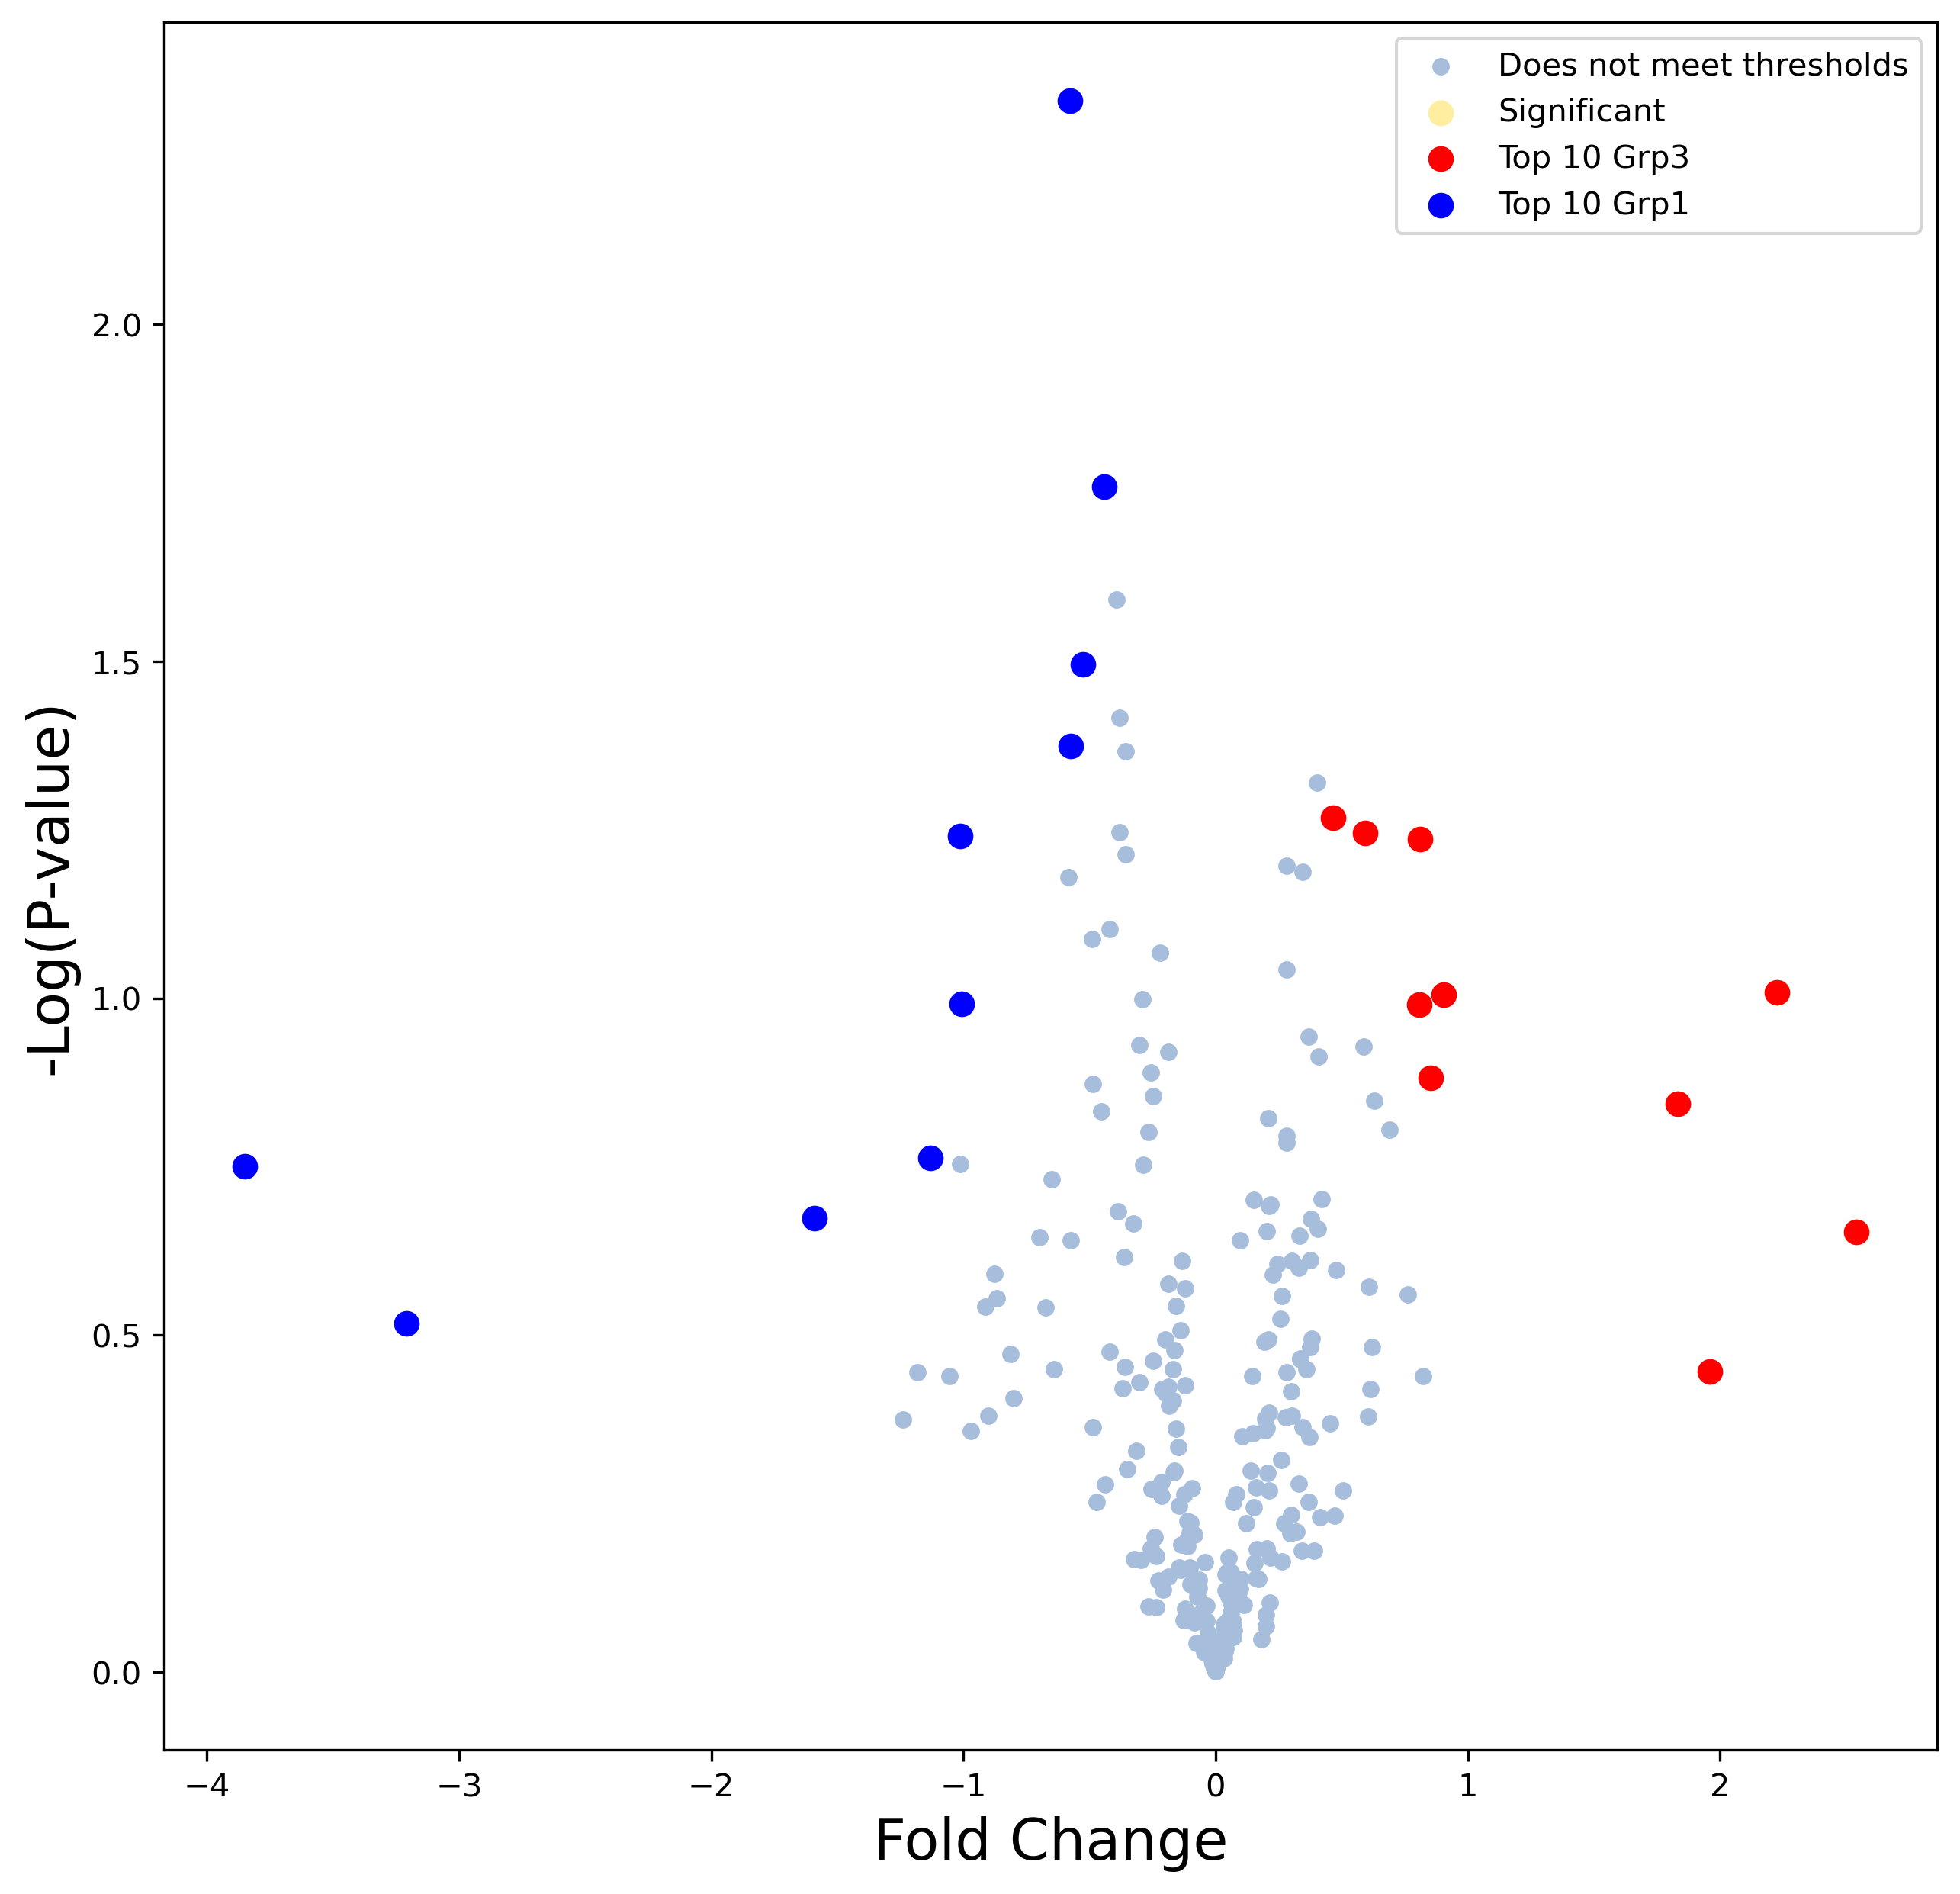

In [109]:
volcanotop10(Normalized_df2,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Volcano_Plot_nooutlier.pdf')

# Comparing 2&4 vs 1&3  

In [110]:
# load data file
Normalized_df2 = pd.read_excel (r'./Normalized_df_named.xlsx', index_col=0)
Normalized_df2.head()

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp3.5,Grp1.5,Grp2.5,Grp1.6,Grp3.6,Grp2.6,Grp4.5,Grp1.7,Grp2.7,Grp4.6
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,131.892175,174.334036,155.924749,230.260917,180.515772,256.302364,105.381750,144.340212,143.215590,187.676833
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.521731,174.340913,73.794377,159.309273,121.617649,120.716211,129.221329,137.379367,156.183798,157.744492
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,242.560155,136.293545,141.395158,101.661909,158.551723,133.372491,209.074300,352.086494,170.927823,116.948371
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,42.356801,223.611283,55.122966,233.397974,226.939385,177.297909,107.005493,91.017060,213.260267,170.996842


In [125]:
Grp13 = ['Grp1', 'Grp1.1', 'Grp1.2', 'Grp1.3', 'Grp1.4', 'Grp1.5', 'Grp1.6', 'Grp1.7', 'Grp3', 'Grp3.1', 'Grp3.2', 'Grp3.3', 'Grp3.4', 'Grp3.5', 'Grp3.6']
Grp24 = ['Grp4', 'Grp4.1','Grp4.2', 'Grp4.3', 'Grp4.4', 'Grp4.5', 'Grp4.6', 'Grp2', 'Grp2.1','Grp2.2', 'Grp2.3', 'Grp2.4', 'Grp2.5', 'Grp2.6', 'Grp2.7']


In [126]:
Grp13_df = Normalized_df2[Grp13]
Grp24_df = Normalized_df2[Grp24]

In [127]:
Grp13Grp24 = TwoCategoryMaster(Normalized_df2,Grp24_df,Grp13_df,"Grp24","Grp13")
Grp13Grp24

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp1.7,Grp2.7,Grp4.6,ttest_pvalue,Grp24 Mean,Grp13 Mean,Fold Change(Grp24/Grp13),Log2(Fold Change),-Log(P-value),Grp24/Grp13 pi score
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,0.116453,182.655121,123.699029,1.476609,0.562288,0.933848,0.525091
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,144.340212,143.215590,187.676833,0.710045,182.650412,193.225622,0.945270,-0.081201,0.148714,-0.012076
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137.379367,156.183798,157.744492,0.416898,145.561018,128.105983,1.136255,0.184286,0.379970,0.070023
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,352.086494,170.927823,116.948371,0.982230,169.210651,168.729556,1.002851,0.004108,0.007787,0.000032
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,91.017060,213.260267,170.996842,0.864753,179.615924,174.814675,1.027465,0.039089,0.063108,0.002467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,85.285878,216.919647,124.581726,0.858390,156.764941,153.751834,1.019597,0.027999,0.066315,0.001857
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,128.116747,158.233635,184.231892,0.207035,147.972965,132.875705,1.113619,0.155256,0.683957,0.106189
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,NaN,0.413868,167.088856,152.546298,1.095332,0.131368,0.383138,0.050332


In [128]:
#Annotate the file with protein names
Grp13Grp24a = pd.merge(Grp13Grp24, proteinlist, left_index=True, right_index=True)
Grp13Grp24a

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp24 Mean,Grp13 Mean,Fold Change(Grp24/Grp13),Log2(Fold Change),-Log(P-value),Grp24/Grp13 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,0.116453,182.655121,123.699029,1.476609,0.562288,0.933848,0.525091,Ptprf
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,143.215590,187.676833,0.710045,182.650412,193.225622,0.945270,-0.081201,0.148714,-0.012076,Frmpd1
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,156.183798,157.744492,0.416898,145.561018,128.105983,1.136255,0.184286,0.379970,0.070023,Lrriq4
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,170.927823,116.948371,0.982230,169.210651,168.729556,1.002851,0.004108,0.007787,0.000032,Itih4
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,213.260267,170.996842,0.864753,179.615924,174.814675,1.027465,0.039089,0.063108,0.002467,Mmrn1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,216.919647,124.581726,0.858390,156.764941,153.751834,1.019597,0.027999,0.066315,0.001857,Pf4
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,158.233635,184.231892,0.207035,147.972965,132.875705,1.113619,0.155256,0.683957,0.106189,Thbs4
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,0.413868,167.088856,152.546298,1.095332,0.131368,0.383138,0.050332,Psma7


In [129]:
top10 = Normalized_df2['Grp24/Grp13 pi score'].nlargest(10)
low10 = Normalized_df2['Grp24/Grp13 pi score'].nsmallest(10)

top10df = Normalized_df2[Normalized_df2['Grp24/Grp13 pi score'].isin(top10)]
low10df = Normalized_df2[Normalized_df2['Grp24/Grp13 pi score'].isin(low10)]

In [130]:
#Annotate the file with protein names
top10a = pd.merge(top10, proteinlist, left_index=True, right_index=True)
top10a

,Grp24/Grp13 pi score,Proteins
Master Protein,,
Q99KG3,2.722277,Rbm10
P01665,0.938511,Ig kappa chain V-III region PC 7043 OS
Q61879,0.726360,Myh10
P00688,0.720307,Amy2
Q9ES30,0.618409,C1qtnf3
P97290,0.530716,Serping1
A2A8L5,0.525091,Ptprf
P14106,0.506149,C1qb
P01663,0.454757,Ig kappa chain V-III region PC 4050 OS


In [131]:
#Subset out the significant proteins to a new dataframe
df_sign= Normalized_df2[(abs(Normalized_df2['Grp24/Grp13 pi score']) > (1))]
df_sign

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp1.7,Grp2.7,Grp4.6,ttest_pvalue,Grp24 Mean,Grp13 Mean,Fold Change(Grp24/Grp13),Log2(Fold Change),-Log(P-value),Grp24/Grp13 pi score
Master Protein,,,,,,,,,,,,,,,,,,,,,
P01636,90.820622,61.595531,48.571145,145.625856,61.943643,36.691155,44.117398,30.691833,36.191533,42.862762,...,4151.215924,56.255916,29.527281,0.273613,57.739492,367.644635,0.157052,-2.670682,0.562864,-1.503229
P18525,75.001101,22.144622,18.750215,37.433374,40.243840,327.513955,33.744373,33.670155,50.484841,100.145708,...,NaN,NaN,NaN,0.077631,45.566749,173.449094,0.262710,-1.928459,1.109964,-2.140519
Q99KG3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112.133017,38.180245,551.617813,0.308542,1773.186713,44.063007,40.242073,5.330633,0.510686,2.722277


In [132]:
#Annotate the file with protein names
df_signa = pd.merge(df_sign, proteinlist, left_index=True, right_index=True)
df_signa

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp24 Mean,Grp13 Mean,Fold Change(Grp24/Grp13),Log2(Fold Change),-Log(P-value),Grp24/Grp13 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
P01636,90.820622,61.595531,48.571145,145.625856,61.943643,36.691155,44.117398,30.691833,36.191533,42.862762,...,56.255916,29.527281,0.273613,57.739492,367.644635,0.157052,-2.670682,0.562864,-1.503229,Ig kappa chain V-V region MOPC 149 OS
P18525,75.001101,22.144622,18.750215,37.433374,40.243840,327.513955,33.744373,33.670155,50.484841,100.145708,...,NaN,NaN,0.077631,45.566749,173.449094,0.262710,-1.928459,1.109964,-2.140519,Ig heavy chain V region 5-84 OS
Q99KG3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.180245,551.617813,0.308542,1773.186713,44.063007,40.242073,5.330633,0.510686,2.722277,Rbm10


In [133]:
#Export dataframe to csv with index
df_signa.to_csv(r'./grp13vs24pi.csv')

In [134]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=Grp13Grp24a, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="Proteins", lfc_thr=(1, 1), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)

AssertionError: either significant or non-significant genes are missing; try to change lfc_thr or pv_thr to include both significant and non-significant genes

In [135]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp3')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp1')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

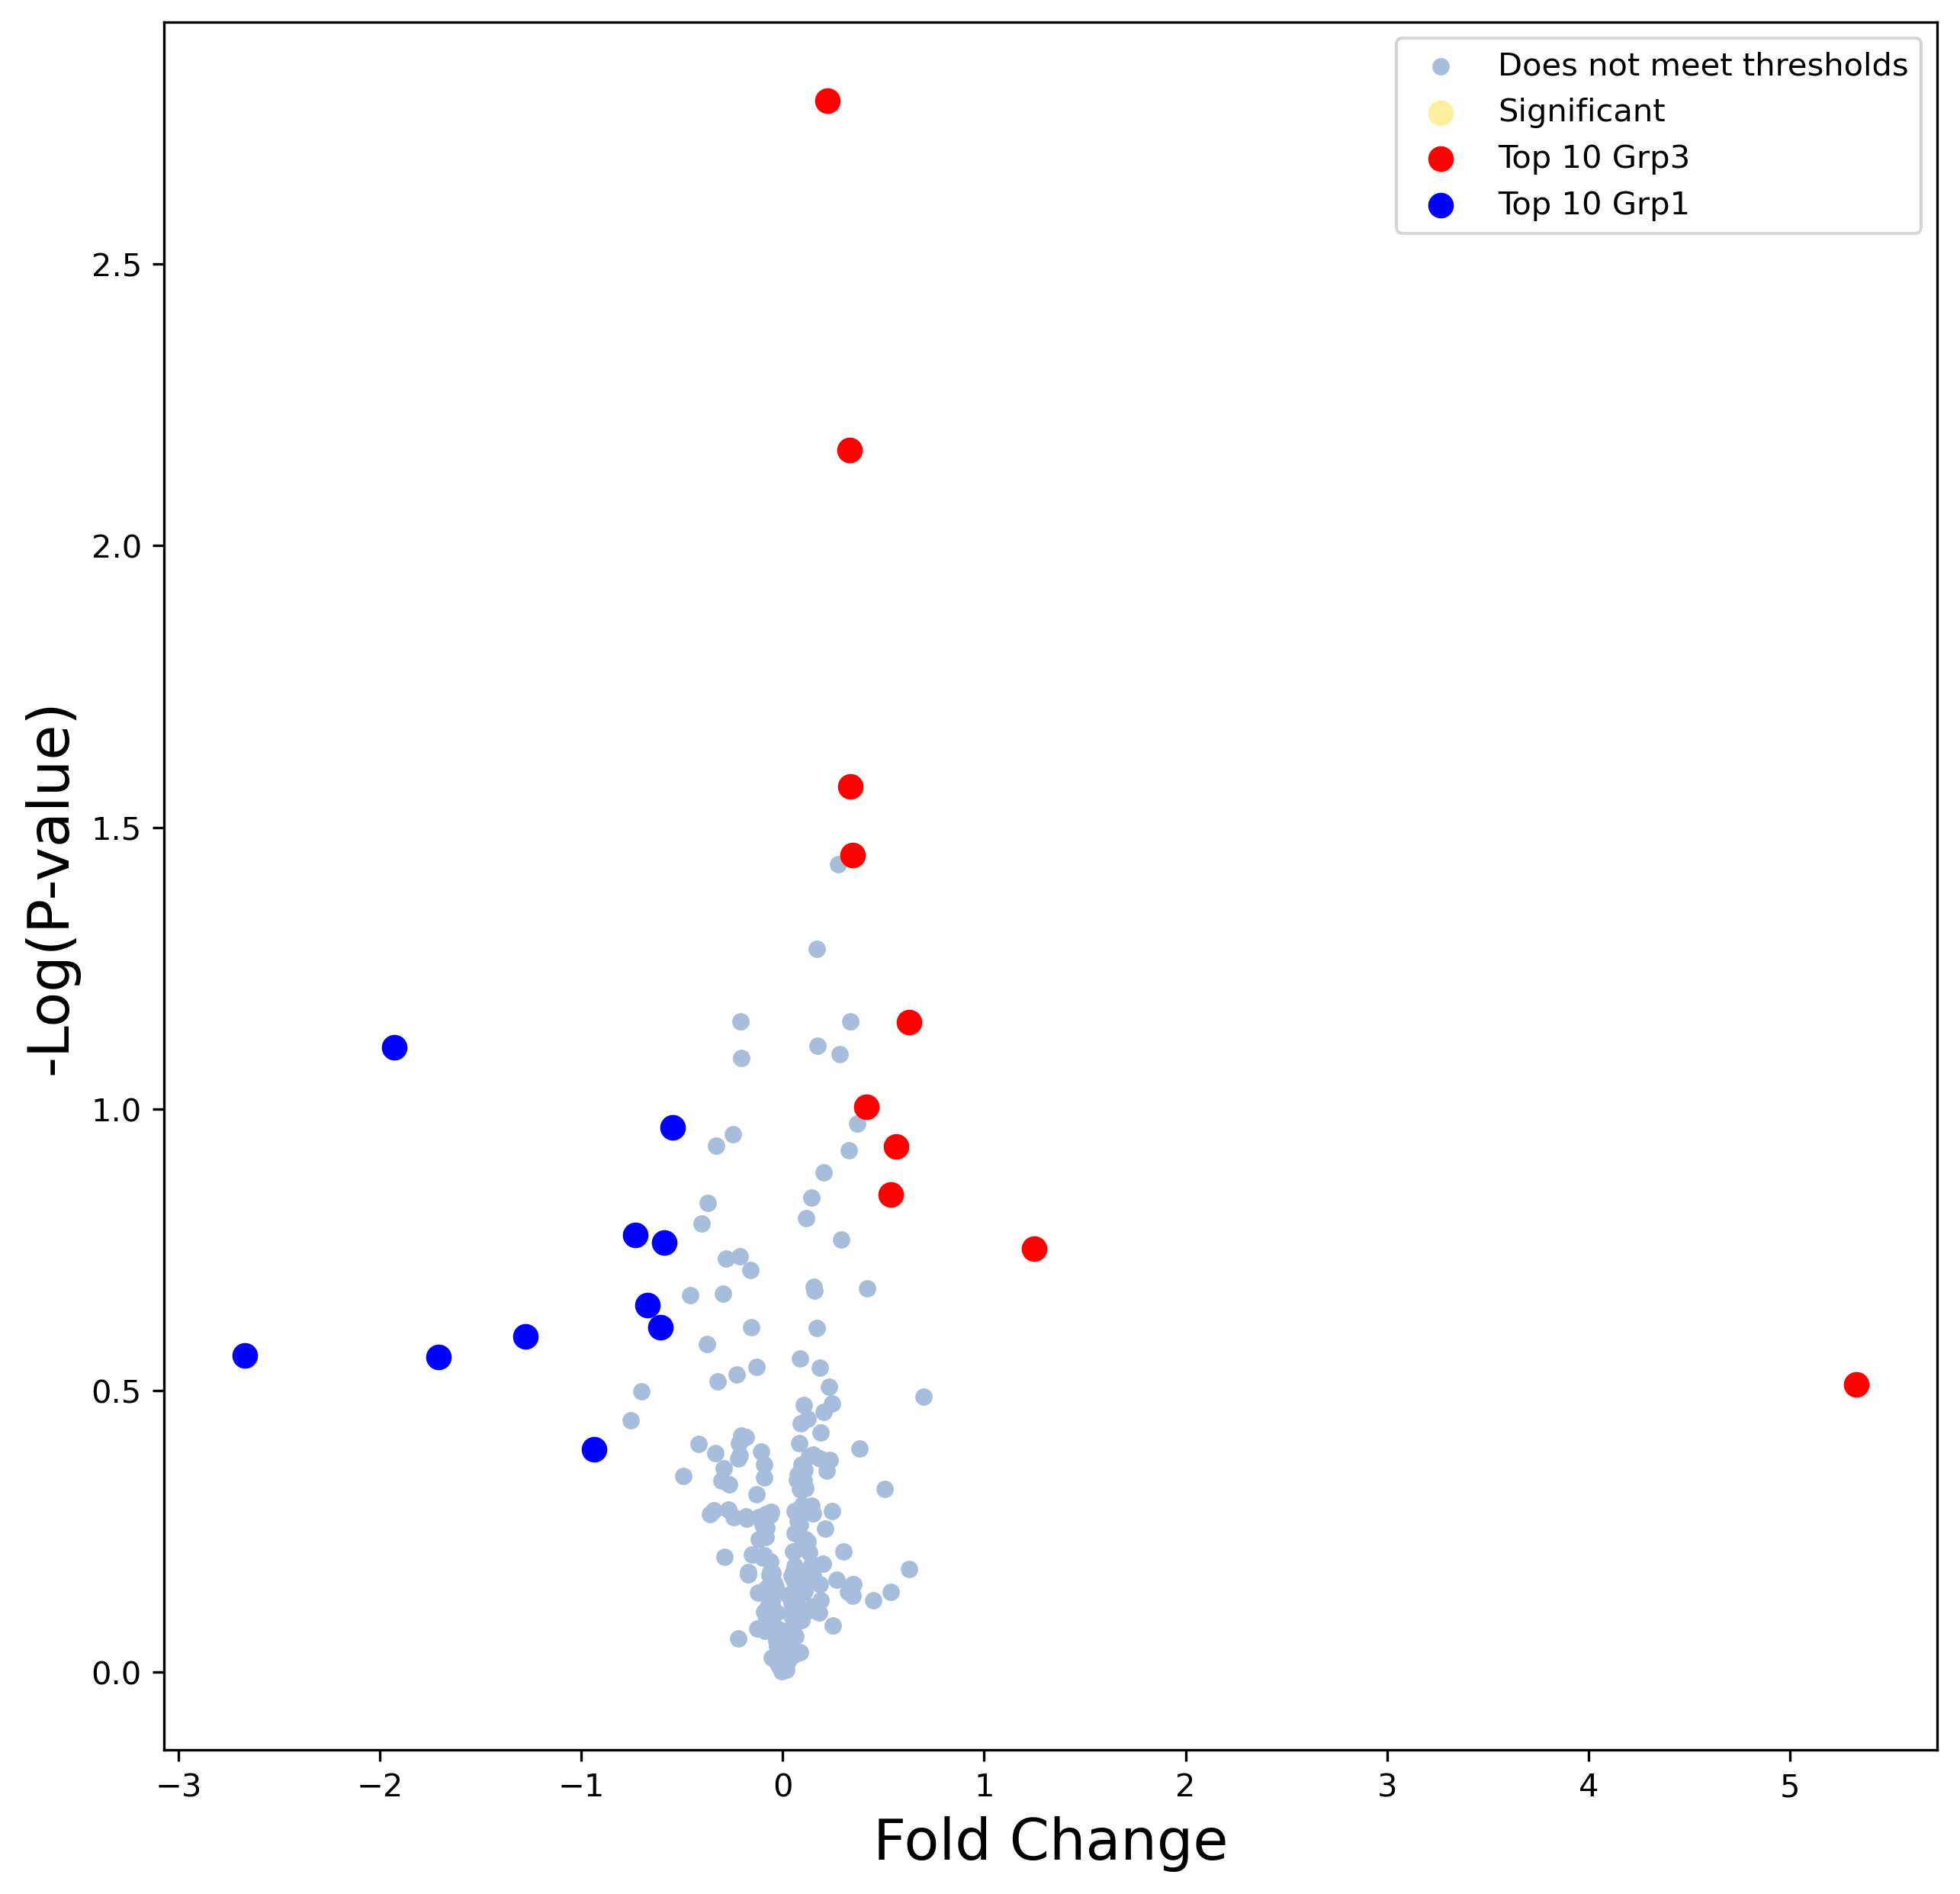

In [136]:
volcanotop10(Normalized_df2,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Volcano_Plot_nooutlier.pdf')

# Group 34 vs 12

In [137]:
# load data file
Normalized_df2 = pd.read_excel (r'./Normalized_df_named.xlsx', index_col=0)
Normalized_df2.head()

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp3.5,Grp1.5,Grp2.5,Grp1.6,Grp3.6,Grp2.6,Grp4.5,Grp1.7,Grp2.7,Grp4.6
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,131.892175,174.334036,155.924749,230.260917,180.515772,256.302364,105.381750,144.340212,143.215590,187.676833
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,68.521731,174.340913,73.794377,159.309273,121.617649,120.716211,129.221329,137.379367,156.183798,157.744492
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,242.560155,136.293545,141.395158,101.661909,158.551723,133.372491,209.074300,352.086494,170.927823,116.948371
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,42.356801,223.611283,55.122966,233.397974,226.939385,177.297909,107.005493,91.017060,213.260267,170.996842


In [141]:
Grp12 = ['Grp1', 'Grp1.1', 'Grp1.2', 'Grp1.3', 'Grp1.4', 'Grp1.5', 'Grp1.6', 'Grp1.7', 'Grp2', 'Grp2.1','Grp2.2', 'Grp2.3', 'Grp2.4', 'Grp2.5', 'Grp2.6', 'Grp2.7']
Grp34 = ['Grp4', 'Grp4.1','Grp4.2', 'Grp4.3', 'Grp4.4', 'Grp4.5', 'Grp4.6', 'Grp3', 'Grp3.1', 'Grp3.2', 'Grp3.3', 'Grp3.4', 'Grp3.5', 'Grp3.6']


In [142]:
Grp12_df = Normalized_df2[Grp12]
Grp34_df = Normalized_df2[Grp34]

In [143]:
Grp12Grp34 = TwoCategoryMaster(Normalized_df2,Grp34_df,Grp12_df,"Grp34","Grp12")
Grp12Grp34

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp1.7,Grp2.7,Grp4.6,ttest_pvalue,Grp34 Mean,Grp12 Mean,Fold Change(Grp34/Grp12),Log2(Fold Change),-Log(P-value),Grp34/Grp12 pi score
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,NaN,0.329370,133.822421,166.427641,0.804088,-0.314575,0.482317,-0.151725
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,144.340212,143.215590,187.676833,0.350547,174.152817,200.000067,0.870764,-0.199647,0.455254,-0.090890
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137.379367,156.183798,157.744492,0.285311,125.340960,147.980413,0.847010,-0.239548,0.544682,-0.130478
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,352.086494,170.927823,116.948371,0.615227,163.357097,173.881485,0.939474,-0.090075,0.210965,-0.019003
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,91.017060,213.260267,170.996842,0.171907,157.048822,194.860967,0.805953,-0.311232,0.764707,-0.238001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,85.285878,216.919647,124.581726,0.624985,150.817241,159.144390,0.947676,-0.077535,0.204131,-0.015827
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,128.116747,158.233635,184.231892,0.147288,130.994285,148.675628,0.881074,-0.182664,0.831834,-0.151946
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,NaN,0.613290,164.516365,154.797227,1.062786,0.087851,0.212334,0.018654


In [144]:
#Annotate the file with protein names
Grp12Grp34a = pd.merge(Grp12Grp34, proteinlist, left_index=True, right_index=True)
Grp12Grp34a

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp34 Mean,Grp12 Mean,Fold Change(Grp34/Grp12),Log2(Fold Change),-Log(P-value),Grp34/Grp12 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
A2A8L5,206.138912,135.920086,116.570748,131.621665,103.078093,134.867242,91.154910,129.703874,99.084788,126.480283,...,NaN,NaN,0.329370,133.822421,166.427641,0.804088,-0.314575,0.482317,-0.151725,Ptprf
A2AKB4,170.332789,308.847279,222.317069,197.332273,252.059998,126.840179,182.841633,190.084701,255.670958,426.697989,...,143.215590,187.676833,0.350547,174.152817,200.000067,0.870764,-0.199647,0.455254,-0.090890,Frmpd1
A6H6A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,156.183798,157.744492,0.285311,125.340960,147.980413,0.847010,-0.239548,0.544682,-0.130478,Lrriq4
A6X935,125.971084,119.090315,131.909449,118.650508,103.466541,184.269289,233.431594,224.927504,192.138473,135.398629,...,170.927823,116.948371,0.615227,163.357097,173.881485,0.939474,-0.090075,0.210965,-0.019003,Itih4
B2RPV6,224.256651,172.433706,156.689113,188.388319,327.985156,126.296134,212.916759,177.344167,170.645514,192.001014,...,213.260267,170.996842,0.171907,157.048822,194.860967,0.805953,-0.311232,0.764707,-0.238001,Mmrn1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Z126,172.381277,141.944842,139.479664,146.695822,170.806838,190.785838,237.299452,147.388908,115.474901,100.918566,...,216.919647,124.581726,0.624985,150.817241,159.144390,0.947676,-0.077535,0.204131,-0.015827,Pf4
Q9Z1T2,126.047872,160.230188,120.980278,118.326547,159.418498,119.589076,185.370405,132.265067,83.933670,146.738951,...,158.233635,184.231892,0.147288,130.994285,148.675628,0.881074,-0.182664,0.831834,-0.151946,Thbs4
Q9Z2U0,176.841482,158.004048,189.517145,155.164057,170.838311,209.146398,139.404359,181.962595,127.544346,125.369934,...,NaN,NaN,0.613290,164.516365,154.797227,1.062786,0.087851,0.212334,0.018654,Psma7


In [145]:
top10 = Normalized_df2['Grp34/Grp12 pi score'].nlargest(10)
low10 = Normalized_df2['Grp34/Grp12 pi score'].nsmallest(10)

top10df = Normalized_df2[Normalized_df2['Grp34/Grp12 pi score'].isin(top10)]
low10df = Normalized_df2[Normalized_df2['Grp34/Grp12 pi score'].isin(low10)]

In [146]:
#Annotate the file with protein names
top10a = pd.merge(top10, proteinlist, left_index=True, right_index=True)
top10a

,Grp34/Grp12 pi score,Proteins
Master Protein,,
P18525,1.761942,Ig heavy chain V region 5-84 OS
O08808,1.743626,Diaph1
P01642,1.363441,Gm10881
P01878,0.799004,Ig alpha chain C region OS
Q60994,0.682852,Adipoq
P06328,0.625851,Ighv1-72
P04186,0.563641,Cfb
Q9CPY7,0.494079,Lap3
P01659,0.488367,Ig kappa chain V-III region TEPC 124 OS


In [147]:
#Subset out the significant proteins to a new dataframe
df_sign= Normalized_df2[(abs(Normalized_df2['Grp34/Grp12 pi score']) > (1))]

In [148]:
df_sign

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp1.7,Grp2.7,Grp4.6,ttest_pvalue,Grp34 Mean,Grp12 Mean,Fold Change(Grp34/Grp12),Log2(Fold Change),-Log(P-value),Grp34/Grp12 pi score
Master Protein,,,,,,,,,,,,,,,,,,,,,
O08808,524.325140,124.990304,86.445541,128.851550,1363.037976,62.201697,47.521255,45.817612,46.534980,127.406757,...,NaN,NaN,NaN,0.133783,402.824528,100.992194,3.988670,1.995908,0.873601,1.743626
P01636,90.820622,61.595531,48.571145,145.625856,61.943643,36.691155,44.117398,30.691833,36.191533,42.862762,...,4151.215924,56.255916,29.527281,0.289736,63.139622,343.550450,0.183786,-2.443904,0.537997,-1.314813
P01642,139.591893,111.064754,132.248361,128.373141,174.921852,219.040389,119.524950,143.009077,199.196498,181.048934,...,127.798659,200.976567,181.562647,0.008764,217.670067,137.498062,1.583077,0.662732,2.057305,1.363441
P05366,51.074413,51.267050,124.883506,31.300224,33.221011,55.301783,1331.141477,289.771059,35.311646,56.044089,...,2136.568109,33.785134,22.009415,0.115894,40.004520,285.782569,0.139982,-2.836683,0.935938,-2.654960
P12246,84.860282,43.700922,131.179081,121.307239,67.519523,184.387916,444.712988,422.323938,98.374336,100.015994,...,636.932029,130.308802,66.649063,0.046793,113.939611,220.090639,0.517694,-0.949828,1.329820,-1.263101
P18525,75.001101,22.144622,18.750215,37.433374,40.243840,327.513955,33.744373,33.670155,50.484841,100.145708,...,NaN,NaN,NaN,0.108634,184.418385,51.953913,3.549653,1.827678,0.964033,1.761942
Q02357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,108.623040,60.101976,100.000685,0.247848,110.375464,392.251150,0.281390,-1.829358,0.605815,-1.108253
Q8VCM7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,308.400883,234.226326,250.360058,0.092081,140.446333,281.358442,0.499172,-1.002390,1.035831,-1.038307
Q99KG3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112.133017,38.180245,551.617813,0.378127,168.151201,1664.609543,0.101015,-3.307353,0.422362,-1.396901


In [149]:
#Annotate the file with protein names
df_signa = pd.merge(df_sign, proteinlist, left_index=True, right_index=True)
df_signa

,Grp4,Grp4.1,Grp2,Grp1,Grp3,Grp3.1,Grp1.1,Grp2.1,Grp4.2,Grp1.2,...,Grp2.7,Grp4.6,ttest_pvalue,Grp34 Mean,Grp12 Mean,Fold Change(Grp34/Grp12),Log2(Fold Change),-Log(P-value),Grp34/Grp12 pi score,Proteins
Master Protein,,,,,,,,,,,,,,,,,,,,,
O08808,524.325140,124.990304,86.445541,128.851550,1363.037976,62.201697,47.521255,45.817612,46.534980,127.406757,...,NaN,NaN,0.133783,402.824528,100.992194,3.988670,1.995908,0.873601,1.743626,Diaph1
P01636,90.820622,61.595531,48.571145,145.625856,61.943643,36.691155,44.117398,30.691833,36.191533,42.862762,...,56.255916,29.527281,0.289736,63.139622,343.550450,0.183786,-2.443904,0.537997,-1.314813,Ig kappa chain V-V region MOPC 149 OS
P01642,139.591893,111.064754,132.248361,128.373141,174.921852,219.040389,119.524950,143.009077,199.196498,181.048934,...,200.976567,181.562647,0.008764,217.670067,137.498062,1.583077,0.662732,2.057305,1.363441,Gm10881
P05366,51.074413,51.267050,124.883506,31.300224,33.221011,55.301783,1331.141477,289.771059,35.311646,56.044089,...,33.785134,22.009415,0.115894,40.004520,285.782569,0.139982,-2.836683,0.935938,-2.654960,Saa1
P12246,84.860282,43.700922,131.179081,121.307239,67.519523,184.387916,444.712988,422.323938,98.374336,100.015994,...,130.308802,66.649063,0.046793,113.939611,220.090639,0.517694,-0.949828,1.329820,-1.263101,Apcs
P18525,75.001101,22.144622,18.750215,37.433374,40.243840,327.513955,33.744373,33.670155,50.484841,100.145708,...,NaN,NaN,0.108634,184.418385,51.953913,3.549653,1.827678,0.964033,1.761942,Ig heavy chain V region 5-84 OS
Q02357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60.101976,100.000685,0.247848,110.375464,392.251150,0.281390,-1.829358,0.605815,-1.108253,Ank1
Q8VCM7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,234.226326,250.360058,0.092081,140.446333,281.358442,0.499172,-1.002390,1.035831,-1.038307,Fgg
Q99KG3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.180245,551.617813,0.378127,168.151201,1664.609543,0.101015,-3.307353,0.422362,-1.396901,Rbm10


In [150]:
#Export dataframe to csv with index
df_signa.to_csv(r'./grp12vs34pi.csv')

In [151]:
#Visualize binary comparison 
visuz.gene_exp.volcano(df=Grp12Grp34a, show = True, lfc='Log2(Fold Change)', pv='ttest_pvalue', geneid="Proteins", lfc_thr=(1, 1), pv_thr=(0.05, 0.05), genenames = 'deg',
    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, gstyle=1, sign_line=True, legendpos='upper right', 
    legendanchor=(1.46,1), r=1200)

AssertionError: either significant or non-significant genes are missing; try to change lfc_thr or pv_thr to include both significant and non-significant genes

In [152]:
def volcanotop10(df, significantdf,top10high,top10low,foldchange, pvalue, savename):
    plt.figure(figsize=(10, 10))
    plt.scatter(df['%s' % (foldchange)], df['%s' % (pvalue)], c='#a6bddb',s=20, label='Does not meet thresholds')
    plt.scatter(significantdf['%s' % (foldchange)], significantdf['%s' % (pvalue)], c='#ffeda0', s=50, label='Significant')
    plt.scatter(top10high['%s' % (foldchange)], top10high['%s' % (pvalue)], c='r', s=50, label='Top 10 Grp3')
    plt.scatter(top10low['%s' % (foldchange)], top10low['%s' % (pvalue)], c='b', s=50, label='Top 10 Grp1')
    plt.ylabel('-Log(P-value)', fontsize=18)
    plt.xlabel('Fold Change', fontsize=18)
    plt.legend(scatterpoints=1)
    plt.savefig('%s' % (savename))

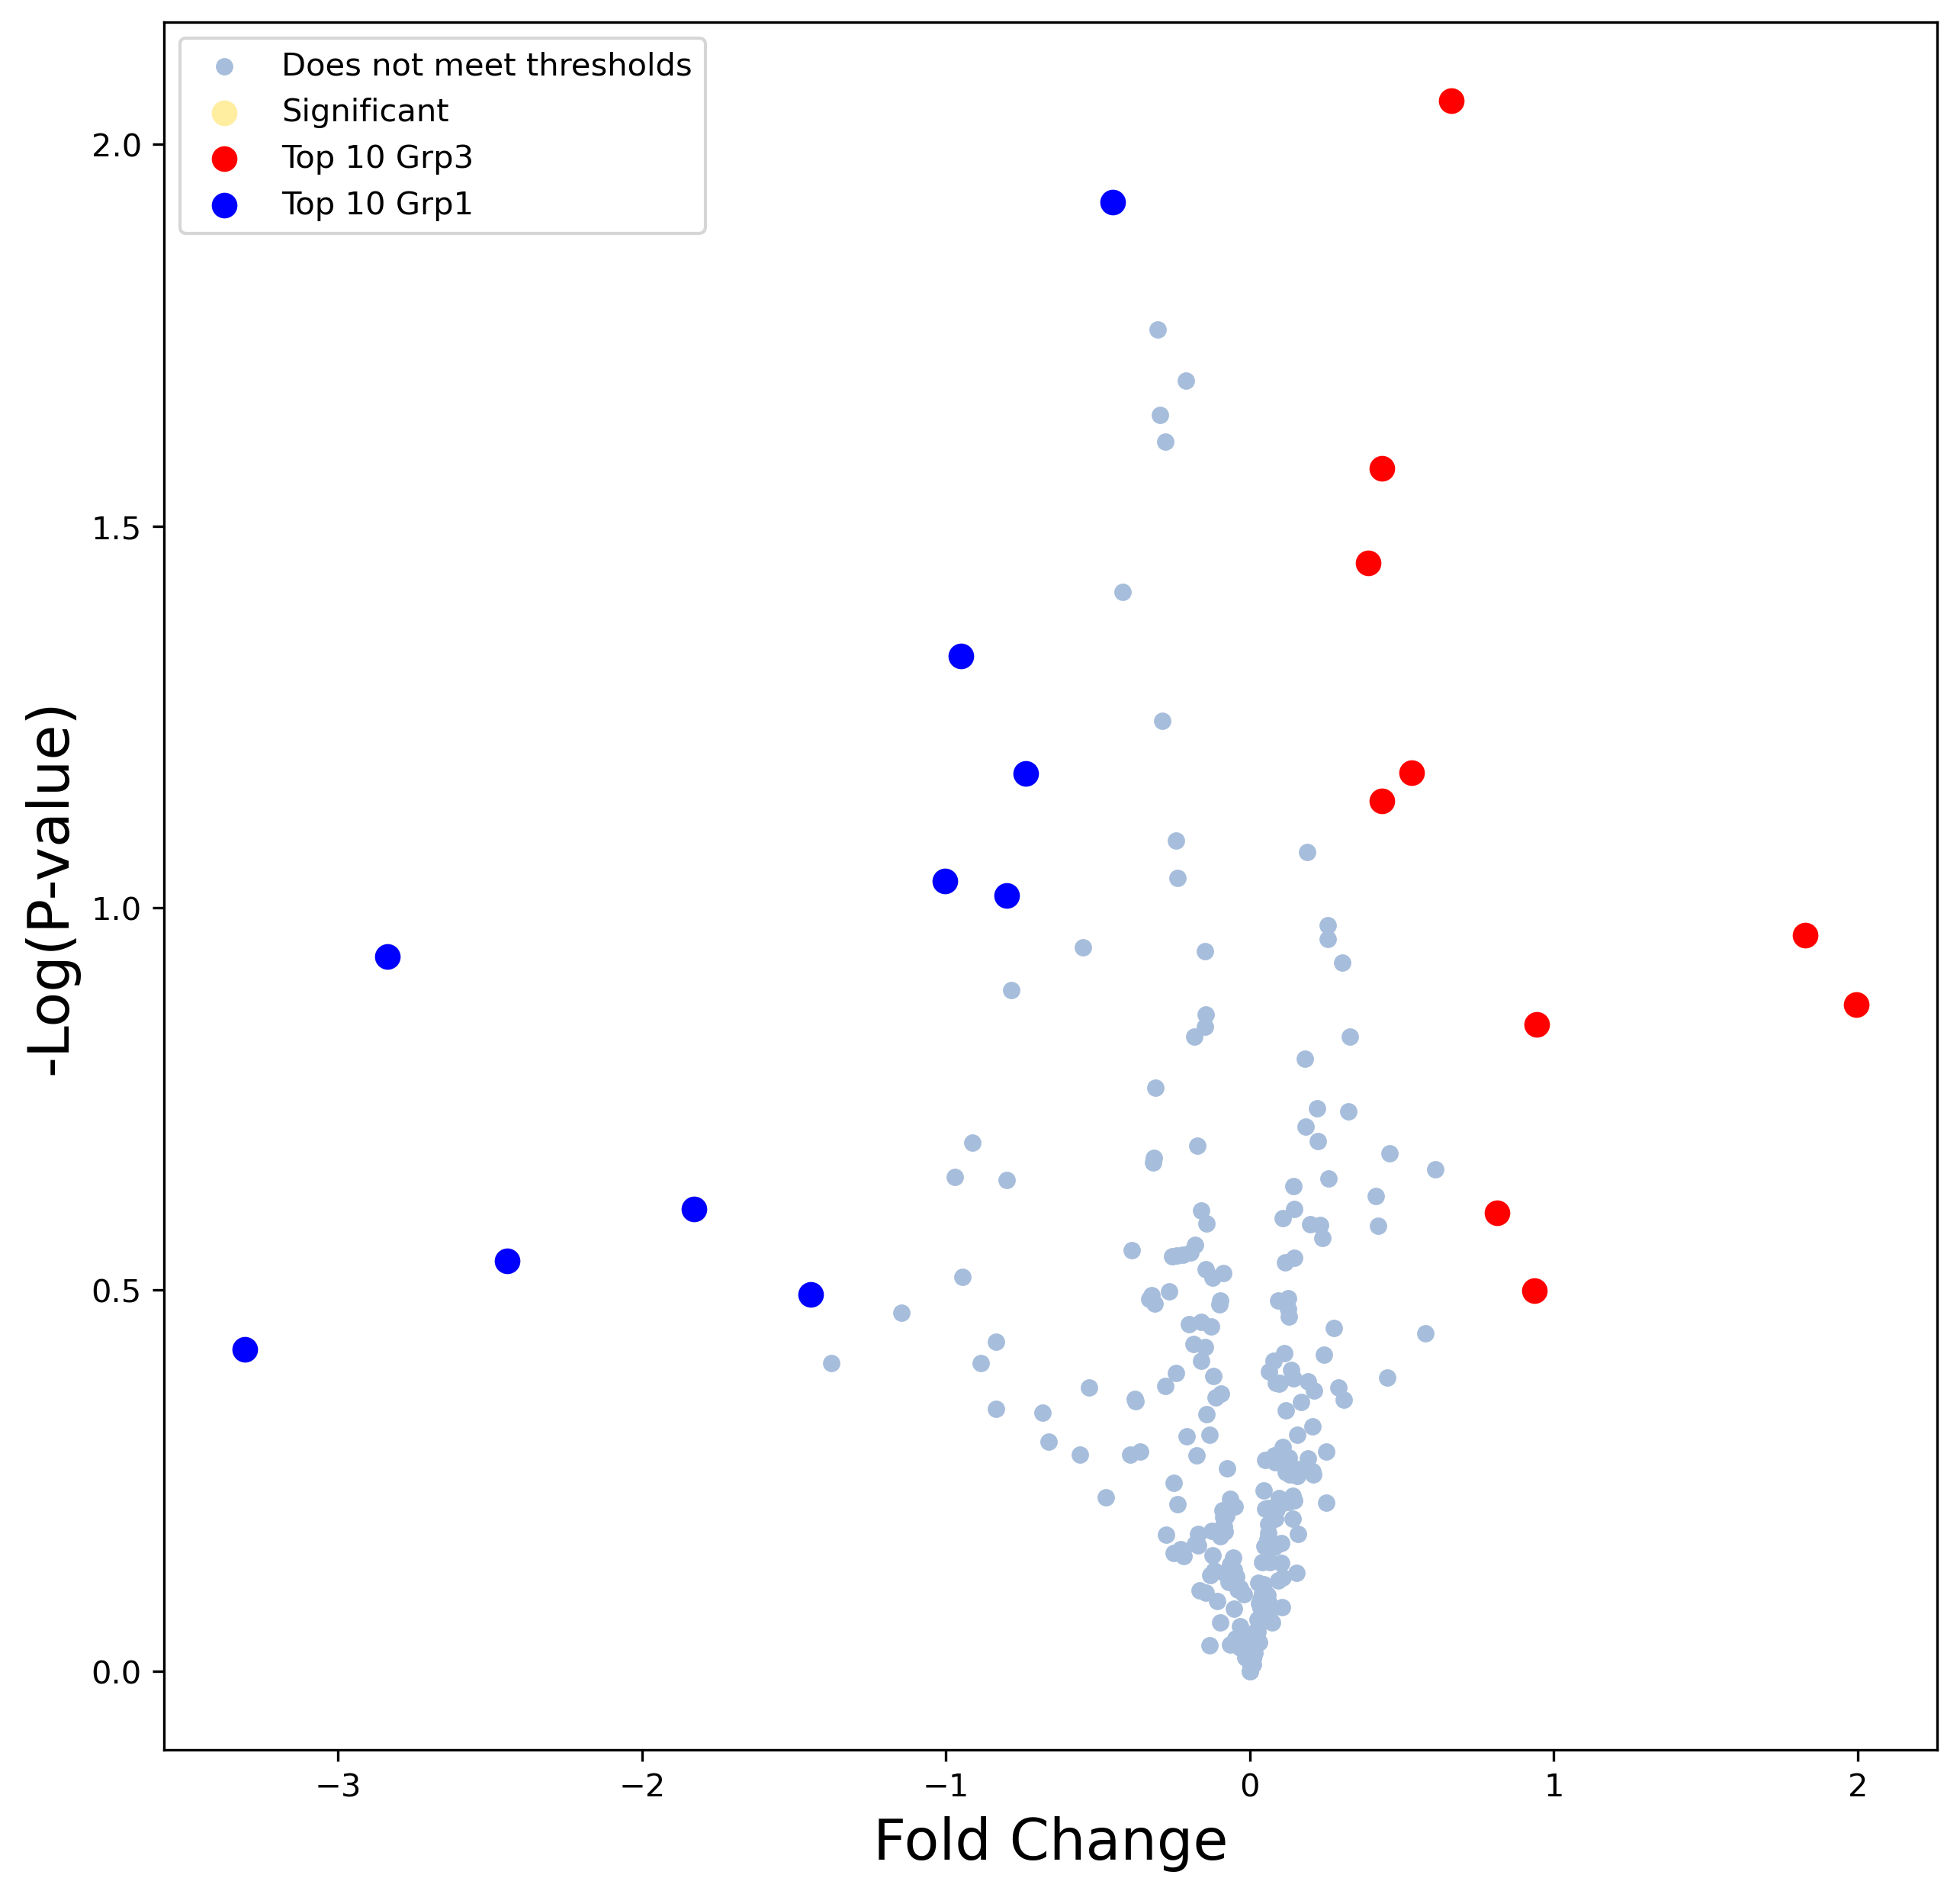

In [153]:
volcanotop10(Normalized_df2,df_sign,top10df,low10df,'Log2(Fold Change)','-Log(P-value)', 'Volcano_Plot_nooutlier.pdf')